# Installing Libs

# Importing Libs

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

from datasets import load_dataset
import openai
from huggingface_hub import login
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV

from transformers import Trainer
from transformers import TrainingArguments
from sentence_transformers import SentenceTransformer
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from transformers import BertTokenizer, BertModel
import nltk
import torch
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Imporing Data

In [ ]:
login(token="TOKEN_HERE")
dataset = load_dataset('Ktzoras/shipping_features', split = 'train')
df = pd.DataFrame(dataset)
del dataset

In [3]:
dataset = load_dataset('Ktzoras/shipping_llm_results_5k_sample', split = 'train')
sample = pd.DataFrame(dataset)
del dataset

In [4]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

In [5]:
sample.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag', '__index_level_0__',
       'en_scale_fe', 'en_scale_rag', 'en_scale_idfe', 'en_scale_idrbfe',
       'en_vessel_type_fe', 'en_vessel_type_rag', 'en_vessel_type_idfe',
       'en_vessel_type_idrbfe', 'en_si

# Analazying Articles

<Axes: xlabel='content', ylabel='Count'>

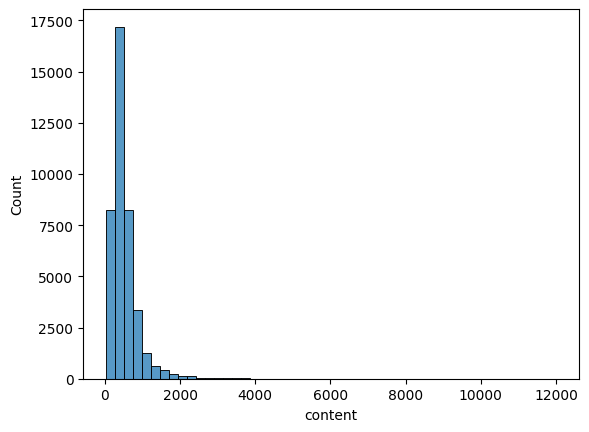

In [5]:
sns.histplot(df['content'].apply(lambda x: len(x.split())), bins=50)

<Axes: xlabel='content', ylabel='Count'>

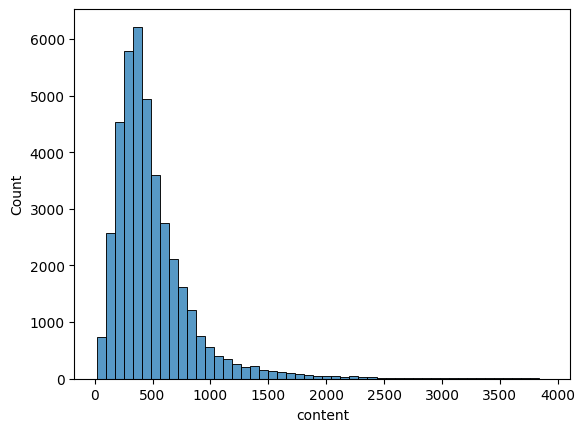

In [14]:
sns.histplot(df['content'].apply(lambda x: len(x.split()) if len(x.split()) < 4000 else None), bins=50)

<Axes: xlabel='content', ylabel='Count'>

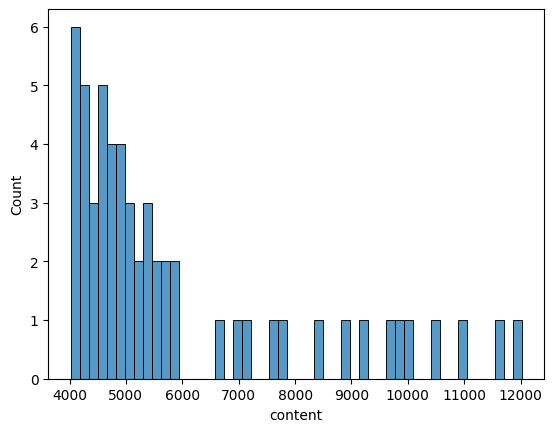

In [15]:
sns.histplot(df['content'].apply(lambda x: len(x.split()) if len(x.split()) > 4000 else None), bins=50)

In [16]:
df.shape

(40013, 43)

In [11]:
print(df['content'].apply(lambda x: len(x.split())).max())
print(df['content'].apply(lambda x: len(x.split())).min())
print(df['content'].apply(lambda x: len(x.split())).mean())
print(df['content'].apply(lambda x: len(x.split())).std())

12017
20
509.0763501861895
427.47569340632526


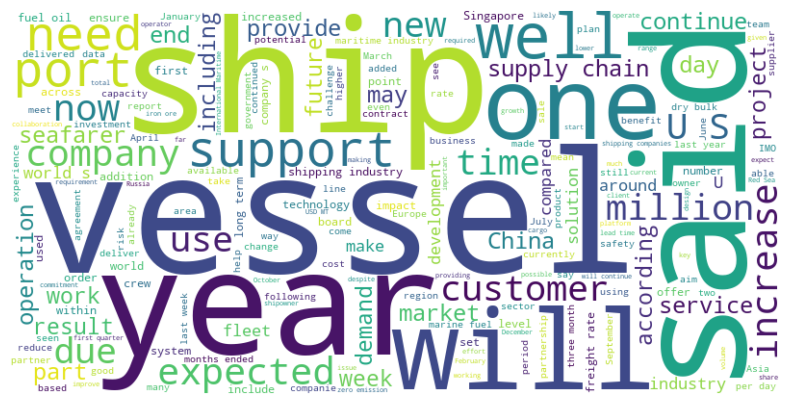

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all content into a single string
text = " ".join(df['content'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

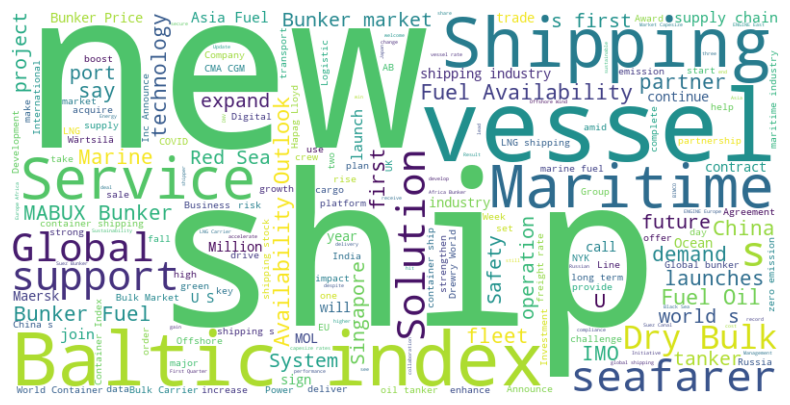

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all content into a single string
text = " ".join(df['title'].astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Functions

In [29]:
def get_article_embeddings(articles, tokenizer, model, device, max_length=512):
    embeddings = []
    for article in tqdm(articles):
        tokens = tokenizer(
            article,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            outputs = model(
                input_ids=tokens['input_ids'],
                attention_mask=tokens['attention_mask']
            )
            # Get [CLS] embedding for the whole article
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
            embeddings.append(cls_emb)
    return np.array(embeddings)

In [5]:
logreg = LogisticRegression()
svc = SVC(kernel = 'linear', probability = True)
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
grb = GradientBoostingClassifier()

vt = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('svc', svc),
    ('rf', rf),
    ('dt', dt),
    ('knn', knn)
], voting='soft')
bag = BaggingClassifier(n_estimators=10, random_state=42)
hist_grb = HistGradientBoostingClassifier()
stack = StackingClassifier(estimators=[
    ('logreg', logreg),
    ('svc', svc),
    ('rf', rf),
    ('dt', dt),
    ('knn', knn)
], final_estimator=LogisticRegression())
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

models = [logreg, svc, rf, dt, knn, vt, bag, hist_grb, stack, ada, extra_trees]

results = []
def train_and_evaluate_model(models, train_x, train_y, test_x, test_y, results, data, feature, size, optimize = False):
    if torch.is_tensor(train_y):
        train_y = train_y.cpu().numpy()
    if torch.is_tensor(test_y):
        test_y = test_y.cpu().numpy()
    if torch.is_tensor(train_x):
        train_x = train_x.cpu().numpy()
    if torch.is_tensor(test_x):
        test_x = test_x.cpu().numpy()
    if not optimize:
            # Before your model training loop, add:

        for model in models:
            model.fit(train_x, train_y)
            pred = model.predict(test_x)
            acc = accuracy_score(test_y, pred)
            f1 = f1_score(test_y, pred, average='weighted')
            precision = precision_score(test_y, pred, average='weighted')
            recall = recall_score(test_y, pred, average='weighted')
            results.append((data, feature, model.__class__.__name__, optimize, size, acc, f1, precision, recall))
            print(f"Model: {model.__class__.__name__}")
            print(f"Data type: {data}")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print("\n" + "="*50 + "\n")

            results_df = pd.DataFrame(results, columns=['Data', 'Feature', 'Model', 'Optimized', 'Size', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
            results_df = results_df.sort_values(by='F1 Score', ascending=False)
            # results = pd.concat([pd.DataFrame(results), results_df], axis = 0)


    else:


        param_grids = {
            'LogisticRegression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100]
            },
            'SVC': {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto']  # add if using RBF/poly/sigmoid kernels
            },
            'RandomForestClassifier': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'DecisionTreeClassifier': {
                'max_depth': [None, 5, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'KNeighborsClassifier': {
                'n_neighbors': list(range(1, 21)),  # from 1 to 20
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            },
            'GradientBoostingClassifier': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            },
            'VotingClassifier': {
                'voting': ['soft', 'hard'],
                'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1]]  # Example weights
            },
            'BaggingClassifier': {
                'n_estimators': [10, 50, 100],
                'max_samples': [0.5, 0.75, 1.0],
                'max_features': [0.5, 0.75, 1.0]
            },
            'HistGradientBoostingClassifier': {
                'max_iter': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_leaf': [1, 2, 4]
            },
            'StackingClassifier': {
                'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
                'cv': [3, 5]
            },
            'AdaBoostClassifier': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2]
            },
            'ExtraTreesClassifier': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        }


        for model in models:
            model_name = model.__class__.__name__
            param_grid = param_grids.get(model_name, {})

            grid = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
            grid.fit(train_x, train_y)
            best_model = grid.best_estimator_
            pred = best_model.predict(test_x)
            acc = accuracy_score(test_y, pred)
            f1 = f1_score(test_y, pred, average='weighted')
            precision = precision_score(test_y, pred, average='weighted')
            recall = recall_score(test_y, pred, average='weighted')
            results.append((data, feature, model.__class__.__name__, optimize, size, acc, f1, precision, recall))
            print(f"Model: {model_name} (Optimized)")
            print(f"Data type: {data}")
            print(f"Accuracy: {acc:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print("\n" + "="*50 + "\n")

            results_df = pd.DataFrame(results, columns=['Data', 'Feature', 'Model', 'Optimized', 'Size', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
            results_df = results_df.sort_values(by='F1 Score', ascending=False)

# Encode

In [4]:
sample['Scale_fe'].value_counts()

Scale_fe
Global      2712
None        1577
Regional     465
National     246
Name: count, dtype: int64

In [5]:
def encode_scale(data):
    if data == 'Global':
        return 2
    if data == 'Regional':
        return 1
    if data == 'Local':
        return 1
    if data == 'None':
        return 0
    else:
        return 0

In [9]:
sample['en_scale_fe'] = sample['Scale_fe'].apply(encode_scale)
sample['en_scale_rag'] = sample['Scale_rag'].apply(encode_scale)
sample['en_scale_idfe'] = sample['Scale_idfe'].apply(encode_scale)
sample['en_scale_idrbfe'] = sample['Scale_idrbfe'].apply(encode_scale)

In [10]:
sample['Type of Vessel_fe'].value_counts()

Type of Vessel_fe
Other                           3562
None                             947
Dry                              452
All                               21
Bulk Carrier                      14
Oil/Chemical tanker                1
Container                          1
Supramax                           1
Oil Tanker / Chemical Tanker       1
Name: count, dtype: int64

In [11]:
def encode_type_of_vessel(data):
    if data == 'All' or data == 'Bulk Carrier' or data == 'Dry' or data == 'Supramax' or data == 'Panamax' or data == 'Handymax' or data == 'Handysize':
        return 1
    else:
        return 0

In [12]:
sample['en_vessel_type_fe'] = sample['Type of Vessel_fe'].apply(encode_type_of_vessel)
sample['en_vessel_type_rag'] = sample['Type of Vessel_rag'].apply(encode_type_of_vessel)
sample['en_vessel_type_idfe'] = sample['Type of Vessel_idfe'].apply(encode_type_of_vessel)
sample['en_vessel_type_idrbfe'] = sample['Type of Vessel_idrbfe'].apply(encode_type_of_vessel)

In [13]:
sample['en_vessel_type_fe'].value_counts()

en_vessel_type_fe
0    4512
1     488
Name: count, dtype: int64

In [14]:
sample['Vessel Size_fe'].value_counts()

Vessel Size_fe
None                             2971
All                              1576
Other                             252
Capesize                           83
Panamax                            30
Handysize                          23
Supramax                           14
Aframax                             7
Capesize, Panamax                   6
Newcastlemax                        5
Capesize, Panamax, Supramax         5
Panamax, Supramax                   5
Ultramax                            4
VLCC                                3
Supramax, Handysize                 3
Suezmax                             2
Kamsarmax                           2
Panamax, Supramax, Handysize        2
LR1                                 1
Supramax, Kamsarmax, Ultramax       1
Handysize, Supramax                 1
Supramax, Capsize                   1
Neopanamax                          1
Supramax, Ultramax                  1
Panamax, Capesize                   1
Name: count, dtype: int64

In [15]:
def encode_size_of_vessel(data):
    if data == 'All' or data == 'Capesize' or data == 'Kamsarmax' or data == 'Panamax' or data == 'Newcastlemax' or data == 'Capesize, Panamax' or data == 'Capesize, Panamax, Supramax':
        return 1
    else:
        return 0

In [16]:
sample['en_size_of_vessel_fe'] = sample['Vessel Size_fe'].apply(encode_size_of_vessel)
sample['en_size_of_vessel_rag'] = sample['Vessel Size_rag'].apply(encode_size_of_vessel)
sample['en_size_of_vessel_idfe'] = sample['Vessel Size_idfe'].apply(encode_size_of_vessel)
sample['en_size_of_vessel_idrbfe'] = sample['Vessel Size_idrbfe'].apply(encode_size_of_vessel)

In [17]:
sample['Sea Route_fe'].value_counts()

Sea Route_fe
None     2487
Other    1484
All       984
C5         32
C3         13
Name: count, dtype: int64

In [18]:
def encode_route(data):
    if data == 'All' or data == 'C5':
        return 1
    else:
        return 0

In [19]:
sample['en_route_fe'] = sample['Sea Route_fe'].apply(encode_route)
sample['en_route_rag'] = sample['Sea Route_rag'].apply(encode_route)
sample['en_route_idfe'] = sample['Sea Route_idfe'].apply(encode_route)
sample['en_route_idrbfe'] = sample['Sea Route_idrbfe'].apply(encode_route)

In [29]:
sample['Duration of Positive Impact_fe'].value_counts()

Duration of Positive Impact_fe
None      3209
Long      1269
Medium     284
Short      238
Name: count, dtype: int64

In [33]:
def encode_duration(data):
    if data == 'Short-term' or data == 'Short term' or data == 'Short':
        return 30
    elif data == 'Medium-term' or data == 'Medium term' or data == 'Medium':
        return 90
    elif data == 'Long-term' or data == 'Long term' or data == 'Long':
        return 365
    else:
        return 0

In [34]:
sample['en_duration_fe'] = sample['Duration of Positive Impact_fe'].apply(encode_duration)
sample['en_duration_rag'] = sample['Duration of Positive Impact_rag'].apply(encode_duration)
sample['en_duration_idfe'] = sample['Duration of Positive Impact_idfe'].apply(encode_duration)
sample['en_duration_idrbfe'] = sample['Duration of Positive Impact_idrbfe'].apply(encode_duration)

In [23]:
sample['Impact_fe'].value_counts()

Impact_fe
None        2295
Positive    1899
Negative     806
Name: count, dtype: int64

In [35]:
def encode_impact(data):
    if data == 'Positive' or data == 'Positive Impact':
        return 1
    elif data == 'Negative' or data == 'Negative Impact':
        return -1
    else:
        return 0

In [36]:
sample['en_impact_fe'] = sample['Impact_fe'].apply(encode_impact)
sample['en_impact_rag'] = sample['Impact_rag'].apply(encode_impact)
sample['en_impact_idfe'] = sample['Impact_idfe'].apply(encode_impact)
sample['en_impact_idrbfe'] = sample['Impact_idrbfe'].apply(encode_impact)

In [26]:
sample['Hire Rate Impact_fe'].value_counts()

Hire Rate Impact_fe
None           2478
Moderate       2045
Significant     309
Minor           155
Major            13
Name: count, dtype: int64

In [27]:
def encode_impact_size(data):
    if data == 'Major':
        return 4
    elif data == 'Significant':
        return 3
    elif data == 'Moderate':
        return 2
    elif data == 'Minor':
        return 1
    else:
        return 0

In [28]:
sample['en_impact_size_fe'] = sample['Hire Rate Impact_fe'].apply(encode_impact_size)
sample['en_impact_size_rag'] = sample['Hire Rate Impact_rag'].apply(encode_impact_size)
sample['en_impact_size_idfe'] = sample['Hire Rate Impact_idfe'].apply(encode_impact_size)
sample['en_impact_size_idrbfe'] = sample['Hire Rate Impact_idrbfe'].apply(encode_impact_size)

In [29]:
sample['en_impact_size_fe'].value_counts()

en_impact_size_fe
0    2478
2    2045
3     309
1     155
4      13
Name: count, dtype: int64

In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(sample)
login(token="TOKEN_HERE")
dataset.push_to_hub('shipping_llm_results_5k_sample')
del dataset

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

# Classic ML Runs

In [10]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

In [11]:
sample.columns

Index(['link', 'date', 'title', 'content', 'vectors_L6_v2', 'vectors_distil',
       'classes_distil', 'Scale_fe', 'Type of Vessel_fe', 'Vessel Size_fe',
       'Sea Route_fe', 'Duration of Positive Impact_fe', 'Impact_fe',
       'Hire Rate Impact_fe', 'Scale_rag', 'Type of Vessel_rag',
       'Vessel Size_rag', 'Sea Route_rag', 'Duration of Positive Impact_rag',
       'Impact_rag', 'Hire Rate Impact_rag', 'Scale_idfe',
       'Type of Vessel_idfe', 'Vessel Size_idfe', 'Sea Route_idfe',
       'Duration of Positive Impact_idfe', 'Impact_idfe',
       'Hire Rate Impact_idfe', 'Scale_idrbfe', 'Type of Vessel_idrbfe',
       'Vessel Size_idrbfe', 'Sea Route_idrbfe',
       'Duration of Positive Impact_idrbfe', 'Impact_idrbfe',
       'Hire Rate Impact_idrbfe', 'Hire rate impact_rag', '__index_level_0__',
       'en_scale_fe', 'en_scale_rag', 'en_scale_idfe', 'en_scale_idrbfe',
       'en_vessel_type_fe', 'en_vessel_type_rag', 'en_vessel_type_idfe',
       'en_vessel_type_idrbfe', 'en_si

In [17]:
results = []
opt = True

In [19]:
for emb in ['sen_emb']:#, 'sen_emb_mean', 'sen_emb_max',
       #'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       #'full_emb']:
    
      for feature in ['en_scale_fe', 'en_scale_rag', 'en_scale_idfe', 'en_scale_idrbfe',
       'en_vessel_type_fe', 'en_vessel_type_rag', 'en_vessel_type_idfe',
       'en_vessel_type_idrbfe', 'en_size_of_vessel_fe',
       'en_size_of_vessel_rag', 'en_size_of_vessel_idfe',
       'en_size_of_vessel_idrbfe', 'en_route_fe', 'en_route_rag',
       'en_route_idfe', 'en_route_idrbfe', 'en_duration_fe', 'en_duration_rag',
       'en_duration_idfe', 'en_duration_idrbfe', 'en_impact_fe',
       'en_impact_rag', 'en_impact_idfe', 'en_impact_idrbfe',
       'en_impact_size_fe', 'en_impact_size_rag', 'en_impact_size_idfe',
       'en_impact_size_idrbfe']:
            for size in [5000]:  
                  print(f"Processing embedding: {emb}, feature: {feature}, size: {size}")
                  X = df[:size][emb].values
                  y = sample[:size][feature].values
                  stratify_y = sample[:size][feature].values  # Use only the first `size` elements

                  X_train, X_test, y_train, y_test = train_test_split(
                  X, y, test_size=0.2, random_state=42, stratify=stratify_y
                  )

                  if emb == 'sen_emb':
                        X_train = np.array([np.array(x) for x in X_train])
                        X_test = np.array([np.array(x) for x in X_test])
                  else:
                        X_train = np.array([np.mean(np.array(x), axis=0) for x in X_train])
                        X_test = np.array([np.mean(np.array(x), axis=0) for x in X_test])
                  # If the result is 1D, reshape to 2D
                        if X_train.ndim == 1:
                              X_train = X_train.reshape(-1, 1)
                              X_test = X_test.reshape(-1, 1)

                  train_and_evaluate_model(models, X_train, y_train, X_test, y_test, results, emb, feature, size, optimize=opt)
# results_df = pd.DataFrame(results, columns=['Data', 'Model', 'Optimized', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])       

Processing embedding: sen_emb, feature: en_scale_fe, size: 5000
Model: LogisticRegression (Optimized)
Data type: sen_emb
Accuracy: 0.7130
F1 Score: 0.7078
Precision: 0.7124
Recall: 0.7130


Model: SVC (Optimized)
Data type: sen_emb
Accuracy: 0.7270
F1 Score: 0.7203
Precision: 0.7266
Recall: 0.7270


Model: RandomForestClassifier (Optimized)
Data type: sen_emb
Accuracy: 0.7010
F1 Score: 0.6898
Precision: 0.7122
Recall: 0.7010


Model: DecisionTreeClassifier (Optimized)
Data type: sen_emb
Accuracy: 0.6020
F1 Score: 0.5931
Precision: 0.5999
Recall: 0.6020


Model: KNeighborsClassifier (Optimized)
Data type: sen_emb
Accuracy: 0.6850
F1 Score: 0.6736
Precision: 0.6814
Recall: 0.6850


Model: VotingClassifier (Optimized)
Data type: sen_emb
Accuracy: 0.7150
F1 Score: 0.7091
Precision: 0.7099
Recall: 0.7150


Model: BaggingClassifier (Optimized)
Data type: sen_emb
Accuracy: 0.6960
F1 Score: 0.6866
Precision: 0.7060
Recall: 0.6960


Model: HistGradientBoostingClassifier (Optimized)
Data type: s

In [20]:
results_df = pd.DataFrame(results, columns=['Data', 'Feature', 'Model', 'Optimized', 'Size', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = results_df.sort_values(by='F1 Score', ascending=False)
results_df.to_csv('results.csv', index=False)

# Merging Results

In [6]:
results_df_opt = pd.read_csv('results.csv')
results_df = pd.read_csv('results - Copy.csv')

In [7]:
results_df_opt.head()

Data                 Feature               Model  Optimized  Size  \
0  sen_emb       en_vessel_type_fe  LogisticRegression       True  5000   
1  sen_emb       en_vessel_type_fe                 SVC       True  5000   
2  sen_emb       en_vessel_type_fe  StackingClassifier       True  5000   
3  sen_emb       en_vessel_type_fe    VotingClassifier       True  5000   
4  sen_emb  en_size_of_vessel_idfe  StackingClassifier       True  5000   

   Accuracy  F1 Score  Precision  Recall  
0     0.959  0.954642   0.959324   0.959  
1     0.955  0.949887   0.954758   0.955  
2     0.955  0.949887   0.954758   0.955  
3     0.952  0.945624   0.952510   0.952  
4     0.950  0.944425   0.947912   0.950

In [8]:
results_df.head()

Data            Feature               Model  Optimized  Size  Accuracy  \
0  sen_emb  en_vessel_type_fe  StackingClassifier      False  4000  0.970000   
1  sen_emb  en_vessel_type_fe  LogisticRegression      False  4000  0.968750   
2  sen_emb  en_vessel_type_fe    VotingClassifier      False  4000  0.962500   
3  sen_emb  en_vessel_type_fe  StackingClassifier      False  3000  0.961667   
4  sen_emb  en_vessel_type_fe    VotingClassifier      False  3000  0.961667   

   F1 Score  Precision    Recall  
0  0.967725   0.970349  0.970000  
1  0.966754   0.968226  0.968750  
2  0.958345   0.963994  0.962500  
3  0.957607   0.962029  0.961667  
4  0.957110   0.963222  0.961667

In [9]:
results_df = pd.concat([results_df, results_df_opt], axis=0)

In [10]:
results_df.to_csv('results.csv', index=False)

# Results - Default Parameters

Text(0.5, 1.0, 'F1 Score by Model and Feature')

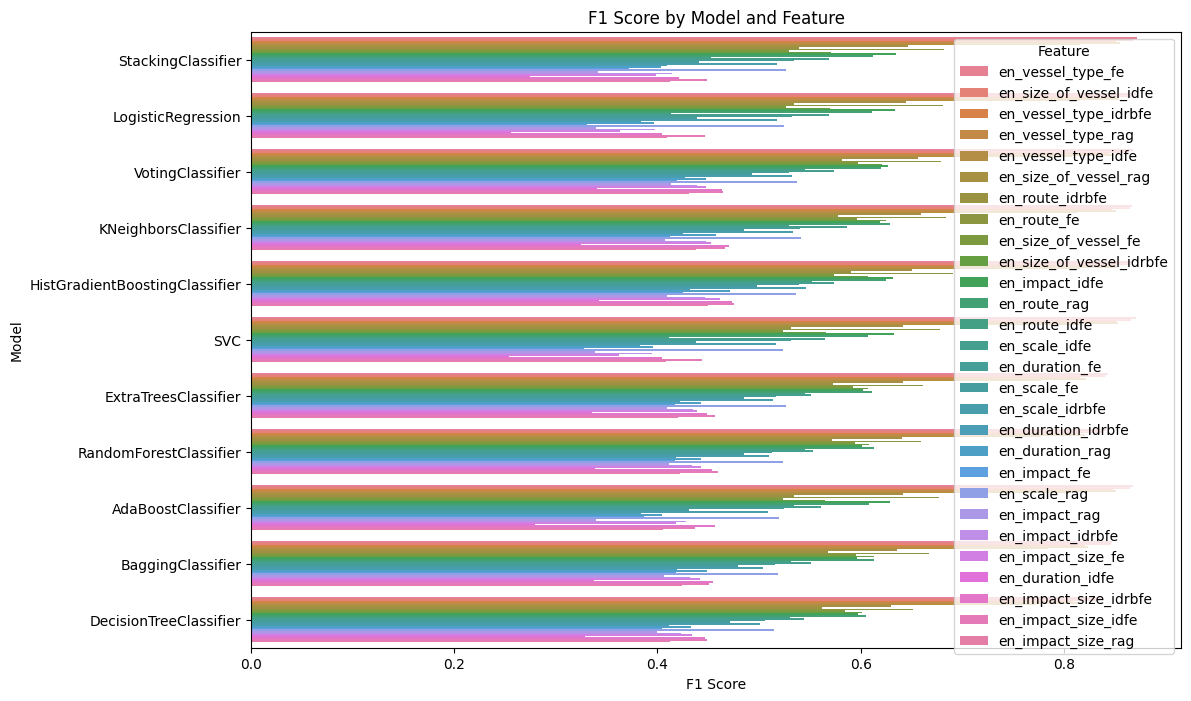

In [13]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='F1 Score', y='Model', hue='Feature', ci=None)
plt.title('F1 Score by Model and Feature')

Text(0.5, 1.0, 'Accuracy by Model and Feature')

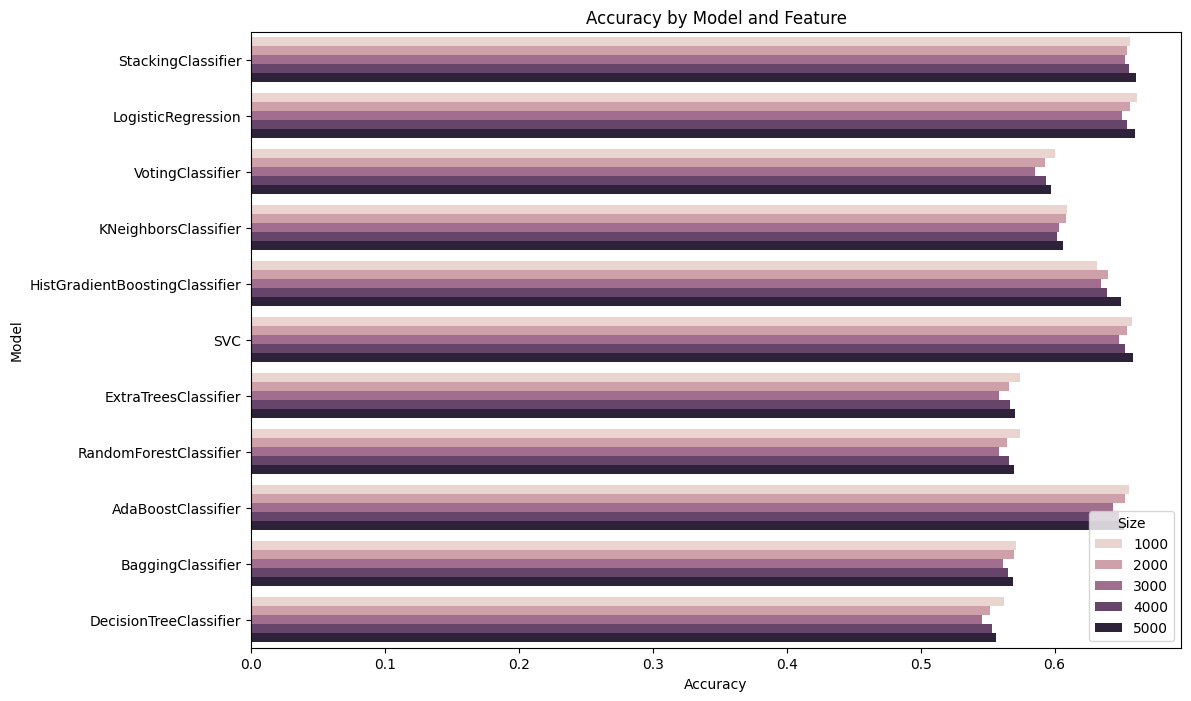

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='Size', ci=None)
plt.title('Accuracy by Model and Feature')

Text(0.5, 1.0, 'Accuracy by Model and RAG Feature')

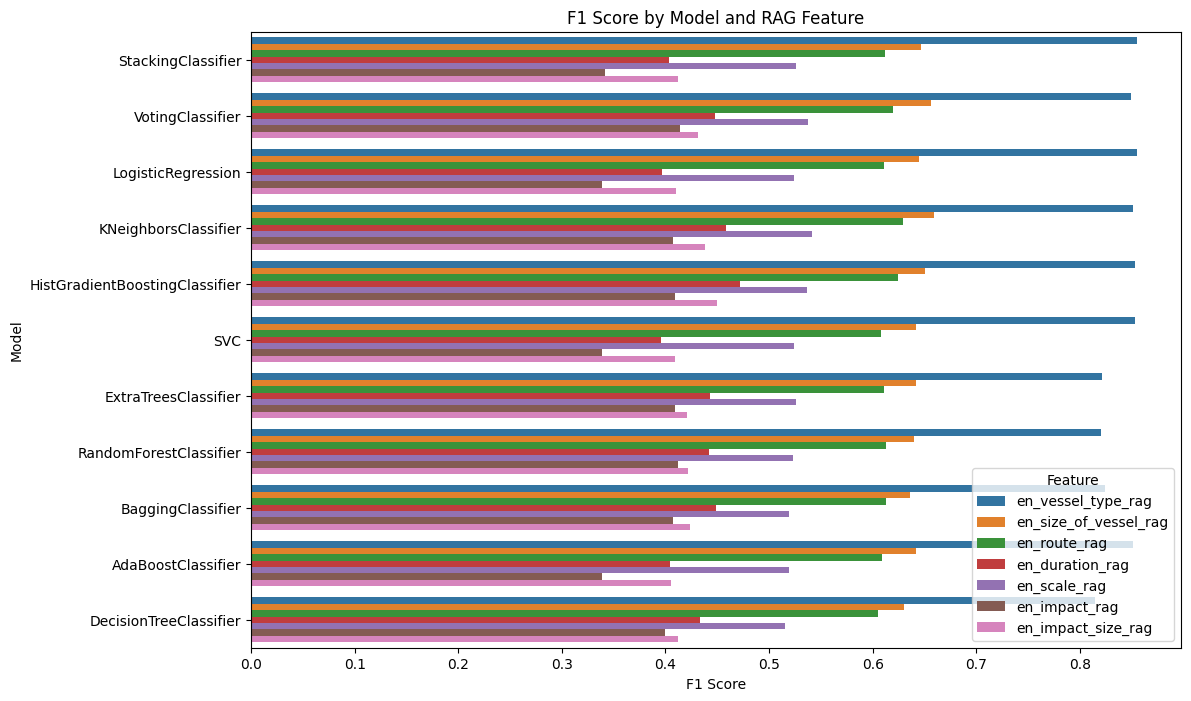

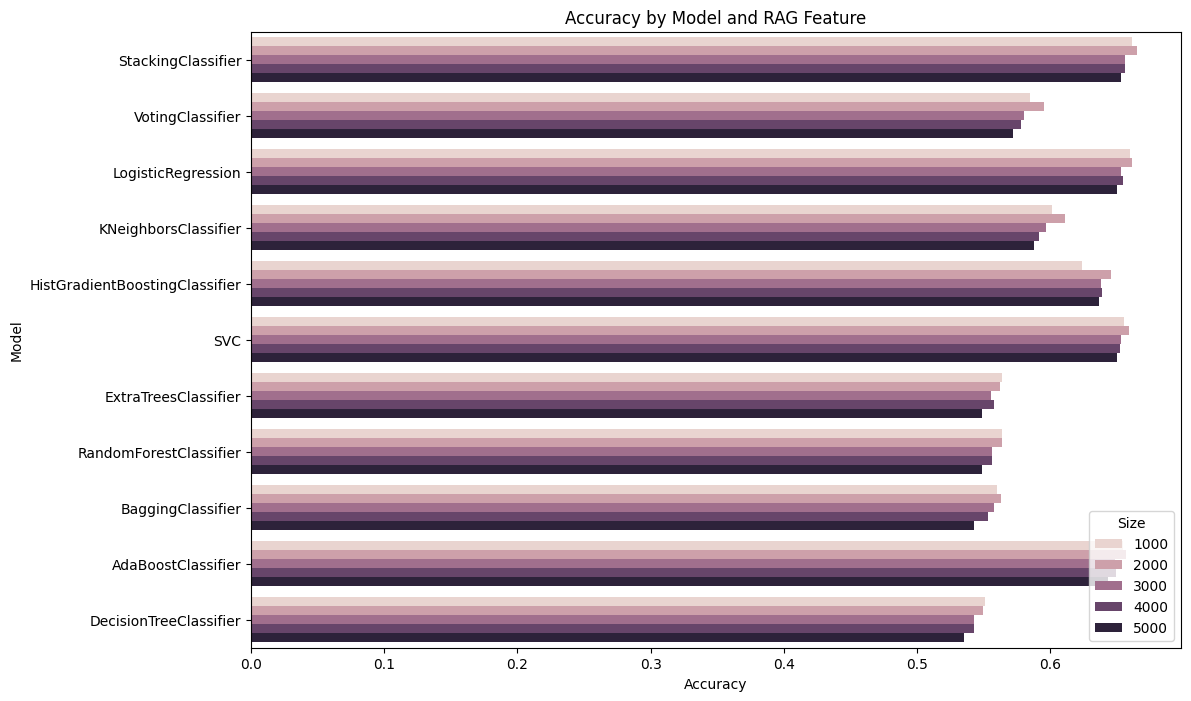

In [38]:
# filter for rag features
rag_features = results_df[results_df['Feature'].str.contains('_rag')]
plt.figure(figsize=(12, 8))
sns.barplot(data=rag_features, x='F1 Score', y='Model', hue='Feature', ci=None)
plt.title('F1 Score by Model and RAG Feature')
plt.figure(figsize=(12, 8))
sns.barplot(data=rag_features, x='Accuracy', y='Model', hue='Size', ci=None)
plt.title('Accuracy by Model and RAG Feature')

<Axes: xlabel='Accuracy', ylabel='Model'>

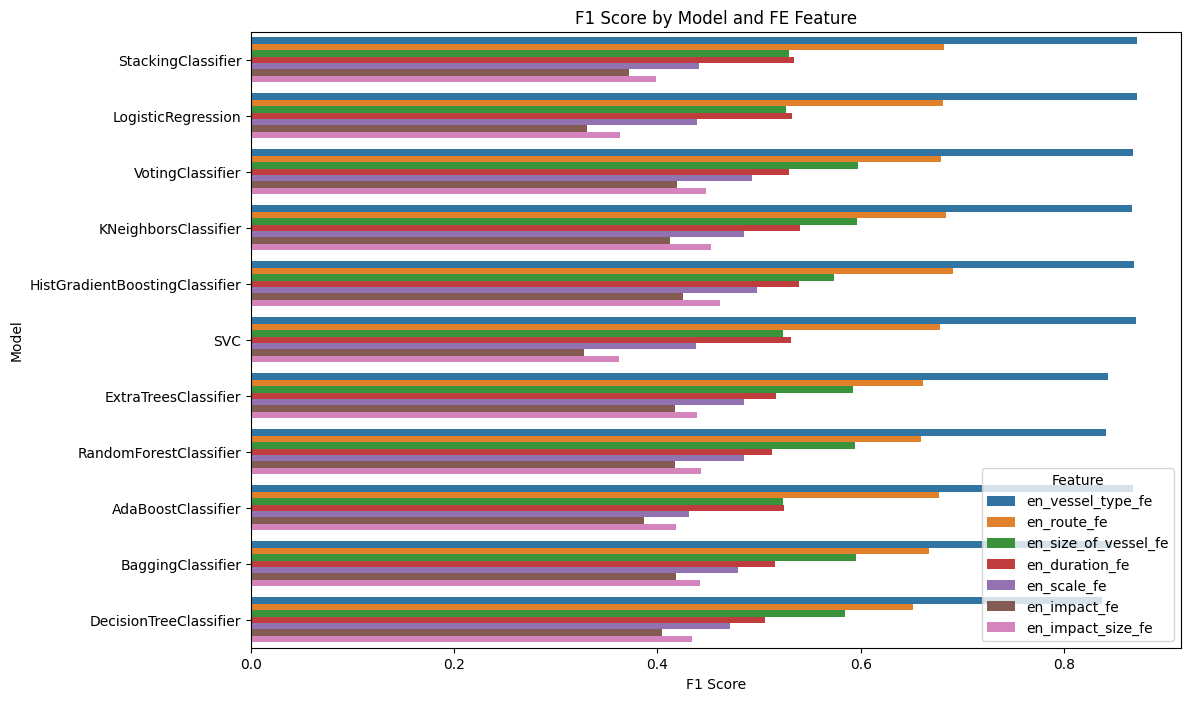

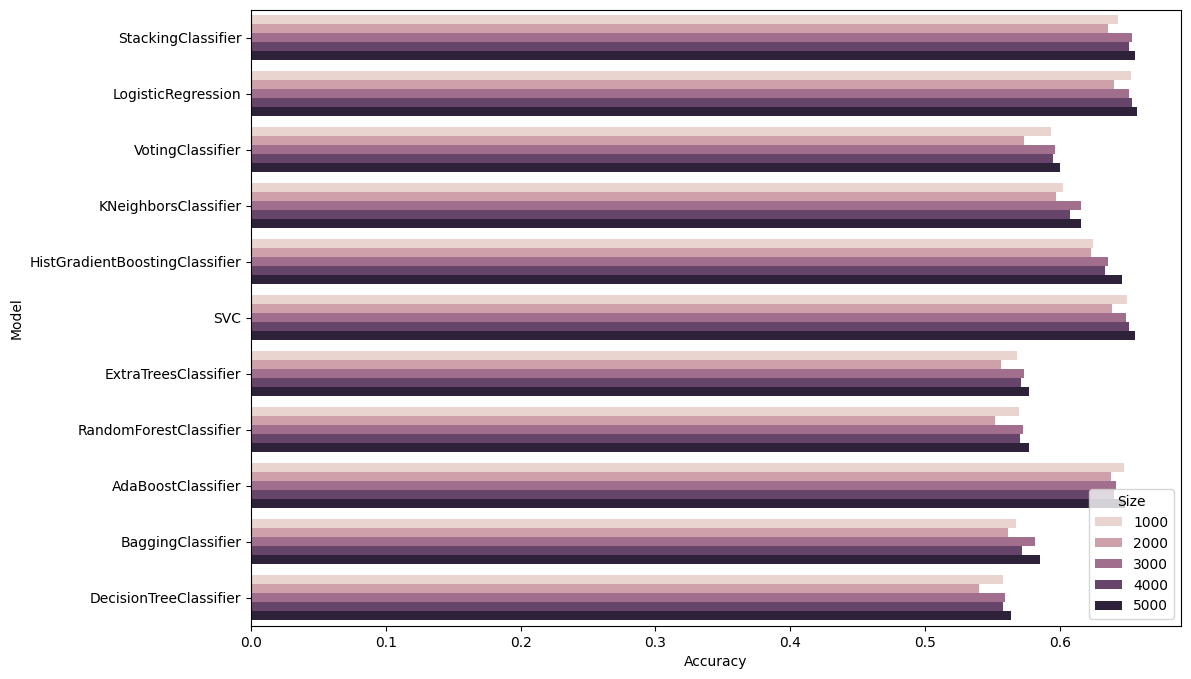

In [39]:
# filter for fe features
fe_features = results_df[results_df['Feature'].str.contains('_fe')]
plt.figure(figsize=(12, 8))
sns.barplot(data=fe_features, x='F1 Score', y='Model', hue='Feature', ci=None)
plt.title('F1 Score by Model and FE Feature')
plt.figure(figsize=(12, 8))
sns.barplot(data=fe_features, x='Accuracy', y='Model', hue='Size', ci=None)

Text(0.5, 1.0, 'Accuracy by Model and IDFE Feature')

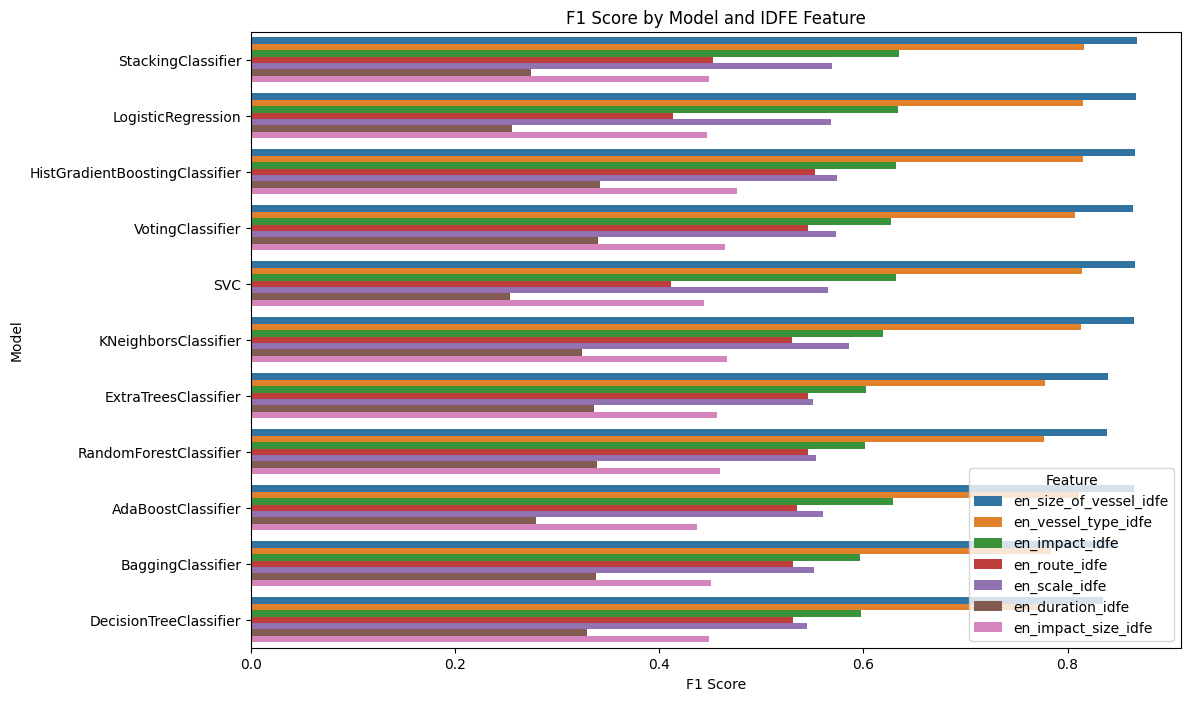

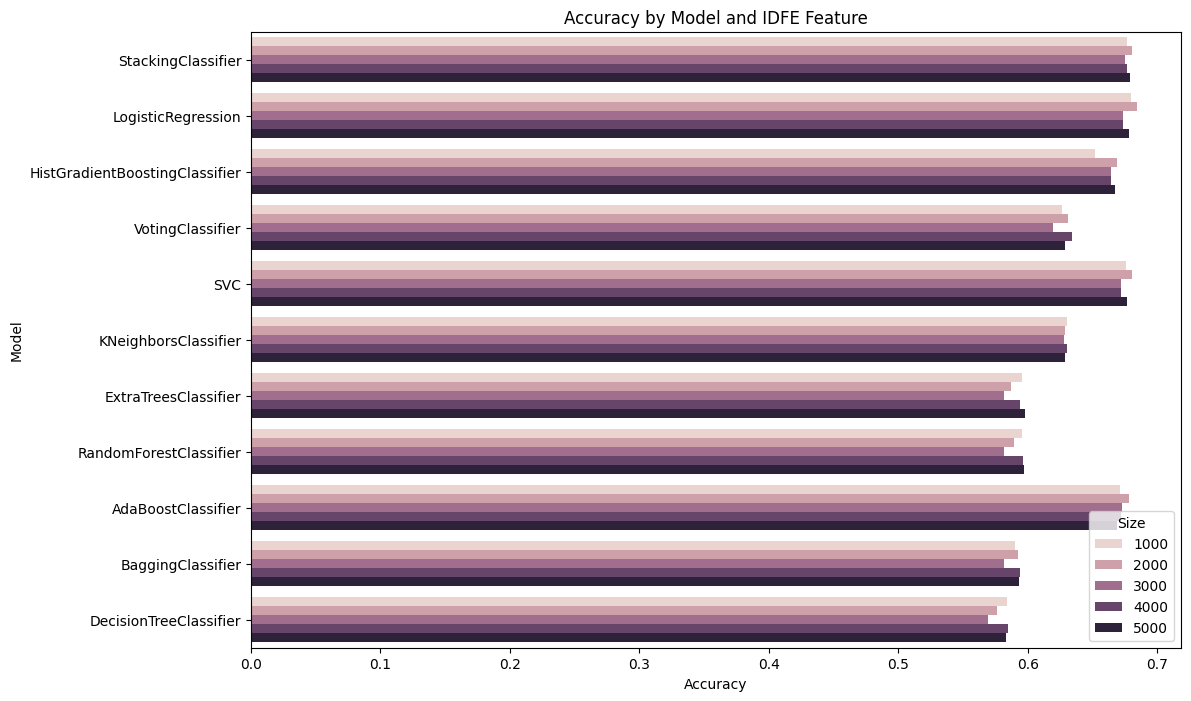

In [40]:
# filter for idfe features
idfe_features = results_df[results_df['Feature'].str.contains('_idfe')]
plt.figure(figsize=(12, 8))
sns.barplot(data=idfe_features, x='F1 Score', y='Model', hue='Feature', ci=None)
plt.title('F1 Score by Model and IDFE Feature')
plt.figure(figsize=(12, 8))
sns.barplot(data=idfe_features, x='Accuracy', y='Model', hue='Size', ci=None)
plt.title('Accuracy by Model and IDFE Feature')

Text(0.5, 1.0, 'Accuracy by Model and IDRBFE Feature')

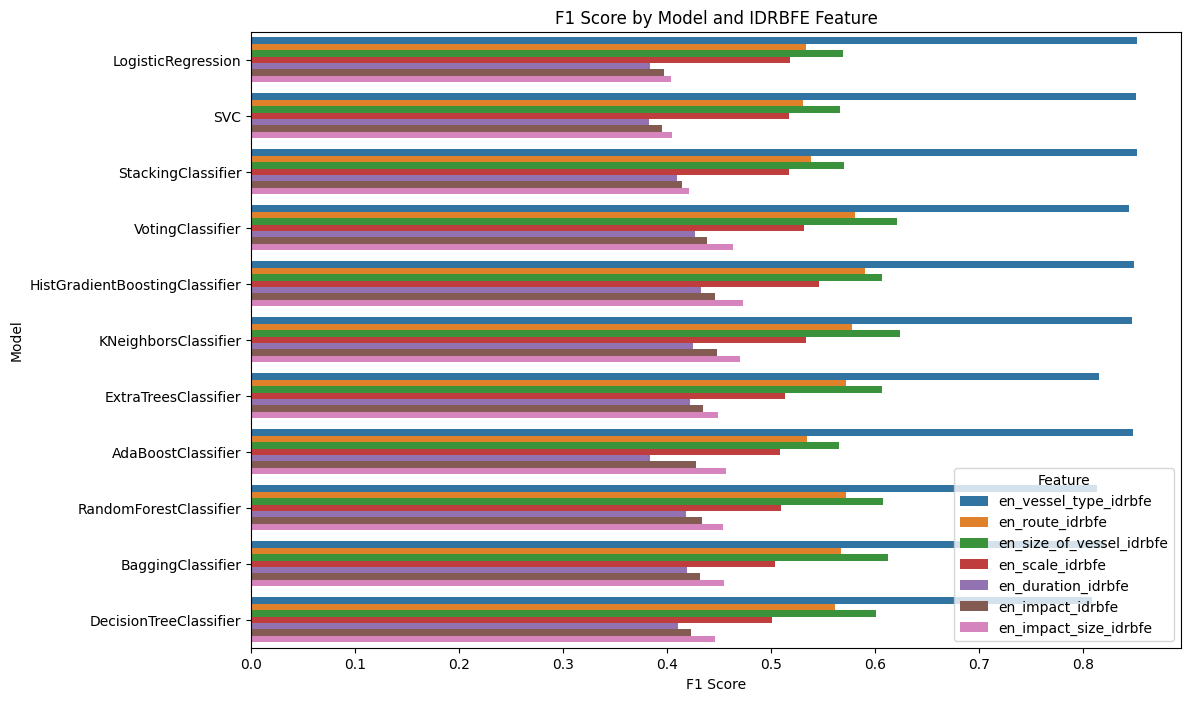

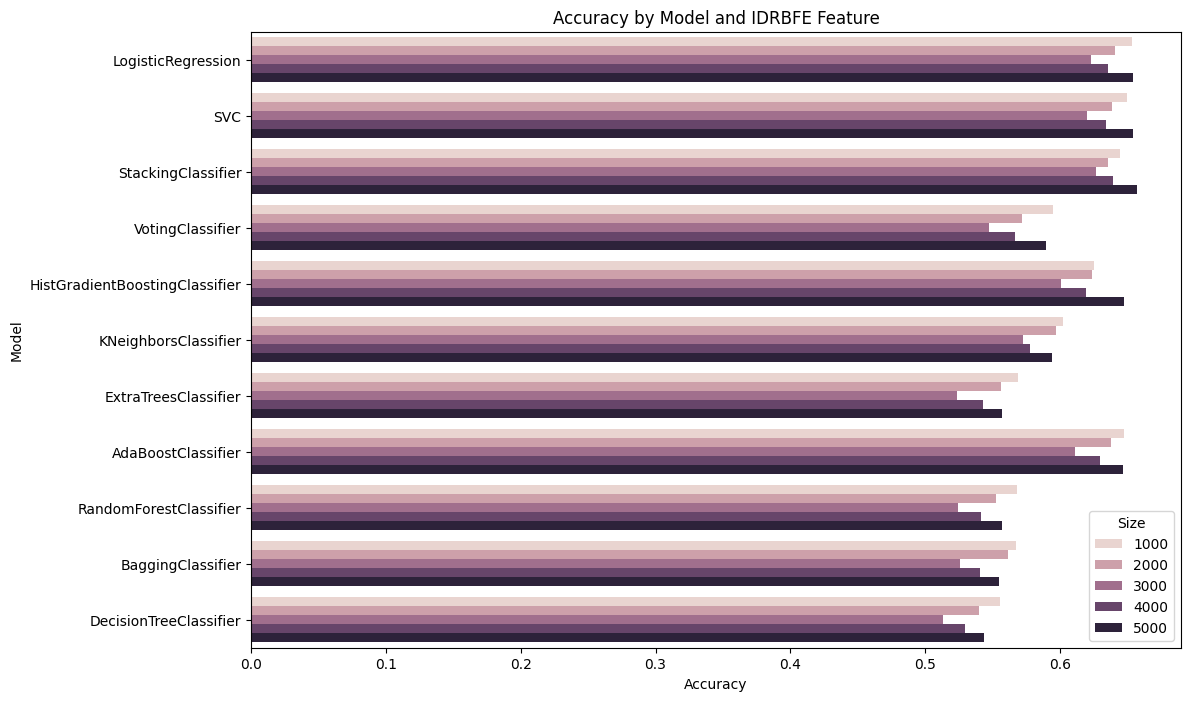

In [41]:
# filter for idrbfe features
idrbfe_features = results_df[results_df['Feature'].str.contains('_idrbfe')]
plt.figure(figsize=(12, 8))
sns.barplot(data=idrbfe_features, x='F1 Score', y='Model', hue='Feature', ci=None)
plt.title('F1 Score by Model and IDRBFE Feature')
plt.figure(figsize=(12, 8))
sns.barplot(data=idrbfe_features, x='Accuracy', y='Model', hue='Size', ci=None)
plt.title('Accuracy by Model and IDRBFE Feature')

Text(0.5, 1.0, 'Accuracy by Model and Data Type')

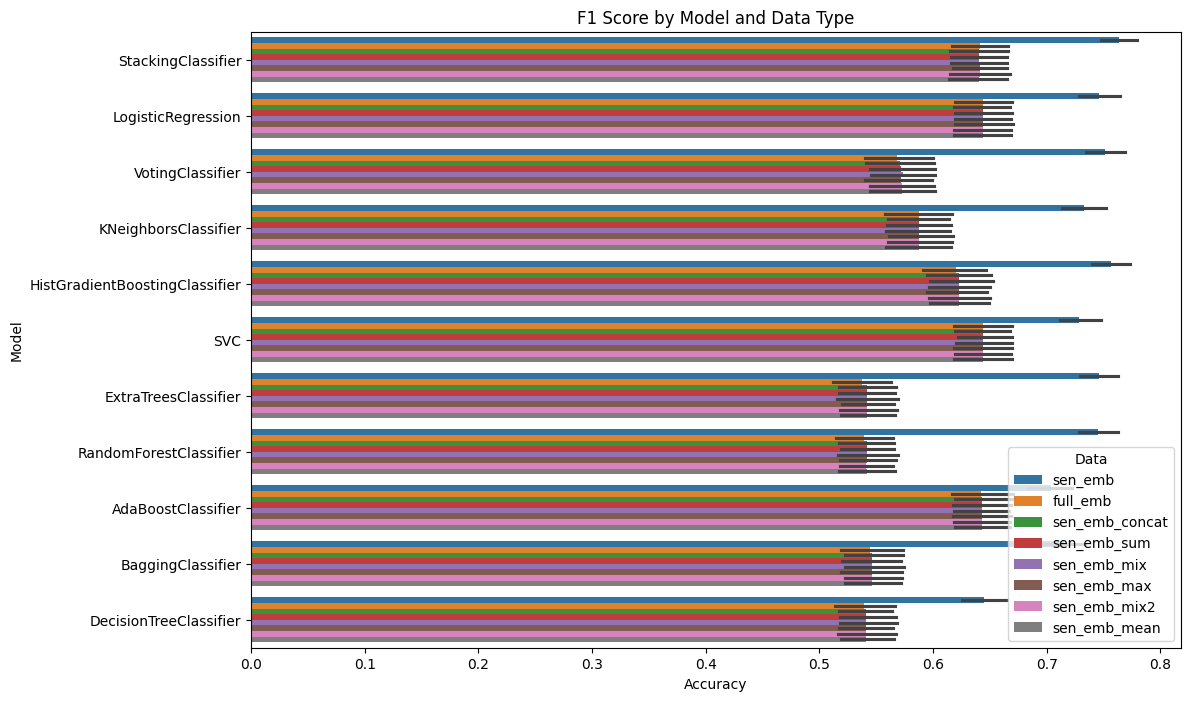

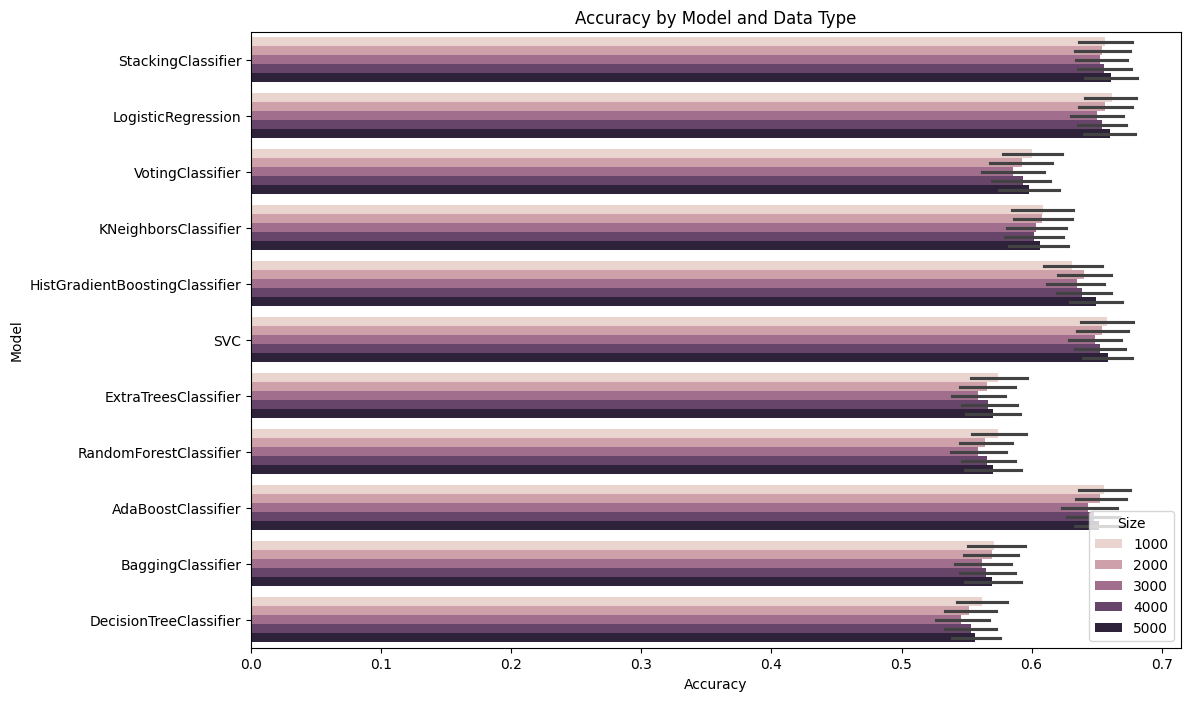

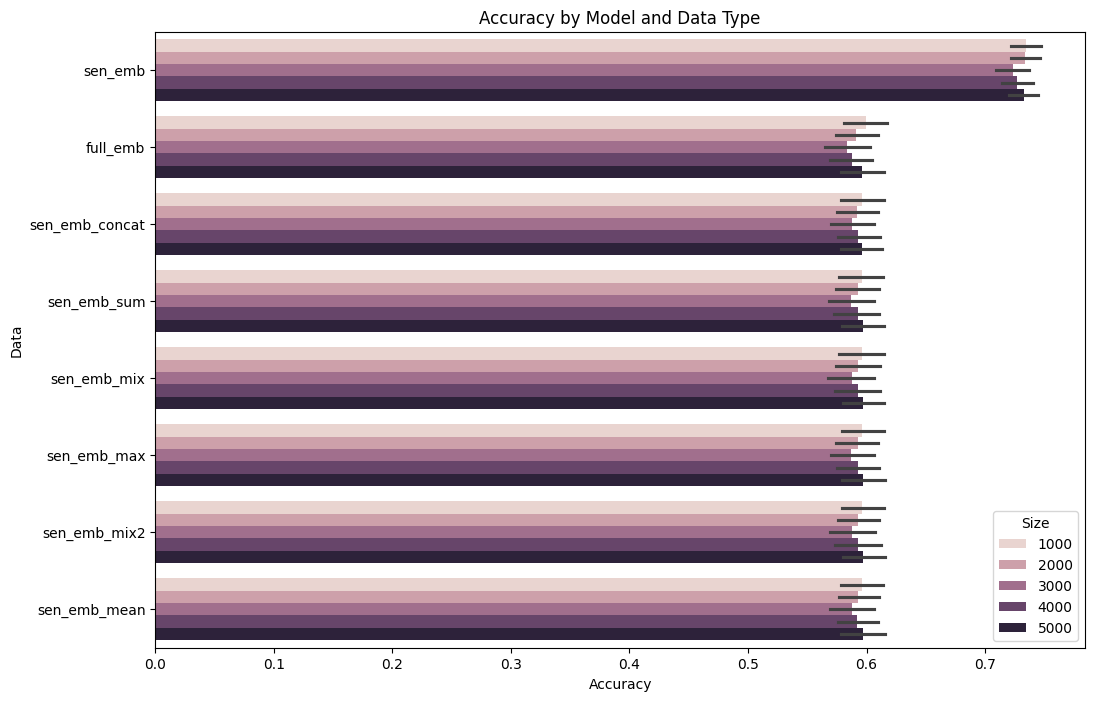

In [42]:
# plot for data type 
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='Data')
plt.title('F1 Score by Model and Data Type')
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='Size')
plt.title('Accuracy by Model and Data Type')
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Data', hue='Size')
plt.title('Accuracy by Model and Data Type')

# Results - Compare Optimized

Text(0.5, 1.0, 'Accuracy by Model and Parameter Optimization')

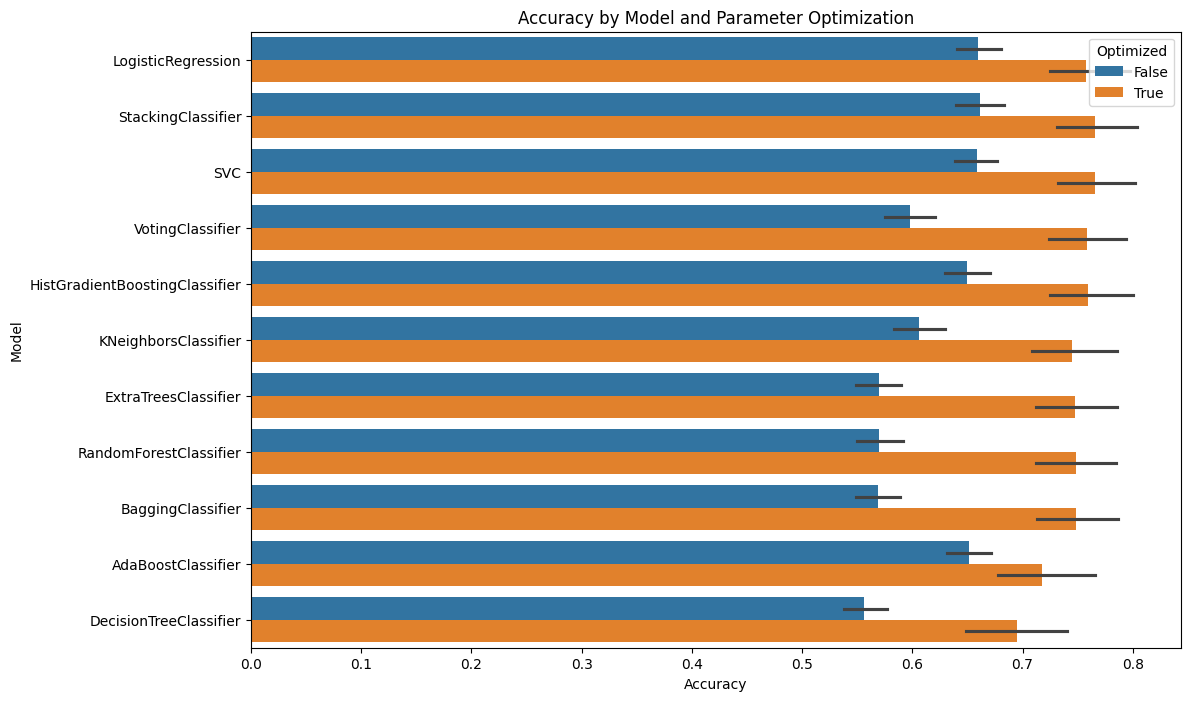

In [14]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df[(results_df['Size'] == 5000)], x='Accuracy', y='Model', hue='Optimized')
plt.title('Accuracy by Model and Parameter Optimization')

Text(0.5, 1.0, 'Accuracy by Feature and Parameter Optimization')

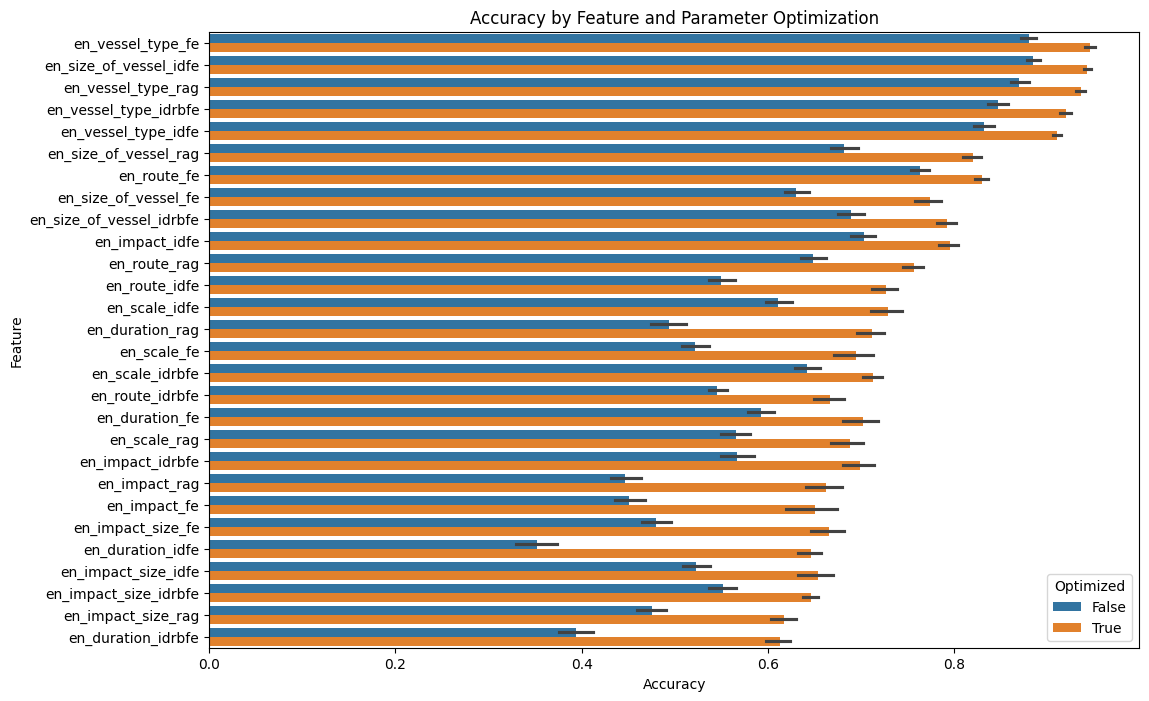

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df[(results_df['Size'] == 5000)], x='Accuracy', y='Feature', hue='Optimized')
plt.title('Accuracy by Feature and Parameter Optimization')

# Deep NN Runs

In [6]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}
from torch import nn

def train(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10, patience=5):
    import copy
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader)) 
        # Validation
        model.eval()
        eval_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                logits = model(input_ids)
                loss = loss_fn(logits, labels)
                eval_loss += loss.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss = eval_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

        # Scheduler step (if ReduceLROnPlateau)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
from torch import nn
results = []
for emb in ['sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb']:
    
      for feature in ['en_scale_fe', 'en_scale_rag', 'en_scale_idfe', 'en_scale_idrbfe',
       'en_vessel_type_fe', 'en_vessel_type_rag', 'en_vessel_type_idfe',
       'en_vessel_type_idrbfe', 'en_size_of_vessel_fe',
       'en_size_of_vessel_rag', 'en_size_of_vessel_idfe',
       'en_size_of_vessel_idrbfe', 'en_route_fe', 'en_route_rag',
       'en_route_idfe', 'en_route_idrbfe', 'en_duration_fe', 'en_duration_rag',
       'en_duration_idfe', 'en_duration_idrbfe', 'en_impact_fe',
       'en_impact_rag', 'en_impact_idfe', 'en_impact_idrbfe',
       'en_impact_size_fe', 'en_impact_size_rag', 'en_impact_size_idfe',
       'en_impact_size_idrbfe']:
            for size in [1000, 2000, 3000, 4000, 5000]:


                X = df[:size][emb].values
                y = sample[:size][feature].values
                stratify_y = sample[:size][feature].values  # Use only the first `size` elements

                X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=stratify_y
                )

                if emb == 'sen_emb':
                    X_train = np.array([np.array(x) for x in X_train])
                    X_test = np.array([np.array(x) for x in X_test])
                else:
                    X_train = np.array([np.mean(np.array(x), axis=0) for x in X_train])
                    X_test = np.array([np.mean(np.array(x), axis=0) for x in X_test])
                # If the result is 1D, reshape to 2D
                    if X_train.ndim == 1:
                            X_train = X_train.reshape(-1, 1)
                            X_test = X_test.reshape(-1, 1)


                train_y_mapped = np.array(y_train, dtype = np.int64)
                test_y_mapped = np.array(y_test, dtype = np.int64)

                NUM_LABELS = len(np.unique(train_y_mapped))

                batch_size = 16
                train_dataset = EmbeddingDataset(X_train, train_y_mapped)
                val_dataset = EmbeddingDataset(X_test, test_y_mapped)
                train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
                val_loader = DataLoader(val_dataset, batch_size = batch_size)

                input_dim = X_train.shape[1]
                model = nn.Sequential(
                    nn.Linear(input_dim, 768),
                    nn.BatchNorm1d(768),
                    nn.GELU(),
                    nn.LeakyReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(768, 256),
                    nn.GELU(),
                    nn.Dropout(0.2),
                    nn.LeakyReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(256, NUM_LABELS)
                )

                device = torch.device("cuda")
                model = model.to(device)
                
                optimizer = AdamW(model.parameters(), lr = 1e-3, weight_decay = 0.01)

                num_epochs = 5
                num_warmup_steps = 10
                num_training_steps = 16
                scheduler = get_scheduler(
                    "linear",
                    optimizer = optimizer,
                    num_warmup_steps = num_warmup_steps,
                    num_training_steps = num_training_steps
                )

                train(model, train_loader, val_loader, optimizer, scheduler, num_epochs = 25)
                model.eval()
                correct = 0
                total = 0
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(device)
                        labels = batch['labels'].to(device)
                        logits = model(input_ids)
                        preds = torch.argmax(logits, dim=-1)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())
                        correct += (preds == labels).sum().item()
                        total += labels.size(0)
                acc = correct / total
                f1 = f1_score(all_labels, all_preds, average='weighted')
                precision = precision_score(all_labels, all_preds, average='weighted')
                recall = recall_score(all_labels, all_preds, average='weighted')
                results.append((emb, feature, "DeepNN", False, size, acc, f1, precision, recall))
                print(f"DeepNN | Data: {emb} | Feature: {feature} | Size: {size}")
                print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
                print("="*50)

# After all runs
results_df = pd.DataFrame(results, columns=['Data', 'Feature', 'Model', 'Optimized', 'Size', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = results_df.sort_values(by='F1 Score', ascending=False)
results_df.to_csv('deepnn_results.csv', index=False)

# PSO Classification 

In [7]:
import torch
import numpy as np
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score
import pyswarms as ps
from torch.optim.lr_scheduler import ReduceLROnPlateau

def pso_objective(hyperparams, X_train, y_train, X_val, y_val, input_dim, num_labels, device):
    # hyperparams: [hidden_dim, dropout, lr, batch_size]
    hidden_dim = int(hyperparams[0])
    dropout = float(hyperparams[1])
    lr = float(hyperparams[2])
    batch_size = int(hyperparams[3])

    # Build model
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, num_labels)
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # DataLoader
    train_dataset = EmbeddingDataset(X_train, y_train)
    val_dataset = EmbeddingDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False)

    # Train for a few epochs (e.g., 3 for speed)
    for epoch in range(3):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            logits = model(input_ids)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids)
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    del model
    torch.cuda.empty_cache()
    return -f1  # Negative because PSO minimizes

def run_pso(X_train, y_train, X_val, y_val, input_dim, num_labels, device):
    # PSO bounds: [hidden_dim, dropout, lr, batch_size]
    bounds = ([64, 0.1, 1e-4, 2], [412, 0.5, 1e-2, 64]) 
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
    def objective(x):
        return np.array([
            pso_objective(params, X_train, y_train, X_val, y_val, input_dim, num_labels, device)
            for params in x
        ])
    optimizer = ps.single.GlobalBestPSO(n_particles=2, dimensions=4, options=options, bounds=bounds)
    best_cost, best_pos = optimizer.optimize(objective, iters=10)
    return best_pos  # [hidden_dim, dropout, lr, batch_size]

import torch
from torch.utils.data import Dataset

class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input_ids': self.X[idx], 'labels': self.y[idx]}

2025-06-27 19:45:46,320 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.735
2025-06-27 19:46:08,625 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7353080126326208, best pos: [2.45645176e+02 3.66861074e-01 1.44833187e-03 4.33094619e+01]


Validation Loss: 0.6638, Accuracy: 0.7020
Validation Loss: 0.6574, Accuracy: 0.7190
Validation Loss: 0.6477, Accuracy: 0.7240
Validation Loss: 0.6552, Accuracy: 0.7230
Validation Loss: 0.6590, Accuracy: 0.7150
Validation Loss: 0.6700, Accuracy: 0.7290
Validation Loss: 0.6877, Accuracy: 0.7100
Validation Loss: 0.6985, Accuracy: 0.7010
Early stopping triggered!


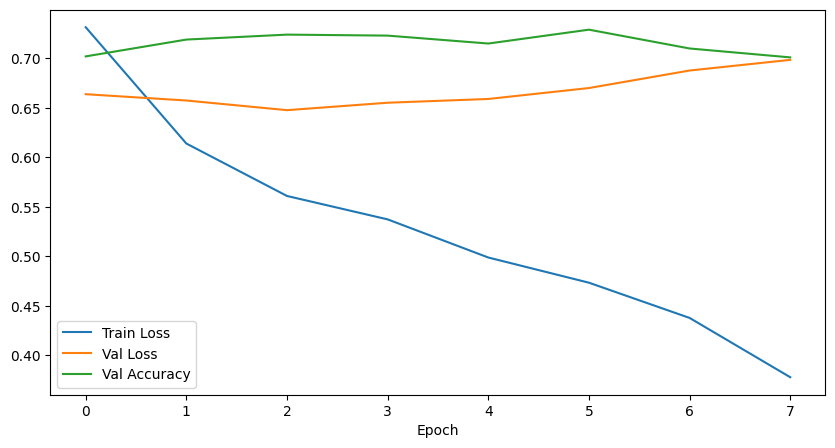

DeepNN | Data: sen_emb | Feature: en_scale_fe | Size: 5000
Accuracy: 0.7240 | F1: 0.7171 | Precision: 0.7231 | Recall: 0.7240


2025-06-27 19:46:10,832 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.696
2025-06-27 19:46:38,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6957375530616208, best pos: [1.67554470e+02 4.37688317e-01 7.41035227e-03 2.87270936e+01]


Validation Loss: 0.6804, Accuracy: 0.7010
Validation Loss: 0.6996, Accuracy: 0.6890
Validation Loss: 0.6657, Accuracy: 0.6880
Validation Loss: 0.6702, Accuracy: 0.6910
Validation Loss: 0.6550, Accuracy: 0.7000
Validation Loss: 0.6605, Accuracy: 0.7070
Validation Loss: 0.6703, Accuracy: 0.6990
Validation Loss: 0.6689, Accuracy: 0.7180
Validation Loss: 0.7417, Accuracy: 0.6980
Validation Loss: 0.6762, Accuracy: 0.7130
Early stopping triggered!


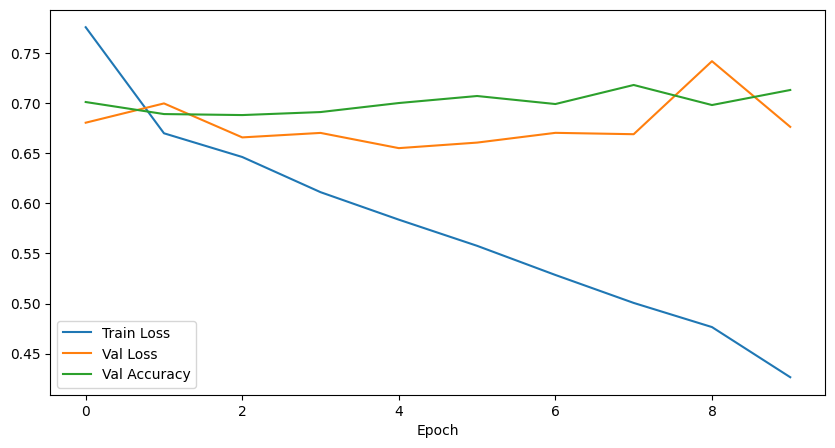

DeepNN | Data: sen_emb | Feature: en_scale_rag | Size: 5000
Accuracy: 0.7000 | F1: 0.6732 | Precision: 0.6810 | Recall: 0.7000


2025-06-27 19:46:41,748 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.749
2025-06-27 19:46:52,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7494819103809218, best pos: [2.14382500e+02 1.31598343e-01 3.88362751e-03 5.61283384e+01]


Validation Loss: 0.6072, Accuracy: 0.7380
Validation Loss: 0.6604, Accuracy: 0.7100
Validation Loss: 0.5868, Accuracy: 0.7420
Validation Loss: 0.7610, Accuracy: 0.7300
Validation Loss: 0.7022, Accuracy: 0.7420
Validation Loss: 0.7460, Accuracy: 0.6820
Validation Loss: 0.7370, Accuracy: 0.7480
Validation Loss: 0.7236, Accuracy: 0.7500
Early stopping triggered!


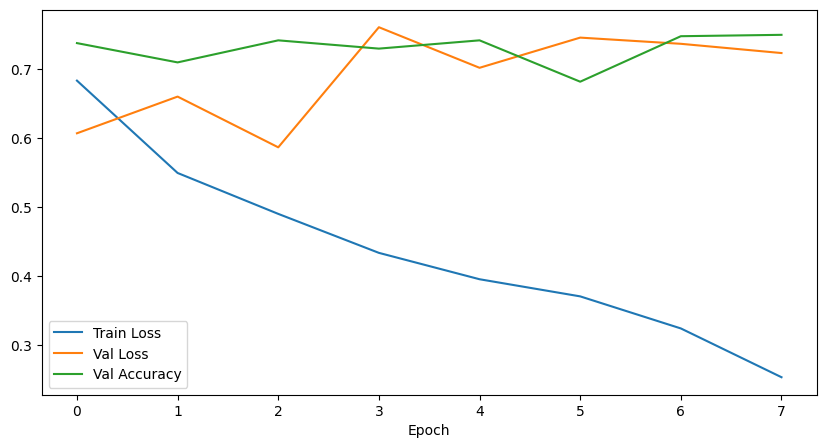

2025-06-27 19:46:54,137 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}


DeepNN | Data: sen_emb | Feature: en_scale_idfe | Size: 5000
Accuracy: 0.7420 | F1: 0.7326 | Precision: 0.7393 | Recall: 0.7420


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.697
2025-06-27 19:47:20,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.696914104455793, best pos: [3.16597865e+02 1.15448077e-01 1.88294725e-03 1.00165023e+01]


Validation Loss: 0.6835, Accuracy: 0.7150
Validation Loss: 0.6956, Accuracy: 0.7050
Validation Loss: 0.6623, Accuracy: 0.7110
Validation Loss: 0.6763, Accuracy: 0.7260
Validation Loss: 0.6632, Accuracy: 0.7210
Validation Loss: 0.6697, Accuracy: 0.7180
Validation Loss: 0.7028, Accuracy: 0.7130
Validation Loss: 0.6931, Accuracy: 0.7130
Early stopping triggered!


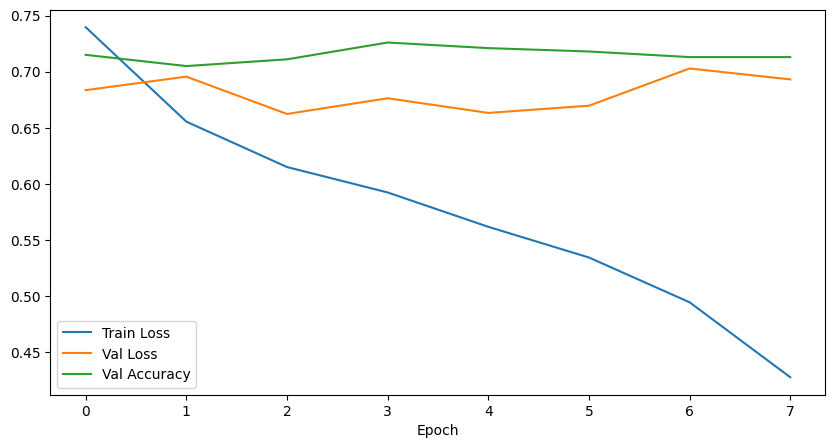

DeepNN | Data: sen_emb | Feature: en_scale_idrbfe | Size: 5000
Accuracy: 0.7110 | F1: 0.6566 | Precision: 0.6721 | Recall: 0.7110


2025-06-27 19:47:27,457 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.954
2025-06-27 19:47:45,787 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9544122807850134, best pos: [2.77743559e+02 2.57015424e-01 4.01019360e-03 2.88284173e+01]


Validation Loss: 0.2120, Accuracy: 0.9420
Validation Loss: 0.1630, Accuracy: 0.9510
Validation Loss: 0.1713, Accuracy: 0.9540
Validation Loss: 0.1806, Accuracy: 0.9450
Validation Loss: 0.1803, Accuracy: 0.9450
Validation Loss: 0.1982, Accuracy: 0.9570
Validation Loss: 0.1646, Accuracy: 0.9580
Early stopping triggered!


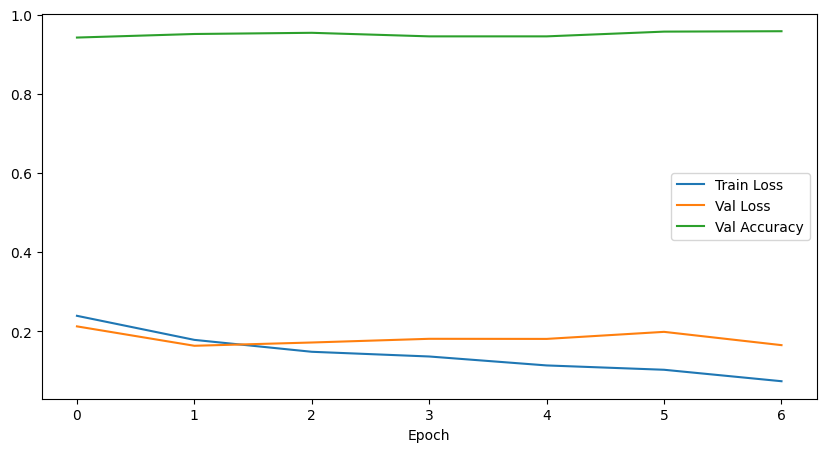

DeepNN | Data: sen_emb | Feature: en_vessel_type_fe | Size: 5000
Accuracy: 0.9510 | F1: 0.9474 | Precision: 0.9479 | Recall: 0.9510


2025-06-27 19:47:48,332 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.943
2025-06-27 19:48:03,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9434575887504436, best pos: [3.53133787e+02 1.62042985e-01 1.02641993e-03 3.18265594e+01]


Validation Loss: 0.2346, Accuracy: 0.9420
Validation Loss: 0.2397, Accuracy: 0.9380
Validation Loss: 0.2483, Accuracy: 0.9430
Validation Loss: 0.2427, Accuracy: 0.9370
Validation Loss: 0.2217, Accuracy: 0.9370
Validation Loss: 0.2328, Accuracy: 0.9450
Validation Loss: 0.3023, Accuracy: 0.8890
Validation Loss: 0.2540, Accuracy: 0.9410
Validation Loss: 0.2576, Accuracy: 0.9280
Validation Loss: 0.2644, Accuracy: 0.9370
Early stopping triggered!


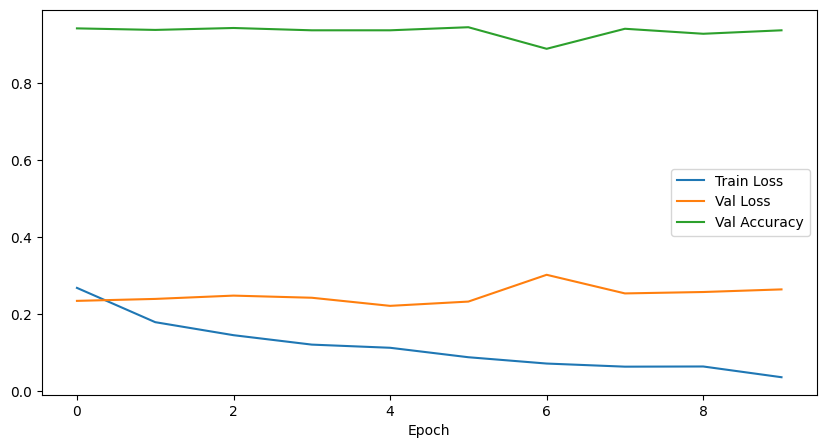

DeepNN | Data: sen_emb | Feature: en_vessel_type_rag | Size: 5000
Accuracy: 0.9370 | F1: 0.9346 | Precision: 0.9334 | Recall: 0.9370


2025-06-27 19:48:06,876 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.916
2025-06-27 19:48:20,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9161545734667175, best pos: [8.50297206e+01 1.71976467e-01 2.72700907e-03 3.77082014e+01]


Validation Loss: 0.2380, Accuracy: 0.9160
Validation Loss: 0.2471, Accuracy: 0.9180
Validation Loss: 0.2122, Accuracy: 0.9200
Validation Loss: 0.2368, Accuracy: 0.9160
Validation Loss: 0.2283, Accuracy: 0.9170
Validation Loss: 0.2235, Accuracy: 0.9190
Validation Loss: 0.2529, Accuracy: 0.9110
Validation Loss: 0.2911, Accuracy: 0.9230
Early stopping triggered!


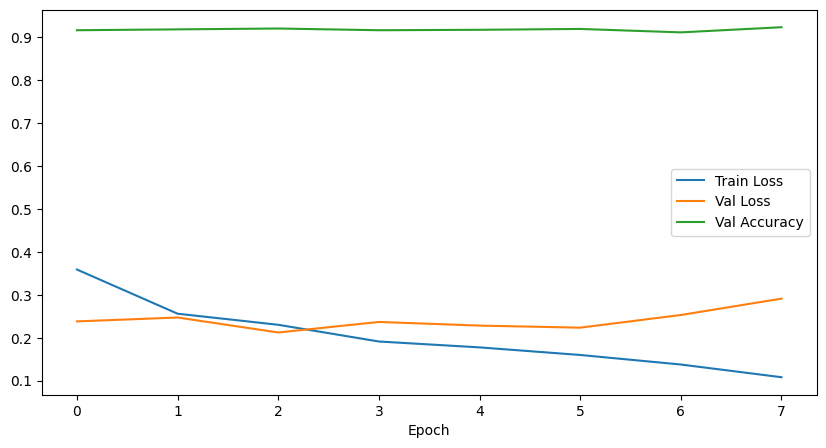

DeepNN | Data: sen_emb | Feature: en_vessel_type_idfe | Size: 5000
Accuracy: 0.9200 | F1: 0.9119 | Precision: 0.9153 | Recall: 0.9200


2025-06-27 19:48:23,158 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.917
2025-06-27 19:48:51,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9167949421378466, best pos: [2.83210522e+02 1.51096229e-01 9.16651184e-03 1.66815889e+01]


Validation Loss: 0.2828, Accuracy: 0.9180
Validation Loss: 0.2836, Accuracy: 0.9230
Validation Loss: 0.2658, Accuracy: 0.9230
Validation Loss: 0.2760, Accuracy: 0.9220
Validation Loss: 0.3112, Accuracy: 0.9240
Validation Loss: 0.3003, Accuracy: 0.9030
Validation Loss: 0.2997, Accuracy: 0.9250
Validation Loss: 0.3299, Accuracy: 0.9120
Early stopping triggered!


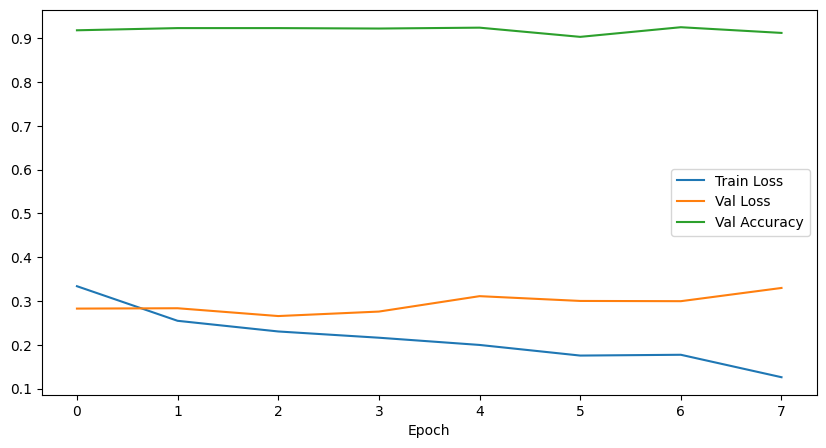

DeepNN | Data: sen_emb | Feature: en_vessel_type_idrbfe | Size: 5000
Accuracy: 0.9230 | F1: 0.9141 | Precision: 0.9174 | Recall: 0.9230


2025-06-27 19:48:55,897 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.801
2025-06-27 19:49:21,315 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8014154600888733, best pos: [8.20915616e+01 3.46174629e-01 6.65707150e-03 1.87097706e+01]


Validation Loss: 0.4858, Accuracy: 0.7780
Validation Loss: 0.4578, Accuracy: 0.7970
Validation Loss: 0.4844, Accuracy: 0.7900
Validation Loss: 0.4508, Accuracy: 0.7910
Validation Loss: 0.4701, Accuracy: 0.7730
Validation Loss: 0.4633, Accuracy: 0.7850
Validation Loss: 0.4501, Accuracy: 0.7880
Validation Loss: 0.4593, Accuracy: 0.7810
Validation Loss: 0.4390, Accuracy: 0.8060
Validation Loss: 0.4810, Accuracy: 0.7860
Validation Loss: 0.4768, Accuracy: 0.8000
Validation Loss: 0.4896, Accuracy: 0.7900
Validation Loss: 0.4885, Accuracy: 0.7780
Validation Loss: 0.5244, Accuracy: 0.7990
Early stopping triggered!


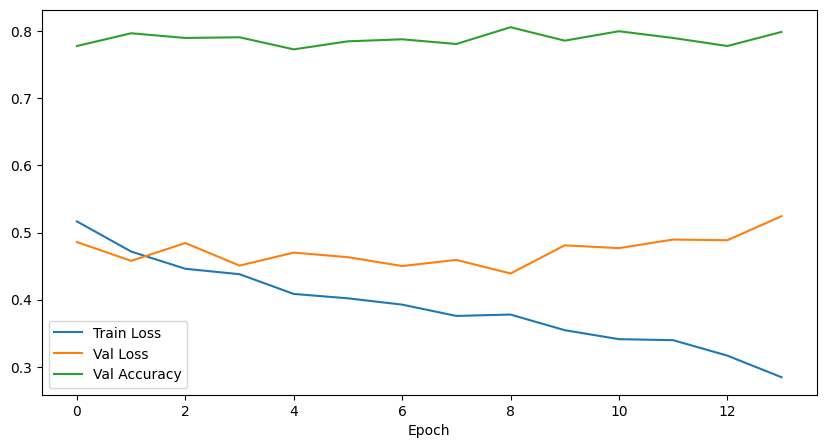

DeepNN | Data: sen_emb | Feature: en_size_of_vessel_fe | Size: 5000
Accuracy: 0.8060 | F1: 0.8002 | Precision: 0.8025 | Recall: 0.8060


2025-06-27 19:49:28,244 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.836
2025-06-27 19:49:40,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.835606444964777, best pos: [2.96033274e+02 2.06866739e-01 1.41917460e-04 5.45895300e+01]


Validation Loss: 0.3928, Accuracy: 0.8280
Validation Loss: 0.3806, Accuracy: 0.8270
Validation Loss: 0.3785, Accuracy: 0.8340
Validation Loss: 0.3752, Accuracy: 0.8330
Validation Loss: 0.3876, Accuracy: 0.8240
Validation Loss: 0.3754, Accuracy: 0.8250
Validation Loss: 0.3771, Accuracy: 0.8360
Validation Loss: 0.3837, Accuracy: 0.8410
Validation Loss: 0.3810, Accuracy: 0.8280
Early stopping triggered!


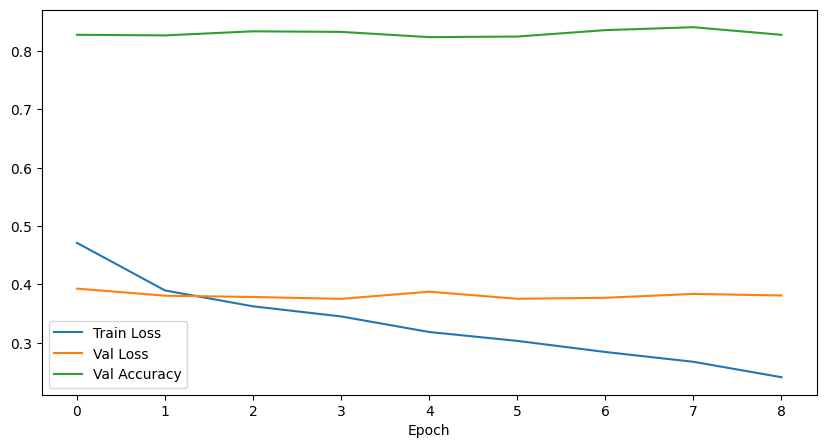

DeepNN | Data: sen_emb | Feature: en_size_of_vessel_rag | Size: 5000
Accuracy: 0.8330 | F1: 0.8290 | Precision: 0.8280 | Recall: 0.8330


2025-06-27 19:49:42,872 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.948
2025-06-27 19:50:05,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.948318219442656, best pos: [2.10920292e+02 4.42931433e-01 5.72032072e-03 2.71277674e+01]


Validation Loss: 0.2744, Accuracy: 0.9460
Validation Loss: 0.2948, Accuracy: 0.9460
Validation Loss: 0.3301, Accuracy: 0.9490
Validation Loss: 0.2833, Accuracy: 0.9480
Validation Loss: 0.3431, Accuracy: 0.9510
Validation Loss: 0.3349, Accuracy: 0.9510
Early stopping triggered!


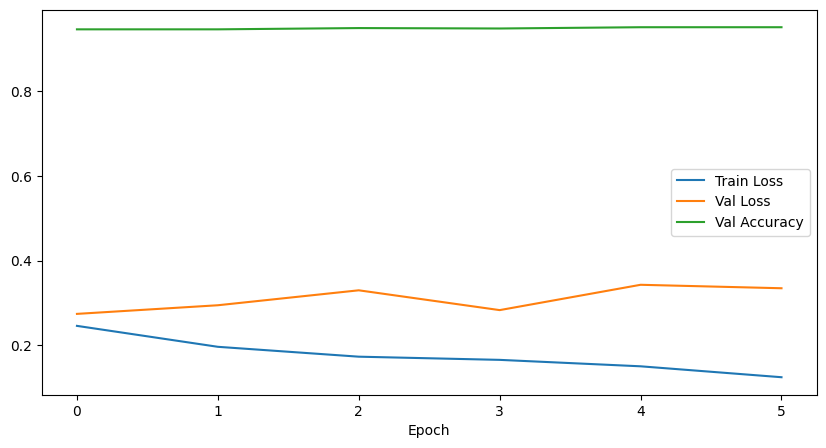

DeepNN | Data: sen_emb | Feature: en_size_of_vessel_idfe | Size: 5000
Accuracy: 0.9460 | F1: 0.9374 | Precision: 0.9466 | Recall: 0.9460


2025-06-27 19:50:07,513 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.8 
2025-06-27 19:50:47,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8003133921189193, best pos: [1.82514555e+02 1.58814504e-01 7.01876673e-04 8.34633546e+00]


Validation Loss: 0.4667, Accuracy: 0.7740
Validation Loss: 0.4507, Accuracy: 0.7900
Validation Loss: 0.4771, Accuracy: 0.7670
Validation Loss: 0.4378, Accuracy: 0.8070
Validation Loss: 0.4574, Accuracy: 0.7990
Validation Loss: 0.4732, Accuracy: 0.7800
Validation Loss: 0.4694, Accuracy: 0.7920
Validation Loss: 0.4826, Accuracy: 0.7720
Validation Loss: 0.4544, Accuracy: 0.8000
Early stopping triggered!


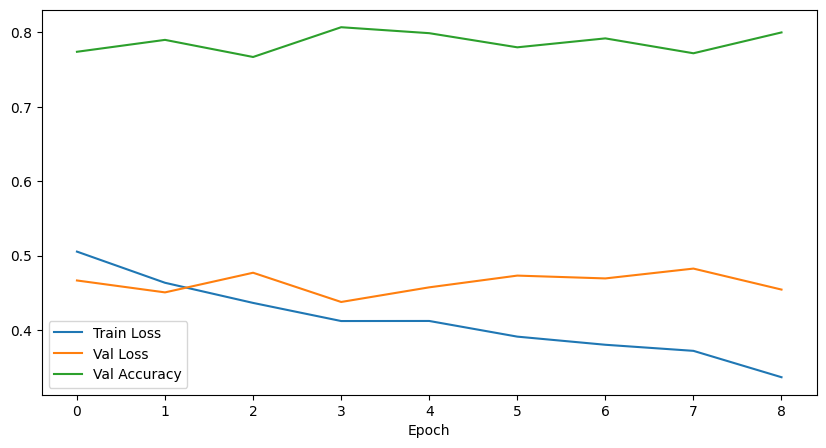

DeepNN | Data: sen_emb | Feature: en_size_of_vessel_idrbfe | Size: 5000
Accuracy: 0.8070 | F1: 0.7921 | Precision: 0.7958 | Recall: 0.8070


2025-06-27 19:50:57,226 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.826
2025-06-27 19:51:09,587 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8264659707559643, best pos: [2.32770091e+02 4.05480655e-01 1.93820090e-03 4.09152997e+01]


Validation Loss: 0.3896, Accuracy: 0.8130
Validation Loss: 0.3799, Accuracy: 0.8180
Validation Loss: 0.3886, Accuracy: 0.8310
Validation Loss: 0.3953, Accuracy: 0.8330
Validation Loss: 0.4118, Accuracy: 0.8230
Validation Loss: 0.4169, Accuracy: 0.8230
Validation Loss: 0.4269, Accuracy: 0.8310
Early stopping triggered!


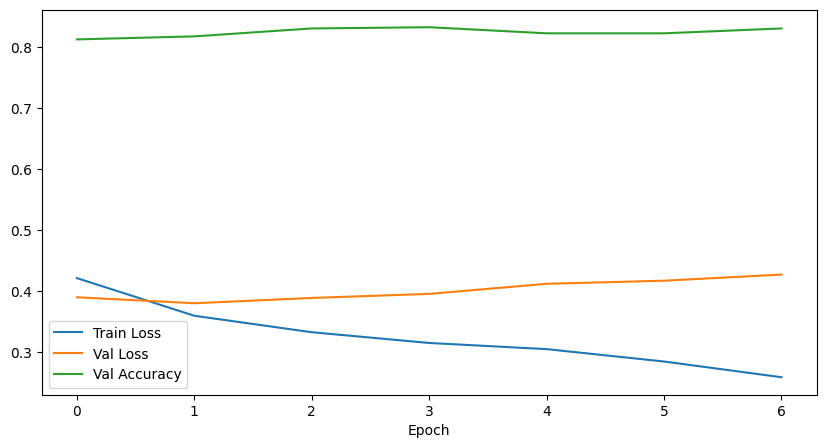

DeepNN | Data: sen_emb | Feature: en_route_fe | Size: 5000
Accuracy: 0.8180 | F1: 0.8080 | Precision: 0.8033 | Recall: 0.8180


2025-06-27 19:51:11,531 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.77
2025-06-27 19:51:24,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.770484012539185, best pos: [2.19678084e+02 3.74804218e-01 3.56063471e-03 3.76860648e+01]


Validation Loss: 0.4990, Accuracy: 0.7710
Validation Loss: 0.4599, Accuracy: 0.7810
Validation Loss: 0.4588, Accuracy: 0.7830
Validation Loss: 0.4550, Accuracy: 0.7750
Validation Loss: 0.4717, Accuracy: 0.7760
Validation Loss: 0.5170, Accuracy: 0.7460
Validation Loss: 0.4931, Accuracy: 0.7740
Validation Loss: 0.5108, Accuracy: 0.7600
Validation Loss: 0.5074, Accuracy: 0.7630
Early stopping triggered!


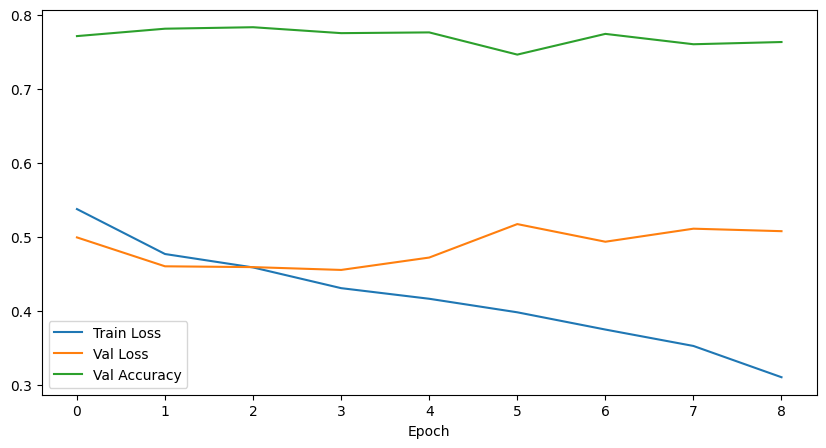

DeepNN | Data: sen_emb | Feature: en_route_rag | Size: 5000
Accuracy: 0.7750 | F1: 0.7669 | Precision: 0.7659 | Recall: 0.7750


2025-06-27 19:51:27,473 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.749
2025-06-27 19:51:44,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.74936605878249, best pos: [2.96528821e+02 2.31712268e-01 1.91389389e-03 2.95707353e+01]


Validation Loss: 0.5692, Accuracy: 0.7130
Validation Loss: 0.5163, Accuracy: 0.7350
Validation Loss: 0.5351, Accuracy: 0.7260
Validation Loss: 0.5458, Accuracy: 0.7360
Validation Loss: 0.5344, Accuracy: 0.7550
Validation Loss: 0.5634, Accuracy: 0.7340
Validation Loss: 0.5809, Accuracy: 0.7390
Early stopping triggered!


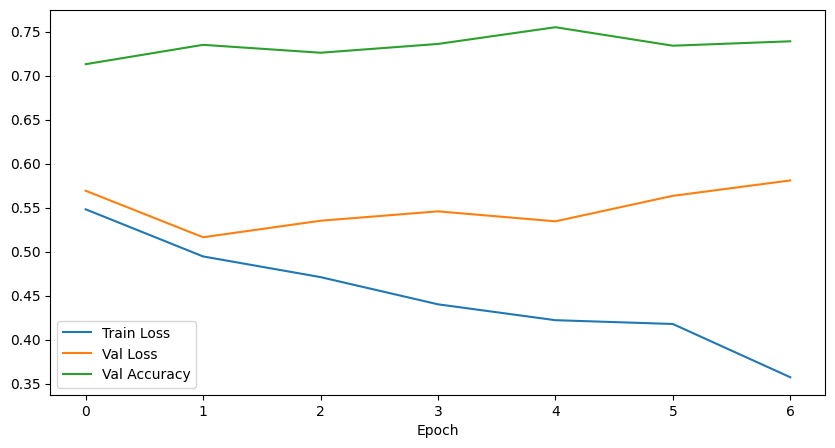

DeepNN | Data: sen_emb | Feature: en_route_idfe | Size: 5000
Accuracy: 0.7350 | F1: 0.7353 | Precision: 0.7358 | Recall: 0.7350


2025-06-27 19:51:46,593 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.697
2025-06-27 19:52:16,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6967271583946649, best pos: [1.77921411e+02 3.66087694e-01 4.40647808e-03 3.73170696e+01]


Validation Loss: 0.5862, Accuracy: 0.6720
Validation Loss: 0.6684, Accuracy: 0.6450
Validation Loss: 0.5714, Accuracy: 0.6920
Validation Loss: 0.5964, Accuracy: 0.6840
Validation Loss: 0.6118, Accuracy: 0.6880
Validation Loss: 0.6107, Accuracy: 0.6980
Validation Loss: 0.6064, Accuracy: 0.6840
Validation Loss: 0.6461, Accuracy: 0.7040
Early stopping triggered!


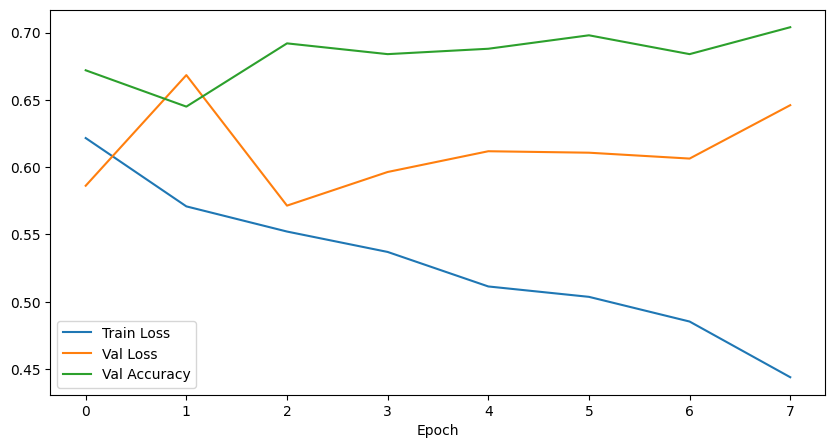

DeepNN | Data: sen_emb | Feature: en_route_idrbfe | Size: 5000
Accuracy: 0.6920 | F1: 0.6915 | Precision: 0.6913 | Recall: 0.6920


2025-06-27 19:52:18,976 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.707
2025-06-27 19:52:32,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7072170371334444, best pos: [8.28437258e+01 3.49117287e-01 3.12650181e-03 3.61012716e+01]


Validation Loss: 0.6604, Accuracy: 0.7260
Validation Loss: 0.6535, Accuracy: 0.7150
Validation Loss: 0.6674, Accuracy: 0.7340
Validation Loss: 0.6964, Accuracy: 0.7230
Validation Loss: 0.6477, Accuracy: 0.7250
Validation Loss: 0.6554, Accuracy: 0.7190
Validation Loss: 0.7520, Accuracy: 0.7220
Validation Loss: 0.7099, Accuracy: 0.7050
Validation Loss: 0.6828, Accuracy: 0.7120
Validation Loss: 0.6896, Accuracy: 0.7200
Early stopping triggered!


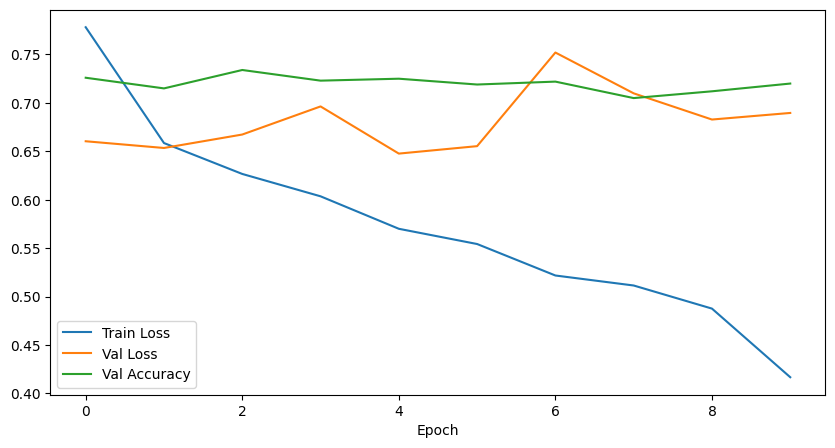

DeepNN | Data: sen_emb | Feature: en_duration_fe | Size: 5000
Accuracy: 0.7250 | F1: 0.7092 | Precision: 0.7101 | Recall: 0.7250


2025-06-27 19:52:35,274 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.712
2025-06-27 19:53:21,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7116115316540327, best pos: [1.87982620e+02 1.37937204e-01 1.24964110e-03 1.02287850e+01]


Validation Loss: 0.6918, Accuracy: 0.7110
Validation Loss: 0.6585, Accuracy: 0.7230
Validation Loss: 0.6797, Accuracy: 0.7080
Validation Loss: 0.6720, Accuracy: 0.7120
Validation Loss: 0.6908, Accuracy: 0.7010
Validation Loss: 0.6843, Accuracy: 0.7210
Validation Loss: 0.6771, Accuracy: 0.7180
Early stopping triggered!


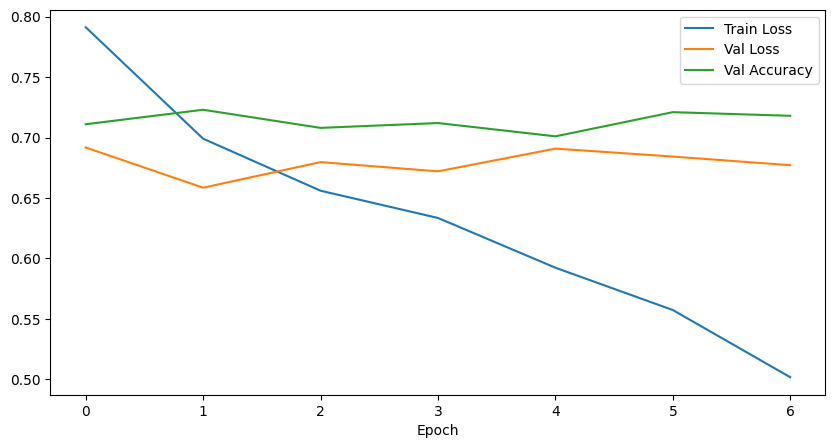

DeepNN | Data: sen_emb | Feature: en_duration_rag | Size: 5000
Accuracy: 0.7230 | F1: 0.7084 | Precision: 0.7149 | Recall: 0.7230


2025-06-27 19:53:28,237 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.662
2025-06-27 19:53:52,610 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6621200165562534, best pos: [1.01358983e+02 1.30376484e-01 3.96134066e-03 1.83750365e+01]


Validation Loss: 0.8283, Accuracy: 0.6560
Validation Loss: 0.8190, Accuracy: 0.6600
Validation Loss: 0.7896, Accuracy: 0.6560
Validation Loss: 0.8404, Accuracy: 0.6540
Validation Loss: 0.8314, Accuracy: 0.6440
Validation Loss: 0.8473, Accuracy: 0.6530
Validation Loss: 0.8675, Accuracy: 0.6560
Validation Loss: 0.8944, Accuracy: 0.6530
Early stopping triggered!


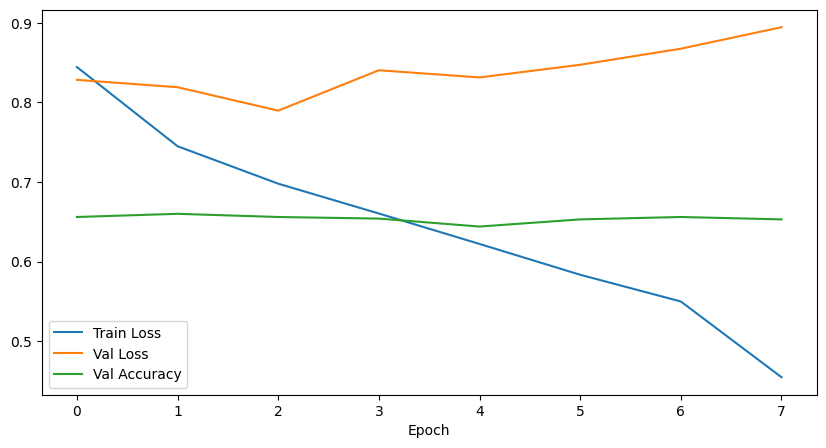

DeepNN | Data: sen_emb | Feature: en_duration_idfe | Size: 5000
Accuracy: 0.6560 | F1: 0.6406 | Precision: 0.6401 | Recall: 0.6560


2025-06-27 19:53:57,026 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.606
2025-06-27 19:54:38,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6063123805217218, best pos: [3.77243933e+02 4.96953264e-01 5.68006831e-03 1.42497795e+01]


Validation Loss: 0.9787, Accuracy: 0.6090
Validation Loss: 0.9576, Accuracy: 0.5900
Validation Loss: 0.9922, Accuracy: 0.5490
Validation Loss: 0.9546, Accuracy: 0.5630
Validation Loss: 0.9136, Accuracy: 0.6210
Validation Loss: 0.9291, Accuracy: 0.5860
Validation Loss: 0.9614, Accuracy: 0.6140
Validation Loss: 0.9107, Accuracy: 0.6110
Validation Loss: 0.9195, Accuracy: 0.6300
Validation Loss: 0.9206, Accuracy: 0.6390
Validation Loss: 0.9127, Accuracy: 0.6220
Validation Loss: 0.9086, Accuracy: 0.6040
Validation Loss: 0.9398, Accuracy: 0.6010
Validation Loss: 0.9581, Accuracy: 0.6040
Validation Loss: 0.9849, Accuracy: 0.5990
Validation Loss: 1.0856, Accuracy: 0.6230
Validation Loss: 0.9767, Accuracy: 0.6200
Early stopping triggered!


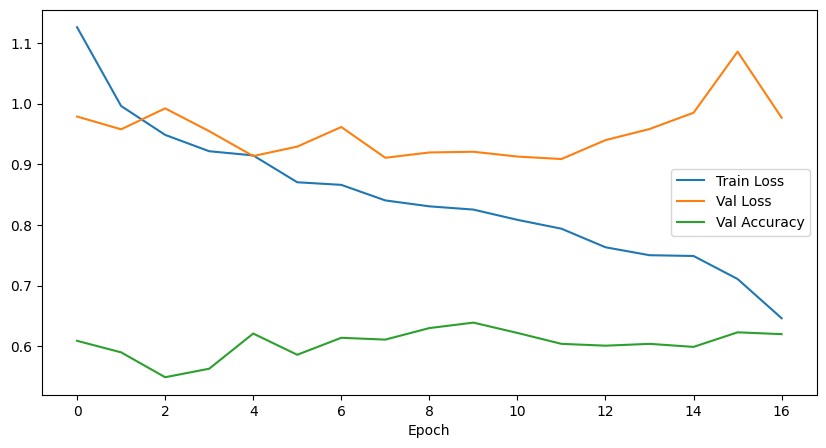

DeepNN | Data: sen_emb | Feature: en_duration_idrbfe | Size: 5000
Accuracy: 0.6040 | F1: 0.5745 | Precision: 0.5723 | Recall: 0.6040


2025-06-27 19:54:50,393 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.675
2025-06-27 19:55:33,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6753153617373245, best pos: [1.88281241e+02 2.46150090e-01 3.22857506e-03 6.73916748e+00]


Validation Loss: 0.7345, Accuracy: 0.6450
Validation Loss: 0.7354, Accuracy: 0.6440
Validation Loss: 0.7010, Accuracy: 0.6760
Validation Loss: 0.7120, Accuracy: 0.6610
Validation Loss: 0.6953, Accuracy: 0.6720
Validation Loss: 0.6911, Accuracy: 0.6760
Validation Loss: 0.6808, Accuracy: 0.6740
Validation Loss: 0.7028, Accuracy: 0.6770
Validation Loss: 0.7037, Accuracy: 0.6590
Validation Loss: 0.7048, Accuracy: 0.6700
Validation Loss: 0.7151, Accuracy: 0.6860
Validation Loss: 0.7064, Accuracy: 0.6820
Early stopping triggered!


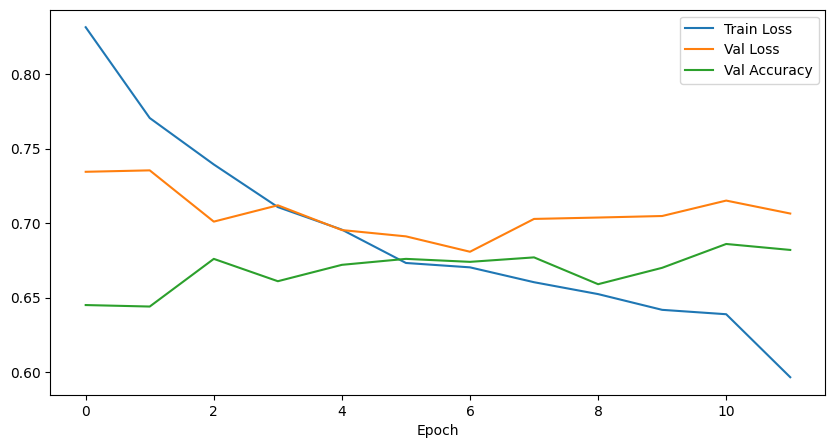

DeepNN | Data: sen_emb | Feature: en_impact_fe | Size: 5000

2025-06-27 19:55:52,063 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}



Accuracy: 0.6740 | F1: 0.6726 | Precision: 0.6736 | Recall: 0.6740


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.671
2025-06-27 19:56:22,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6709514740135355, best pos: [3.45718172e+02 1.07549381e-01 1.00463491e-03 2.57365524e+01]


Validation Loss: 0.7492, Accuracy: 0.6540
Validation Loss: 0.7373, Accuracy: 0.6720
Validation Loss: 0.7201, Accuracy: 0.6910
Validation Loss: 0.8076, Accuracy: 0.6580
Validation Loss: 0.7568, Accuracy: 0.6690
Validation Loss: 0.7963, Accuracy: 0.6780
Validation Loss: 0.9210, Accuracy: 0.6190
Validation Loss: 0.9186, Accuracy: 0.6450
Early stopping triggered!


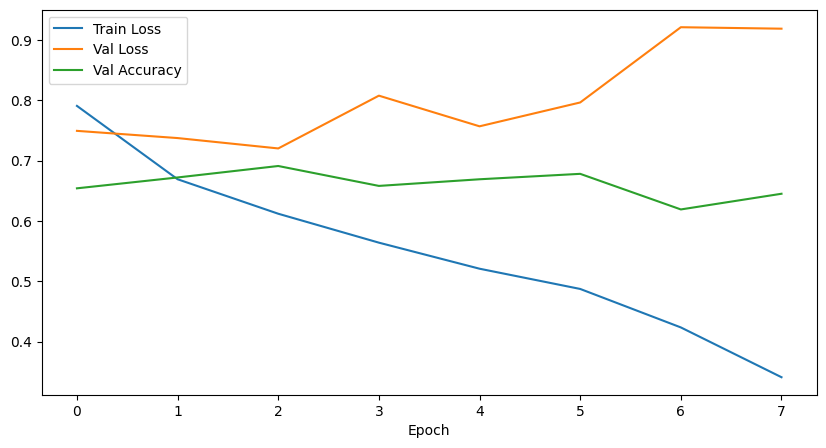

DeepNN | Data: sen_emb | Feature: en_impact_rag | Size: 5000
Accuracy: 0.6910 | F1: 0.6873 | Precision: 0.6869 | Recall: 0.6910


2025-06-27 19:56:25,466 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.801
2025-06-27 19:56:45,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.800544344637287, best pos: [1.78406861e+02 2.09925164e-01 7.20615608e-03 2.58820472e+01]


Validation Loss: 0.5300, Accuracy: 0.7760
Validation Loss: 0.5063, Accuracy: 0.7990
Validation Loss: 0.4811, Accuracy: 0.8070
Validation Loss: 0.5118, Accuracy: 0.7830
Validation Loss: 0.5509, Accuracy: 0.8090
Validation Loss: 0.5495, Accuracy: 0.7790
Validation Loss: 0.5606, Accuracy: 0.7880
Validation Loss: 0.5835, Accuracy: 0.7950
Early stopping triggered!


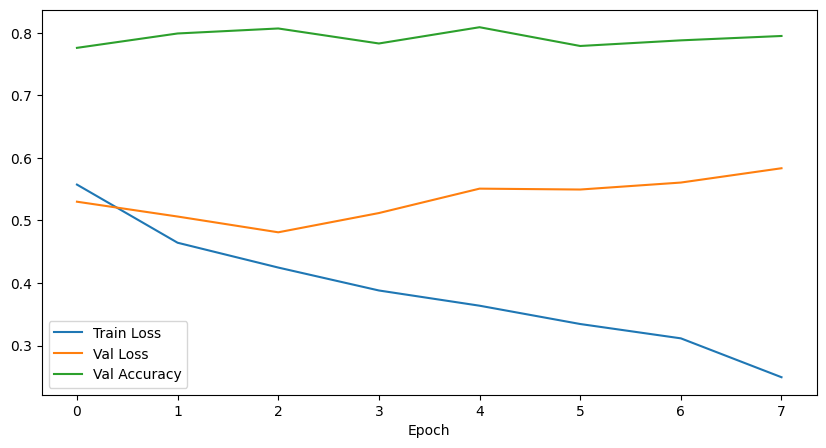

DeepNN | Data: sen_emb | Feature: en_impact_idfe | Size: 5000
Accuracy: 0.8070 | F1: 0.7855 | Precision: 0.7925 | Recall: 0.8070


2025-06-27 19:56:48,634 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.692
2025-06-27 19:57:19,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6916275415336108, best pos: [3.71501529e+02 2.59266331e-01 9.52341394e-04 1.44030487e+01]


Validation Loss: 0.7015, Accuracy: 0.7050
Validation Loss: 0.6654, Accuracy: 0.7110
Validation Loss: 0.6755, Accuracy: 0.6870
Validation Loss: 0.6525, Accuracy: 0.7040
Validation Loss: 0.6864, Accuracy: 0.7200
Validation Loss: 0.6733, Accuracy: 0.7070
Validation Loss: 0.6999, Accuracy: 0.6920
Validation Loss: 0.7476, Accuracy: 0.7020
Validation Loss: 0.7414, Accuracy: 0.6990
Early stopping triggered!


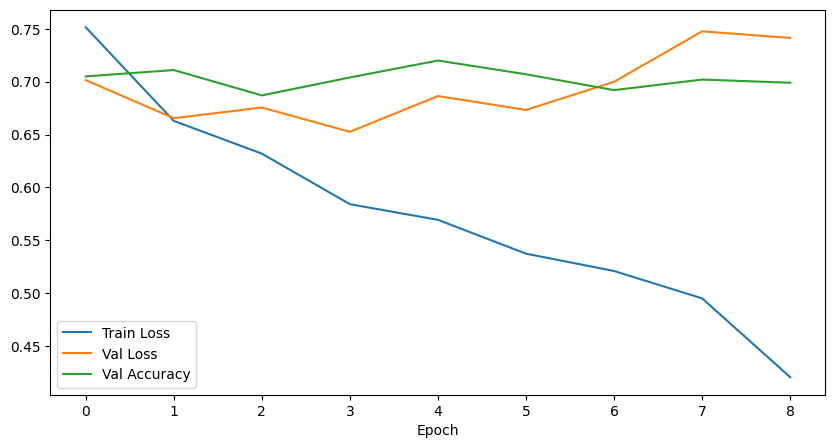

DeepNN | Data: sen_emb | Feature: en_impact_idrbfe | Size: 5000
Accuracy: 0.7040 | F1: 0.6856 | Precision: 0.6795 | Recall: 0.7040


2025-06-27 19:57:25,852 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.674
2025-06-27 19:57:37,969 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6740835523994917, best pos: [1.88205084e+02 2.02455493e-01 1.77202189e-03 6.23832562e+01]


Validation Loss: 0.8038, Accuracy: 0.6630
Validation Loss: 0.8205, Accuracy: 0.6460
Validation Loss: 0.8795, Accuracy: 0.6370
Validation Loss: 0.8499, Accuracy: 0.6540
Validation Loss: 0.8176, Accuracy: 0.6720
Validation Loss: 0.7905, Accuracy: 0.6860
Validation Loss: 0.8332, Accuracy: 0.6680
Validation Loss: 0.8296, Accuracy: 0.6760
Validation Loss: 0.8623, Accuracy: 0.6670
Validation Loss: 1.0961, Accuracy: 0.6630
Validation Loss: 0.8737, Accuracy: 0.6850
Early stopping triggered!


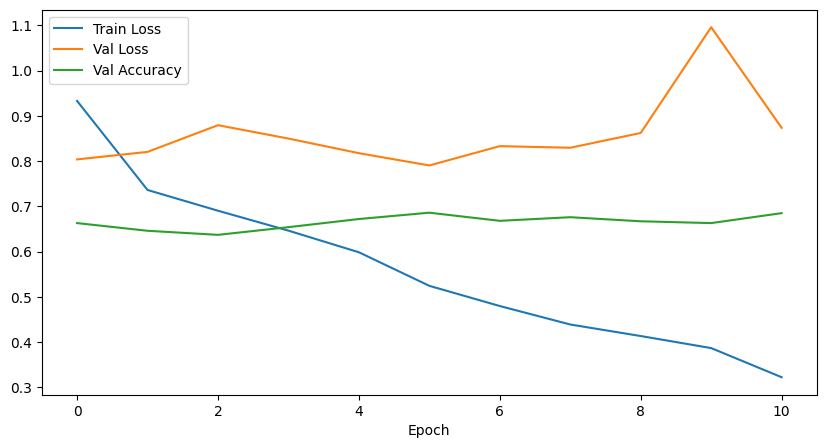

DeepNN | Data: sen_emb | Feature: en_impact_size_fe | Size: 5000
Accuracy: 0.6860 | F1: 0.6753 | Precision: 0.6757 | Recall: 0.6860


2025-06-27 19:57:40,206 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.608
2025-06-27 19:57:57,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6082579317528027, best pos: [3.47308199e+02 4.32394194e-01 6.01201240e-04 5.22369953e+01]


Validation Loss: 0.9737, Accuracy: 0.5970
Validation Loss: 0.9321, Accuracy: 0.6270
Validation Loss: 0.9473, Accuracy: 0.6240
Validation Loss: 0.9286, Accuracy: 0.6350
Validation Loss: 0.9340, Accuracy: 0.6310
Validation Loss: 0.9410, Accuracy: 0.6210
Validation Loss: 0.9625, Accuracy: 0.6260
Validation Loss: 1.0078, Accuracy: 0.6220
Validation Loss: 0.9563, Accuracy: 0.6350
Early stopping triggered!


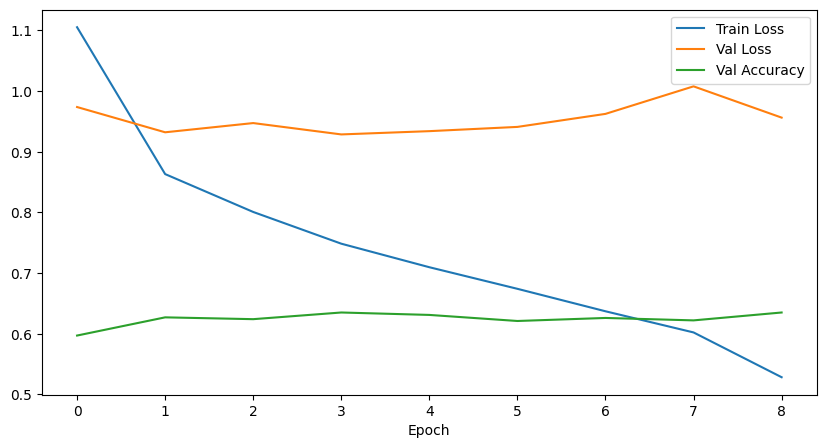

DeepNN | Data: sen_emb | Feature: en_impact_size_rag | Size: 5000
Accuracy: 0.6350 | F1: 0.6125 | Precision: 0.6046 | Recall: 0.6350


2025-06-27 19:57:59,906 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.663
2025-06-27 19:58:10,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6632883220262398, best pos: [2.17685292e+02 4.04838459e-01 1.10435388e-03 5.41830288e+01]


Validation Loss: 0.7956, Accuracy: 0.6460
Validation Loss: 0.7912, Accuracy: 0.6620
Validation Loss: 0.7654, Accuracy: 0.6760
Validation Loss: 0.7606, Accuracy: 0.6760
Validation Loss: 0.7861, Accuracy: 0.6800
Validation Loss: 0.8152, Accuracy: 0.6800
Validation Loss: 0.8247, Accuracy: 0.6800
Validation Loss: 0.8315, Accuracy: 0.6800
Validation Loss: 0.8039, Accuracy: 0.6650
Early stopping triggered!


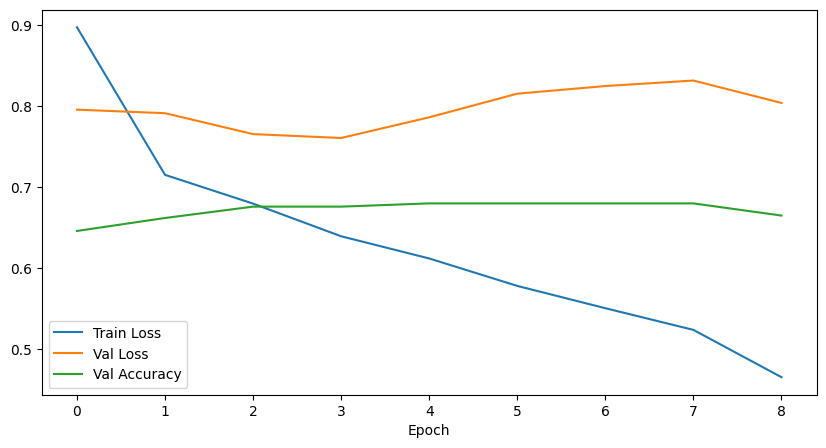

DeepNN | Data: sen_emb | Feature: en_impact_size_idfe | Size: 5000
Accuracy: 0.6760 | F1: 0.6660 | Precision: 0.6597 | Recall: 0.6760


2025-06-27 19:58:12,812 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.629
2025-06-27 19:58:36,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.6291206417475743, best pos: [3.78269016e+02 1.81785284e-01 3.34863256e-03 2.08170094e+01]


Validation Loss: 0.9657, Accuracy: 0.6200
Validation Loss: 0.9282, Accuracy: 0.5730
Validation Loss: 0.8629, Accuracy: 0.6460
Validation Loss: 0.9536, Accuracy: 0.5660
Validation Loss: 0.8852, Accuracy: 0.6500
Validation Loss: 0.9474, Accuracy: 0.5880
Validation Loss: 0.9312, Accuracy: 0.6360
Validation Loss: 0.9272, Accuracy: 0.6490
Early stopping triggered!


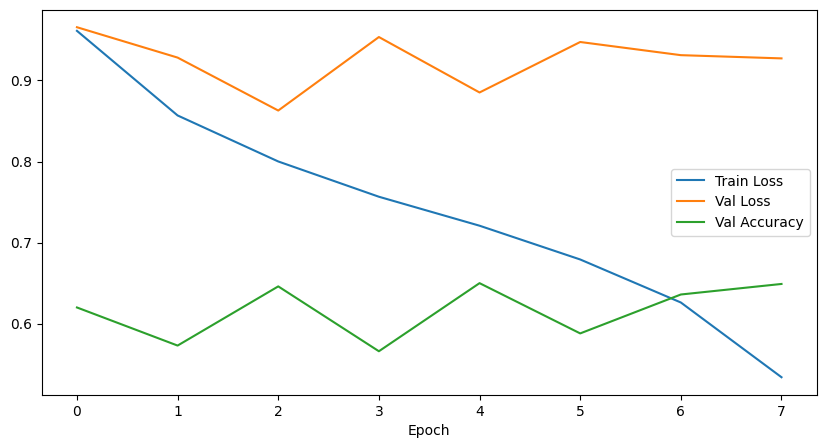

DeepNN | Data: sen_emb | Feature: en_impact_size_idrbfe | Size: 5000
Accuracy: 0.6460 | F1: 0.6186 | Precision: 0.6131 | Recall: 0.6460


In [9]:
results = []
for emb in ['sen_emb']:#, 'sen_emb_mean', 'sen_emb_max',
    #    'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
    #    'full_emb']:
    
      for feature in ['en_scale_fe', 'en_scale_rag', 'en_scale_idfe', 'en_scale_idrbfe',
       'en_vessel_type_fe', 'en_vessel_type_rag', 'en_vessel_type_idfe',
       'en_vessel_type_idrbfe', 'en_size_of_vessel_fe',
       'en_size_of_vessel_rag', 'en_size_of_vessel_idfe',
       'en_size_of_vessel_idrbfe', 'en_route_fe', 'en_route_rag',
       'en_route_idfe', 'en_route_idrbfe', 'en_duration_fe', 'en_duration_rag',
       'en_duration_idfe', 'en_duration_idrbfe', 'en_impact_fe',
       'en_impact_rag', 'en_impact_idfe', 'en_impact_idrbfe',
       'en_impact_size_fe', 'en_impact_size_rag', 'en_impact_size_idfe',
       'en_impact_size_idrbfe']:
            for size in [5000]:

                X = df[:size][emb].values
                y = sample[:size][feature].values
                stratify_y = sample[:size][feature].values  # Use only the first `size` elements

                X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=stratify_y
                )

                if emb == 'sen_emb':
                    X_train = np.array([np.array(x) for x in X_train])
                    X_test = np.array([np.array(x) for x in X_test])
                else:
                    X_train = np.array([np.mean(np.array(x), axis=0) for x in X_train])
                    X_test = np.array([np.mean(np.array(x), axis=0) for x in X_test])
                # If the result is 1D, reshape to 2D
                    if X_train.ndim == 1:
                            X_train = X_train.reshape(-1, 1)
                            X_test = X_test.reshape(-1, 1)


                train_y_mapped = np.array(y_train, dtype = np.int64)
                test_y_mapped = np.array(y_test, dtype = np.int64)

                unique_labels = np.unique(train_y_mapped)
                label2idx = {label: idx for idx, label in enumerate(unique_labels)}

                train_y_mapped = np.array([label2idx[y] for y in train_y_mapped])
                test_y_mapped = np.array([label2idx[y] for y in test_y_mapped])


                input_dim = X_train.shape[1]
                NUM_LABELS = len(np.unique(train_y_mapped))
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

                # --- PSO optimization for hyperparameters ---
                best_hyperparams = run_pso(X_train, train_y_mapped, X_test, test_y_mapped, input_dim, NUM_LABELS, device)
                hidden_dim, dropout, lr, batch_size = int(best_hyperparams[0]), float(best_hyperparams[1]), float(best_hyperparams[2]), int(best_hyperparams[3])

                # Build model with best hyperparameters
                model = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, NUM_LABELS)
                ).to(device)
                optimizer = AdamW(model.parameters(), lr=lr)
                loss_fn = nn.CrossEntropyLoss()

                train_dataset = EmbeddingDataset(X_train, train_y_mapped)
                val_dataset = EmbeddingDataset(X_test, test_y_mapped)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False)

                # Train final model
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
                train(model, train_loader, val_loader, optimizer, scheduler, num_epochs=25, patience=5)
                model.eval()
                correct = 0
                total = 0
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(device)
                        labels = batch['labels'].to(device)
                        logits = model(input_ids)
                        preds = torch.argmax(logits, dim=-1)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())
                        correct += (preds == labels).sum().item()
                        total += labels.size(0)
                acc = correct / total
                f1 = f1_score(all_labels, all_preds, average='weighted')
                precision = precision_score(all_labels, all_preds, average='weighted')
                recall = recall_score(all_labels, all_preds, average='weighted')
                results.append((emb, feature, "DeepNN", False, size, acc, f1, precision, recall))
                print(f"DeepNN | Data: {emb} | Feature: {feature} | Size: {size}")
                print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
                print("="*50)

# After all runs
results_df = pd.DataFrame(results, columns=['Data', 'Feature', 'Model', 'Optimized', 'Size', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = results_df.sort_values(by='F1 Score', ascending=False)
results_df.to_csv('deepnn_results.csv', index=False)

In [11]:
print("Unique train labels:", np.unique(train_y_mapped))
print("Unique test labels:", np.unique(test_y_mapped))
print("NUM_LABELS:", NUM_LABELS)

Unique train labels: [  0  30  90 365]
Unique test labels: [  0  30  90 365]
NUM_LABELS: 4


# DNN Classification Results

Text(0.5, 1.0, 'Accuracy by Model and Data Type')

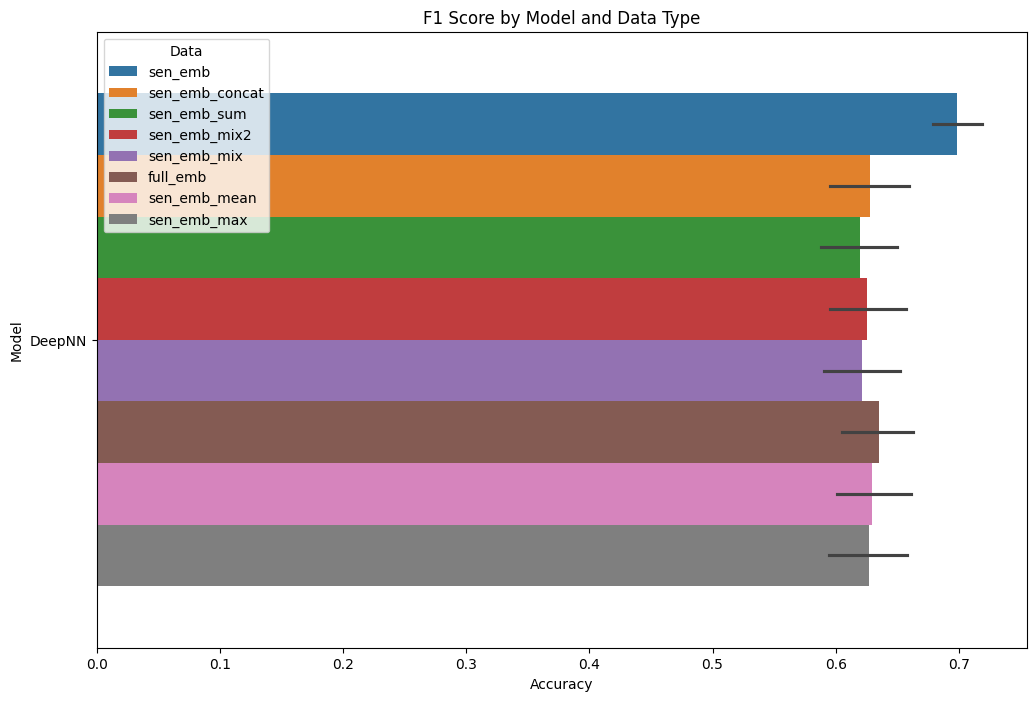

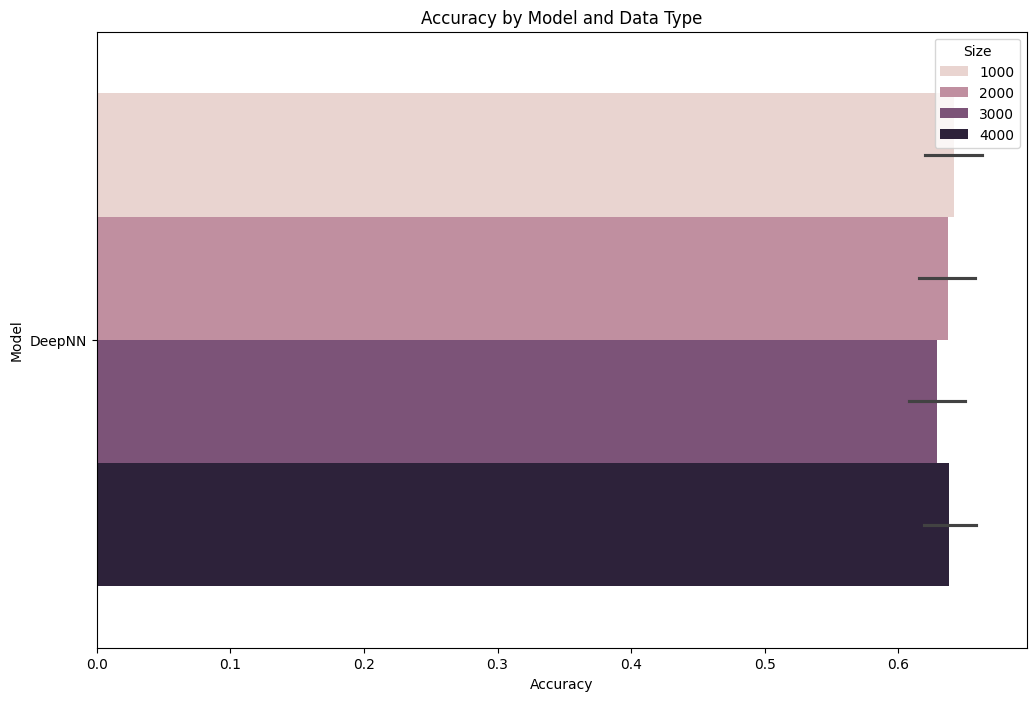

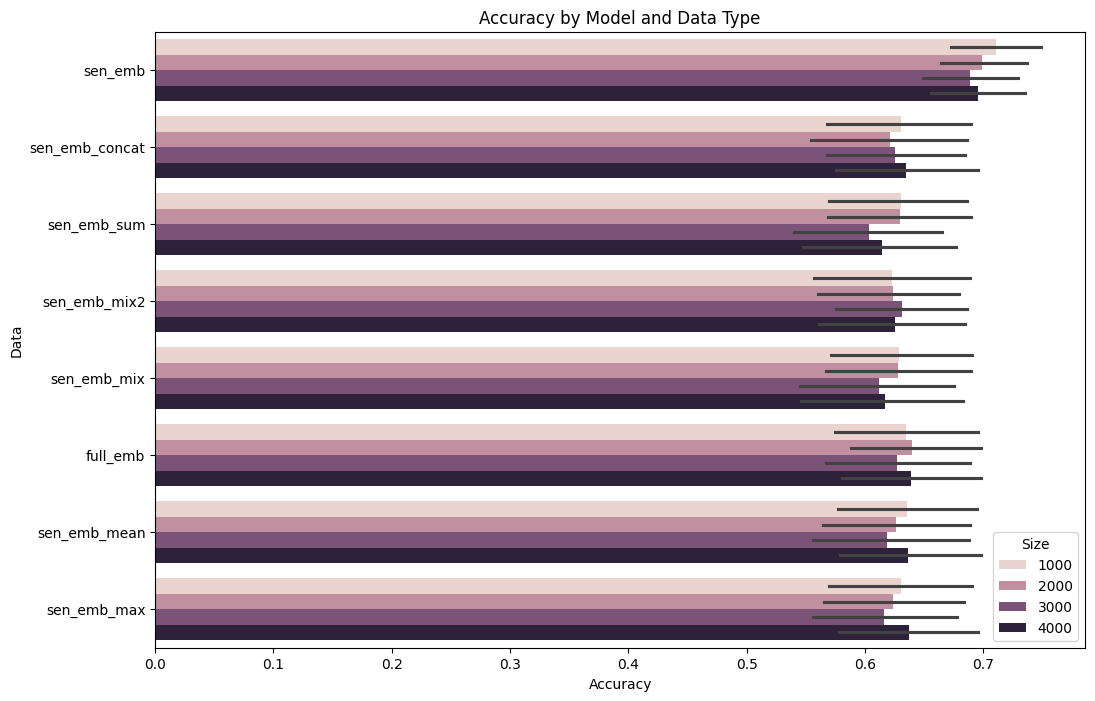

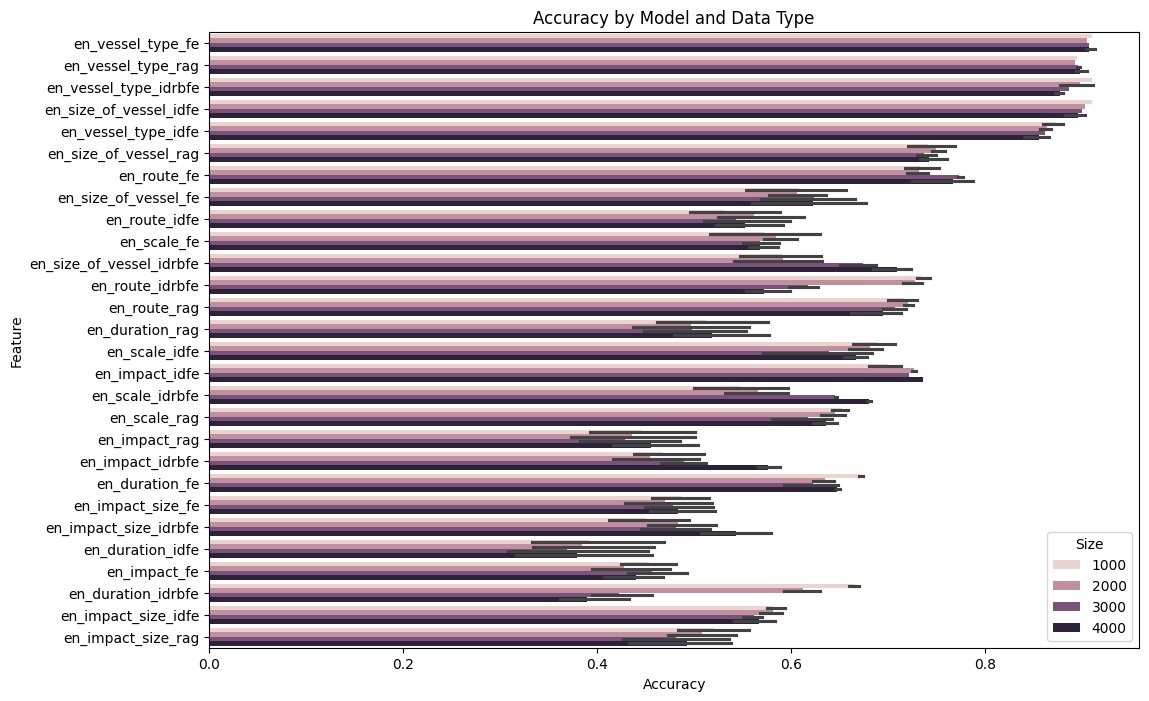

In [ ]:
# plot for data type 
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='Data')
plt.title('F1 Score by Model and Data Type')
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='Size')
plt.title('Accuracy by Model and Data Type')
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Data', hue='Size')
plt.title('Accuracy by Model and Data Type')
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Accuracy', y='Feature', hue='Size')
plt.title('Accuracy by Model and Data Type')

In [14]:
dnn_results_df = pd.read_csv('deepnn_results.csv')

Text(0.5, 1.0, 'F1 Score by Model and Feature')

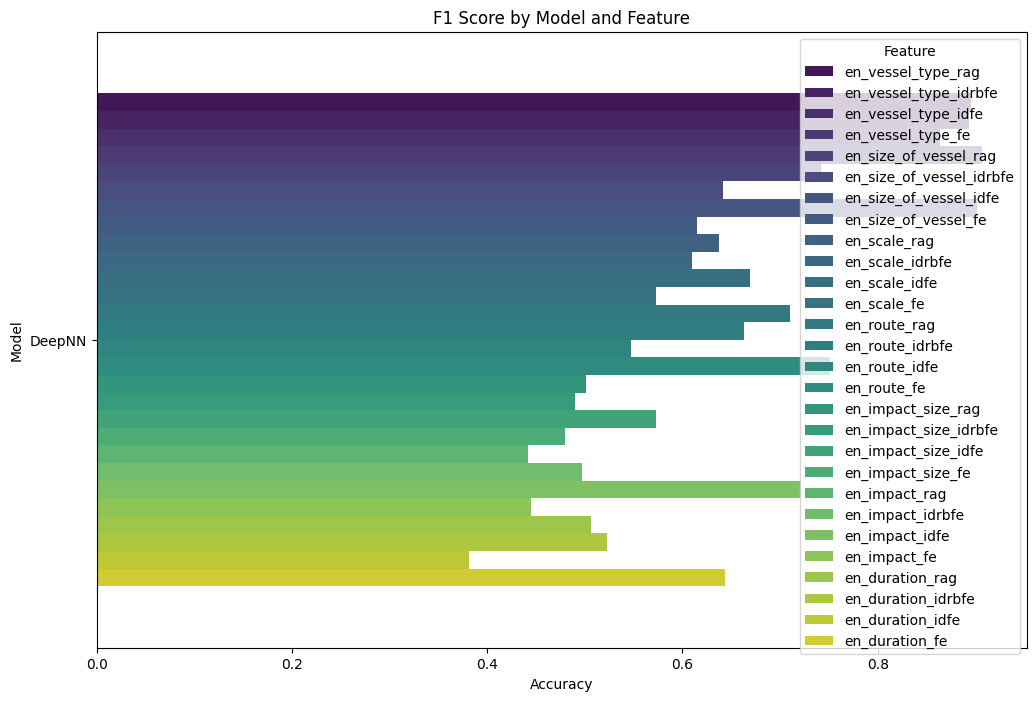

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(data=dnn_results_df.sort_values(by = 'Feature', ascending = False), x='Accuracy', y='Model', hue='Feature', ci=None, palette='viridis')

plt.title('F1 Score by Model and Feature')

Text(0.5, 1.0, 'F1 Score by Model and Feature')

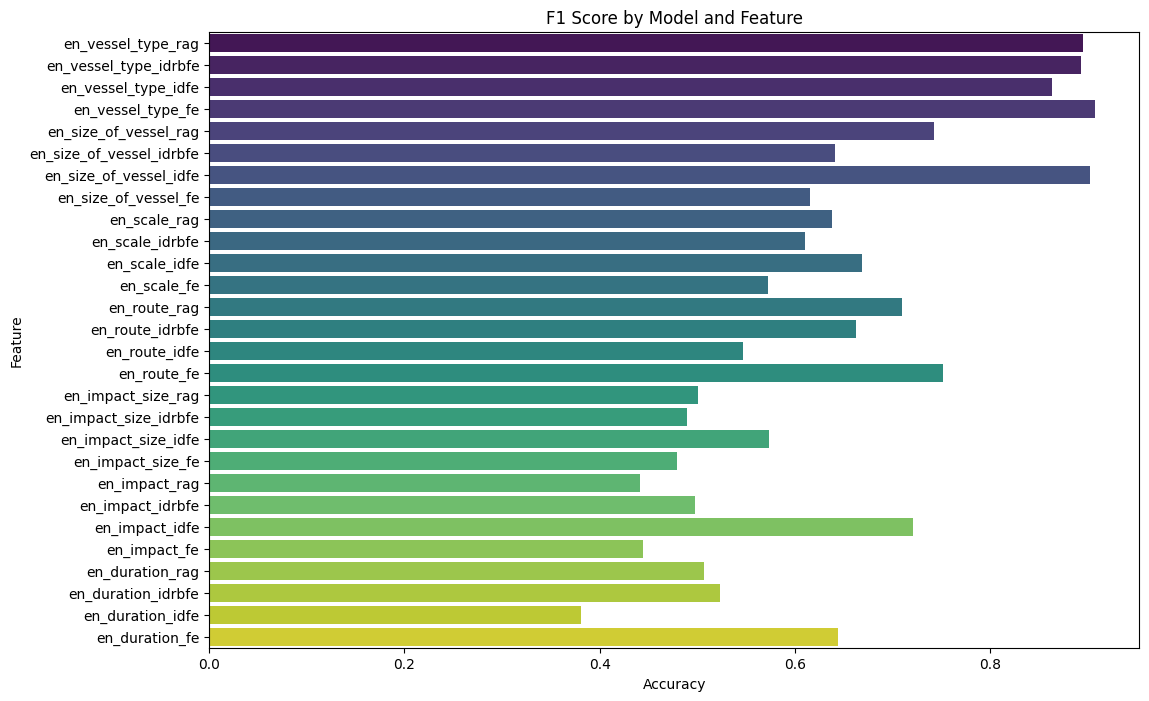

In [26]:
plt.figure(figsize=(12, 8))
sns.barplot(data=dnn_results_df.sort_values(by = 'Feature', ascending = False), x='Accuracy', y='Feature', ci=None, palette='viridis')

plt.title('F1 Score by Model and Feature')

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cpu")
model = model.to(device)

# Results Compare - DNN 

In [10]:
dnn_results_df = pd.read_csv('deepnn_results.csv')
dnn_results_df_def = pd.read_csv('deepnn_results - Copy.csv')

In [12]:
dnn_results_df['Optimized'] = True

In [13]:
dnn_results_df.head()

Data                 Feature   Model  Optimized  Size  Accuracy  \
0  sen_emb       en_vessel_type_fe  DeepNN       True  5000     0.951   
1  sen_emb  en_size_of_vessel_idfe  DeepNN       True  5000     0.946   
2  sen_emb      en_vessel_type_rag  DeepNN       True  5000     0.937   
3  sen_emb   en_vessel_type_idrbfe  DeepNN       True  5000     0.923   
4  sen_emb     en_vessel_type_idfe  DeepNN       True  5000     0.920   

   F1 Score  Precision  Recall  
0  0.947447   0.947921   0.951  
1  0.937352   0.946601   0.946  
2  0.934551   0.933353   0.937  
3  0.914122   0.917439   0.923  
4  0.911885   0.915290   0.920

In [14]:
dnn_results_df = pd.concat([dnn_results_df, dnn_results_df_def], axis=0)

Text(0.5, 1.0, 'F1 Score by Model and Feature')

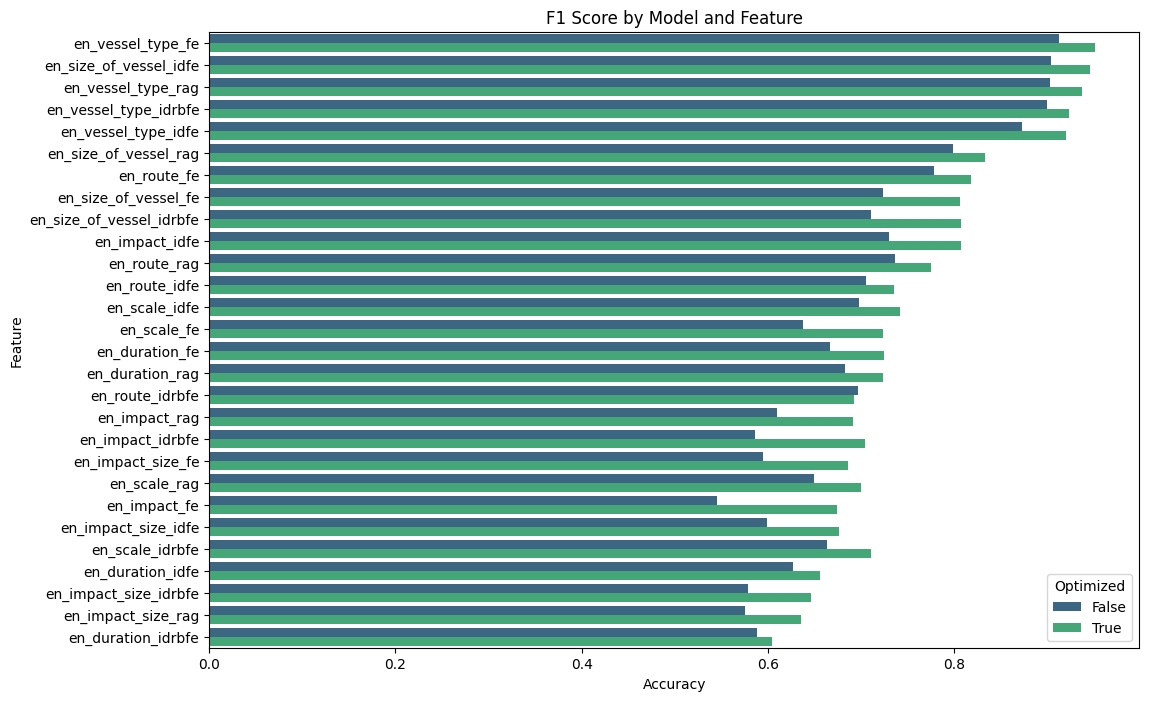

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(data=dnn_results_df[(dnn_results_df['Data'] == 'sen_emb')], x='Accuracy', y='Feature', hue = 'Optimized', ci=None, palette='viridis')
plt.title('F1 Score by Model and Feature')

# XAI classification

In [6]:
models = [logreg, svc, rf, dt, knn, vt, bag, hist_grb, stack, ada, extra_trees]
models_dict = {model.__class__.__name__: model for model in models}

# Example parameter grids for your models (for use with GridSearchCV)
param_grids = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNeighborsClassifier': {
        'n_neighbors': list(range(1, 21)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'VotingClassifier': {
        'voting': ['soft', 'hard'],
        # 'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1]]  # Example weights
    },
    'BaggingClassifier': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0]
    },
    'HistGradientBoostingClassifier': {
        'max_iter': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    },
    'StackingClassifier': {
        'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'cv': [3, 5]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'ExtraTreesClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [82]:
from transformers import pipeline
import shap
from lime.lime_text import LimeTextExplainer

results_df = pd.read_csv('results.csv')
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)   
max_length = 512

def get_article_embeddings_sentence(article, tokenizer, model, device, max_length=512):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article)
    sent_embeddings = []
    for sent in sentences: 
        # Tokenize and encode each sentence
        tokens = tokenizer(
            sent,
            padding='max_length',
            # truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad(): # Disable gradient calculation
            outputs = model(
                input_ids=tokens['input_ids'],
                attention_mask=tokens['attention_mask']
            )
            # Get [CLS] embedding
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
            sent_embeddings.append(cls_emb)
    return sent_embeddings

def predict_proba(texts, tokenizer, model, device, max_length=512):
    model.eval()
    all_embeddings = []
    for article in texts:
        # Get sentence embeddings for each article
        sent_embs = get_article_embeddings_sentence(article, tokenizer, model, device, max_length)
        # Aggregate: mean pooling over sentences (shape: (num_sentences, emb_dim) -> (emb_dim,))
        article_emb = np.concatenate(sent_embs, axis=0)
        all_embeddings.append(article_emb)
    X = np.stack(all_embeddings)
    # If your classifier is sklearn-like and expects 2D array:
    return model.predict_proba(X) 

for feature in results_df['Feature'].unique()[16:]:
    best_model_row = results_df[results_df['Feature'] == feature].sort_values(by='Accuracy', ascending=False).iloc[0]
    model_name = best_model_row['Model']
    emb = best_model_row['Data']
    model = models_dict[model_name]
    break



import shap
from lime.lime_text import LimeTextExplainer

texts = df['bart_summ'][:5000].tolist()  # Use the first 5000 texts for explanation
X_train, X_test, y_train, y_test = train_test_split(texts, sample[feature], test_size=0.2, random_state=42, stratify=sample[feature])

def safe_article_embedding(article, tokenizer, model, device):
    sent_embs = get_article_embeddings_sentence(article, tokenizer, model, device)
    if len(sent_embs) == 0:
        # Return a zero vector of the correct size (e.g., 768 for BERT)
        return np.zeros(768)
    else:
        return np.mean(np.stack(sent_embs), axis=0)

# X_train_emb = np.stack([
#     safe_article_embedding(article, tokenizer, bert_model, device)
#     for article in X_train
# ])
model.fit(X_train_emb, y_train)

# X_test_emb = np.stack([
#     safe_article_embedding(article, tokenizer, bert_model, device)
#     for article in X_test
# ])
y_pred = model.predict(X_test_emb)

# 2. Find one true positive and one false positive (or true/false for any class)
true_idx = np.where(y_pred == y_test)[0][0]    # first correct prediction
false_idx = np.where(y_pred != y_test)[0][0]   # first incorrect prediction

# 3. Get the corresponding text samples
true_text = df.iloc[true_idx]['bart_summ']
false_text = df.iloc[false_idx]['bart_summ']

# 4. SHAP explanation
# explainer = shap.Explainer(lambda x: model.predict_proba(tokenizer.transform(x)), masker=shap.maskers.Text(tokenizer=str.split))
# shap_values_true = explainer([true_text])
# shap_values_false = explainer([false_text])

# shap.plots.text(shap_values_true[0])
# shap.plots.text(shap_values_false[0])

# 5. LIME explanation
def get_embeddings(texts):
    # If your model expects mean-pooled BERT embeddings:
    embs = []
    for t in texts:
        # get_article_embeddings_sentence returns a list of sentence embeddings
        sent_embs = get_article_embeddings_sentence(t, tokenizer, bert_model, device)
        if len(sent_embs) == 0:
            embs.append(np.zeros(768))
        else:
            embs.append(np.mean(np.stack(sent_embs), axis=0))
    return np.stack(embs)

# Now use this in your LIME/SHAP lambda:
explainer_lime = LimeTextExplainer(class_names=model.classes_)
lime_exp_true = explainer_lime.explain_instance(
    true_text,
    lambda x: model.predict_proba(get_embeddings(x)),
    num_features=10
)
lime_exp_false = explainer_lime.explain_instance(
    false_text,
    lambda x: model.predict_proba(get_embeddings(x)),
    num_features=10
)

lime_exp_true.show_in_notebook()
lime_exp_false.show_in_notebook()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tzora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
feature

'en_route_idfe'

In [20]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

# Results Comprare - DNN CLASSIC ML

In [16]:
dnn_results_df = pd.read_csv('deepnn_results.csv')

In [21]:
results_df = pd.read_csv('results.csv')

In [22]:
dnn_results_df.head()

Data                 Feature   Model  Optimized  Size  Accuracy  \
0  sen_emb       en_vessel_type_fe  DeepNN       True  5000     0.951   
1  sen_emb  en_size_of_vessel_idfe  DeepNN       True  5000     0.946   
2  sen_emb      en_vessel_type_rag  DeepNN       True  5000     0.937   
3  sen_emb   en_vessel_type_idrbfe  DeepNN       True  5000     0.923   
4  sen_emb     en_vessel_type_idfe  DeepNN       True  5000     0.920   

   F1 Score  Precision  Recall  
0  0.947447   0.947921   0.951  
1  0.937352   0.946601   0.946  
2  0.934551   0.933353   0.937  
3  0.914122   0.917439   0.923  
4  0.911885   0.915290   0.920

In [23]:
dnn_results_df = pd.concat([results_df[(results_df['Optimized'] == True)], dnn_results_df[(dnn_results_df['Optimized'] == True)]], axis=0)

Text(0.5, 1.0, 'F1 Score by Model and Feature')

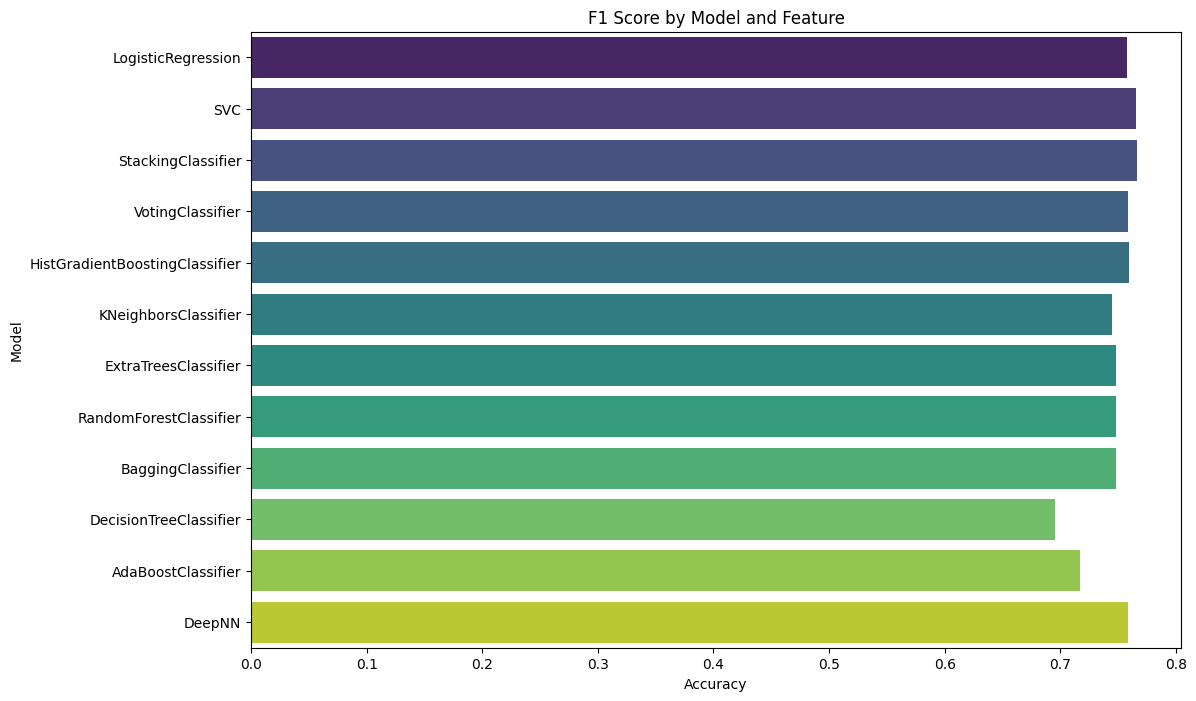

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(data=dnn_results_df[(dnn_results_df['Data'] == 'sen_emb')], x='Accuracy', y='Model', ci=None, palette='viridis')
plt.title('F1 Score by Model and Feature')

# Feature Creation

In [9]:
results_df = pd.read_csv('results.csv')

In [26]:
results_df.head()

Data            Feature               Model  Optimized  Size  Accuracy  \
0  sen_emb  en_vessel_type_fe  StackingClassifier      False  4000  0.970000   
1  sen_emb  en_vessel_type_fe  LogisticRegression      False  4000  0.968750   
2  sen_emb  en_vessel_type_fe    VotingClassifier      False  4000  0.962500   
3  sen_emb  en_vessel_type_fe  StackingClassifier      False  3000  0.961667   
4  sen_emb  en_vessel_type_fe    VotingClassifier      False  3000  0.961667   

   F1 Score  Precision    Recall  
0  0.967725   0.970349  0.970000  
1  0.966754   0.968226  0.968750  
2  0.958345   0.963994  0.962500  
3  0.957607   0.962029  0.961667  
4  0.957110   0.963222  0.961667

In [25]:
results_df[(results_df['Feature'] == 'en_vessel_type_fe')].sort_values(by='Accuracy', ascending=False).head()

Data            Feature               Model  Optimized  Size  Accuracy  \
0  sen_emb  en_vessel_type_fe  StackingClassifier      False  4000  0.970000   
1  sen_emb  en_vessel_type_fe  LogisticRegression      False  4000  0.968750   
2  sen_emb  en_vessel_type_fe    VotingClassifier      False  4000  0.962500   
4  sen_emb  en_vessel_type_fe    VotingClassifier      False  3000  0.961667   
3  sen_emb  en_vessel_type_fe  StackingClassifier      False  3000  0.961667   

   F1 Score  Precision    Recall  
0  0.967725   0.970349  0.970000  
1  0.966754   0.968226  0.968750  
2  0.958345   0.963994  0.962500  
4  0.957110   0.963222  0.961667  
3  0.957607   0.962029  0.961667

In [27]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

In [38]:
models = [logreg, svc, rf, dt, knn, vt, bag, hist_grb, stack, ada, extra_trees]
models_dict = {model.__class__.__name__: model for model in models}

# Example parameter grids for your models (for use with GridSearchCV)
param_grids = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNeighborsClassifier': {
        'n_neighbors': list(range(1, 21)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'VotingClassifier': {
        'voting': ['soft', 'hard'],
        # 'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1]]  # Example weights
    },
    'BaggingClassifier': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0]
    },
    'HistGradientBoostingClassifier': {
        'max_iter': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    },
    'StackingClassifier': {
        'final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'cv': [3, 5]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'ExtraTreesClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [40]:
from sklearn.model_selection import GridSearchCV

for feature in results_df['Feature'].unique():
    best_model_row = results_df[results_df['Feature'] == feature].sort_values(by='Accuracy', ascending=False).iloc[0]
    model_name = best_model_row['Model']
    emb = best_model_row['Data']
    model = models_dict[model_name]

    X = df[:5000][emb].values
    y = sample[:5000][feature].values
    stratify_y = sample[:5000][feature].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=stratify_y
    )

    if emb == 'sen_emb':
        X_train = np.array([np.array(x) for x in X_train])
        X_test = np.array([np.array(x) for x in df[emb].values])
    else:
        X_train = np.array([np.mean(np.array(x), axis=0) for x in X_train])
        X_test = np.array([np.mean(np.array(x), axis=0) for x in df[emb].values])
        if X_train.ndim == 1:
            X_train = X_train.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)

    # Grid search if param grid exists for this model
    grid_params = param_grids.get(model_name, None)
    if grid_params:
        grid = GridSearchCV(model, grid_params, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)

    # Predict vessel type using the trained model
    df['pr_' + feature] = best_model.predict(X_test)

In [41]:
from datasets import Dataset


In [ ]:
dataset = Dataset.from_pandas(df)
login(token="TOKEN_HERE")
dataset.push_to_hub('shipping_features')

Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Ktzoras/shipping_features/commit/35fe31981ea015f2d421d2573d663113bd094805', commit_message='Upload dataset', commit_description='', oid='35fe31981ea015f2d421d2573d663113bd094805', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Ktzoras/shipping_features', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Ktzoras/shipping_features'), pr_revision=None, pr_num=None)

In [43]:
print([col for col in df.columns if col[-3] == '_'])

['pr_en_vessel_type_fe', 'pr_en_route_fe', 'pr_en_size_of_vessel_fe', 'pr_en_duration_fe', 'pr_en_scale_fe', 'pr_en_impact_fe', 'pr_en_impact_size_fe']


In [16]:
print(df.shape)
fe_df = df[(df['pr_en_vessel_type_fe'] == 1)]
print(fe_df.shape)
fe_df = fe_df[(fe_df['pr_en_route_fe'] == 1)]
print(fe_df.shape)
fe_df = fe_df[(fe_df['pr_en_size_of_vessel_fe'] == 1)]
print(fe_df.shape)
fe_df = fe_df[(fe_df['pr_en_scale_fe'] > 0)]
print(fe_df.shape)

(40013, 43)
(2051, 43)
(1350, 43)
(1329, 43)
(1328, 43)


In [17]:
rag_df = df[(df['pr_en_vessel_type_rag'] == 1)]
print(rag_df.shape)
rag_df = rag_df[(rag_df['pr_en_route_rag'] == 1)]
print(rag_df.shape)
rag_df = rag_df[(rag_df['pr_en_size_of_vessel_rag'] == 1)]
print(rag_df.shape)
rag_df = rag_df[(rag_df['pr_en_scale_rag'] > 0)]
print(rag_df.shape)

(2097, 43)
(1940, 43)
(1881, 43)
(1857, 43)


In [18]:
print(df.shape)
idfe_df = df[(df['pr_en_vessel_type_idfe'] == 1)]
print(idfe_df.shape)
idfe_df = idfe_df[(idfe_df['pr_en_route_idfe'] == 1)]
print(idfe_df.shape)
idfe_df = idfe_df[(idfe_df['pr_en_size_of_vessel_idfe'] == 1)]
print(idfe_df.shape)
idfe_df = idfe_df[(idfe_df['pr_en_scale_idfe'] > 0)]
print(idfe_df.shape)

(40013, 43)
(2252, 43)
(1509, 43)
(1436, 43)
(1432, 43)


In [19]:
print(df.shape)
idrbfe_df = df[(df['pr_en_vessel_type_idrbfe'] == 1)]
print(idrbfe_df.shape)
idrbfe_df = idrbfe_df[(idrbfe_df['pr_en_route_idrbfe'] == 1)]
print(idrbfe_df.shape)
idrbfe_df = idrbfe_df[(idrbfe_df['pr_en_size_of_vessel_idrbfe'] == 1)]
print(idrbfe_df.shape)
idrbfe_df = idrbfe_df[(idrbfe_df['pr_en_scale_idrbfe'] > 0)]
print(idrbfe_df.shape)

(40013, 43)
(2826, 43)
(1851, 43)
(1425, 43)
(1423, 43)


In [20]:
def make_impact_df(df, string):
    fe_impact_df = pd.DataFrame({'date': df['date'].unique(), 'positive': 0, 'negative': 0})

    for i, date in enumerate(fe_impact_df['date']):
        day_rows = df[df['date'] == date]
        for _, row in day_rows.iterrows():
            impact_value = row['pr_en_impact_size_' + string]
            duration = int(row['pr_en_duration_' + string])
            for offset in range(duration + 1):
                idx = i + offset
                if idx < len(fe_impact_df):
                    if row['pr_en_impact_' + string] == 1:
                        fe_impact_df.at[idx, 'positive'] += impact_value
                    elif row['pr_en_impact_' + string] == -1:
                        fe_impact_df.at[idx, 'negative'] += impact_value

    fe_impact_df.set_index('date', inplace=True)
    return fe_impact_df

In [21]:
fe_impact_df = make_impact_df(fe_df, 'fe')
rag_impact_df = make_impact_df(rag_df, 'rag')
idfe_impact_df = make_impact_df(idfe_df, 'idfe')
idrbfe_impact_df = make_impact_df(idrbfe_df, 'idrbfe')

In [22]:
fe_impact_all_df = make_impact_df(df, 'fe')
rag_impact_all_df = make_impact_df(df, 'rag')
idfe_impact_all_df = make_impact_df(df, 'idfe')
idrbfe_impact_all_df = make_impact_df(df, 'idrbfe')

In [23]:
idrbfe_impact_all_df['positive'].value_counts()

positive
8470    7
8521    7
8516    7
8507    7
8511    6
       ..
190     1
178     1
4908    1
160     1
8680    1
Name: count, Length: 1273, dtype: int64

Text(0.5, 1.0, 'Distribution of Positive Impacts (IDRBFE)')

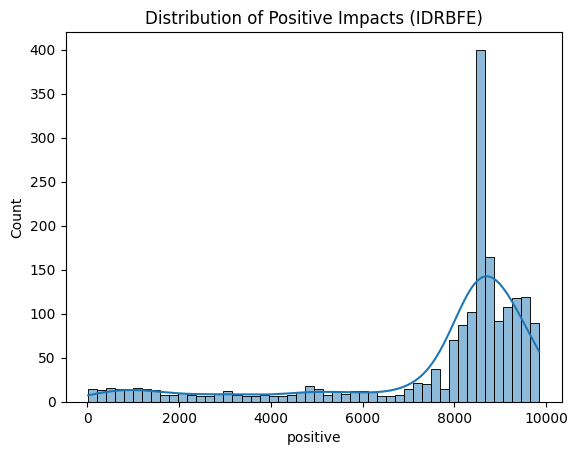

In [63]:
sns.histplot(idrbfe_impact_all_df['positive'], bins=50, kde=True)
plt.title('Distribution of Positive Impacts (IDRBFE)')

Text(0.5, 1.0, 'Distribution of Positive Impacts (FE)')

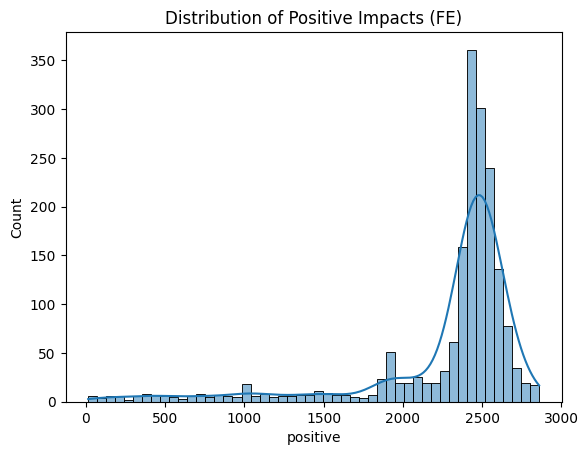

In [65]:
sns.histplot(fe_impact_all_df['positive'], bins=50, kde=True)
plt.title('Distribution of Positive Impacts (FE)')

In [61]:
idrbfe_impact_all_df['negative'].value_counts()

negative
314    25
279    24
282    23
281    22
275    22
       ..
406     1
16      1
404     1
8       1
381     1
Name: count, Length: 299, dtype: int64

# Regression - IDRBFE

In [26]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()

Date    c5    c3
0  1-Mar-99  3.10  5.44
1  2-Mar-99  3.03  5.50
2  3-Mar-99  3.10  5.54
3  4-Mar-99  3.11  5.52
4  5-Mar-99  3.15  5.52

In [27]:
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)

In [28]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idrbfe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

print(c5_w_df.head())

              c5  positive_impact  negative_impact
Date                                              
1999-03-07  3.11              0.0              0.0
1999-03-14  3.30              0.0              0.0
1999-03-21  3.61              0.0              0.0
1999-03-28  3.37              0.0              0.0
1999-04-04  3.35              0.0              0.0


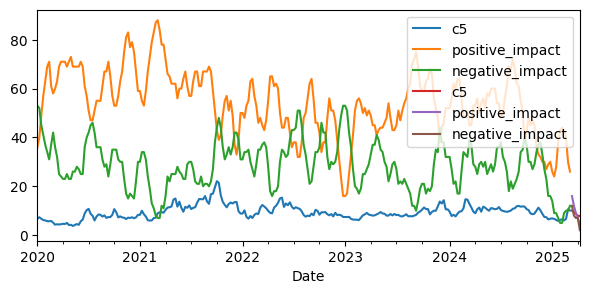

In [29]:
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]

fig, ax = plt.subplots(figsize=(7, 3))
train.plot(ax=ax, label = "Train")
test.plot(ax=ax, label = "Test")
ax.legend()

In [30]:
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [31]:
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [32]:
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score


In [34]:
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}

In [35]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each regressor
reg_param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'model__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'model__alpha': [0.01, 0.1, 1, 10, 100]},
    'ElasticNet Regression': {
        'model__alpha': [0.01, 0.1, 1, 10],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVR': {
        'model__C': [0.1, 1, 10, 100],
        'model__epsilon': [0.01, 0.1, 1],
        'model__kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10, 20]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7, -1]
    }
}

In [36]:
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []

In [38]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
4                        SVR  Default        None  1.074591  0.618780
0           LinearRegression  Default        None  1.156908  0.558138
1                      Ridge  Default        None  1.191205  0.531551
5      RandomForestRegressor  Default        None  1.212320  0.514797
6  GradientBoostingRegressor  Default        None  1.231496  0.499326
8              LGBMRegressor  Default        None  1.322962  0.422192
7               XGBRegressor  Default        None  1.407885  0.345631
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768


In [39]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
6  GradientBoostingRegressor  Default        None  0.990666  0.676001
1                      Ridge  Default        None  1.031192  0.648951
0           LinearRegression  Default        None  1.037645  0.644543
4                        SVR  Default        None  1.166943  0.550439
5      RandomForestRegressor  Default        None  1.170490  0.547703
7               XGBRegressor  Default        None  1.304015  0.438624
8              LGBMRegressor  Default        None  1.483742  0.273216
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768


In [40]:
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  0.980314  0.682737
1                      Ridge  Default        None  1.027498  0.651461
4                        SVR  Default        None  1.075626  0.618045
6  GradientBoostingRegressor  Default        None  1.249332  0.484718
5      RandomForestRegressor  Default        None  1.292365  0.448609
7               XGBRegressor  Default        None  1.377892  0.373214
8              LGBMRegressor  Default        None  1.459772  0.296508
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768


# Optimize window and horizon

In [82]:
# Define parameter search space
window_sizes = range(1, 10)
forecast_horizons = range(1, 6)

# Store results
optimization_results = []

# Loop over combinations
for window_size in window_sizes:
    for forecast_horizon in forecast_horizons:
        X = []
        y = []

        # Prepare features and target
        for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
            c5_lags = c5_w_df['c5'].values[i:i+window_size]
            pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
            neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
            X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
            y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

        if len(X) < 10:
            continue  # skip if too few samples

        X = np.array(X)
        y = np.array(y)

        columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
        columns += ['positive_impact_t', 'negative_impact_t']
        X_df = pd.DataFrame(X, columns=columns)

        # Split
        split = int(len(X_df) * 0.8)
        X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
        y_train, y_test = y[:split], y[split:]

        # Evaluate pipelines
        for name, pipe in pipelines.items():
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            optimization_results.append((name, window_size, forecast_horizon, mse, r2))

# Convert results to DataFrame and sort
opt_df = pd.DataFrame(optimization_results, columns=['Model', 'Window_Size', 'Forecast_Horizon', 'MSE', 'R2'])
opt_df = opt_df.sort_values(by='R2', ascending=False)


print(opt_df.head(10))


                 Model  Window_Size  Forecast_Horizon       MSE        R2
360  Linear Regression            9                 1  0.845653  0.741438
315  Linear Regression            8                 1  0.855047  0.738566
270  Linear Regression            7                 1  0.860906  0.736774
225  Linear Regression            6                 1  0.871403  0.733565
361   Ridge Regression            9                 1  0.898484  0.725285
316   Ridge Regression            8                 1  0.913394  0.720726
271   Ridge Regression            7                 1  0.915274  0.720151
226   Ridge Regression            6                 1  0.959550  0.706613
180  Linear Regression            5                 1  0.952917  0.703326
0    Linear Regression            1                 1  0.957212  0.701989


# LSTM

In [330]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Reshape data for LSTM: (samples, seq_len, features)
def reshape_for_lstm(X, window_size, num_features):
    return X.reshape(-1, window_size, num_features)

# Example: if you used all 3 features (c5, positive_impact, negative_impact)
window_size = 3
num_features = 3  # adjust if you use fewer features

X_train_lstm = reshape_for_lstm(X_train.values, window_size, num_features)
X_test_lstm = reshape_for_lstm(X_test.values, window_size, num_features)

y_train_lstm = y_train
y_test_lstm = y_test

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last output
        out = self.fc(out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
# Add a scheduler for dynamic learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
epochs = 110
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)  # update learning rate based on validation loss or avg_loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = []
    trues = []
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.numpy())
from sklearn.metrics import mean_squared_error, r2_score
print("LSTM MSE:", mean_squared_error(trues, preds))
print("LSTM R2:", r2_score(trues, preds))

Epoch 1/110, Loss: 61.7324, LR: 0.010000
Epoch 2/110, Loss: 11.7612, LR: 0.010000
Epoch 3/110, Loss: 9.8144, LR: 0.010000
Epoch 4/110, Loss: 9.6150, LR: 0.010000
Epoch 5/110, Loss: 9.6407, LR: 0.010000
Epoch 6/110, Loss: 9.3216, LR: 0.010000
Epoch 7/110, Loss: 8.8541, LR: 0.010000
Epoch 8/110, Loss: 8.0222, LR: 0.010000
Epoch 9/110, Loss: 6.6199, LR: 0.010000
Epoch 10/110, Loss: 5.0152, LR: 0.010000
Epoch 11/110, Loss: 3.9615, LR: 0.010000
Epoch 12/110, Loss: 3.1327, LR: 0.010000
Epoch 13/110, Loss: 2.8684, LR: 0.010000
Epoch 14/110, Loss: 2.5030, LR: 0.010000
Epoch 15/110, Loss: 2.4472, LR: 0.010000
Epoch 16/110, Loss: 2.3520, LR: 0.010000
Epoch 17/110, Loss: 2.1720, LR: 0.010000
Epoch 18/110, Loss: 2.4734, LR: 0.010000
Epoch 19/110, Loss: 2.0858, LR: 0.010000
Epoch 20/110, Loss: 2.0069, LR: 0.010000
Epoch 21/110, Loss: 1.9994, LR: 0.010000
Epoch 22/110, Loss: 1.8693, LR: 0.010000
Epoch 23/110, Loss: 2.0736, LR: 0.010000
Epoch 24/110, Loss: 1.9794, LR: 0.010000
Epoch 25/110, Loss: 2.0

In [336]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare LSTM input: (samples, seq_len, features)
window_size = 6
num_features = 1  # Only c5 as feature

# X_train_raw and X_test_raw are DataFrames of shape (samples, 6)
# Reshape to (samples, 6, 1)
X_train_lstm = X_train_raw.values[..., None]
X_test_lstm = X_test_raw.values[..., None]

y_train_lstm = y_train
y_test_lstm = y_test

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last output
        out = self.fc(out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    preds = []
    trues = []
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.extend(pred)
        trues.extend(yb.numpy())
from sklearn.metrics import mean_squared_error, r2_score
print("LSTM MSE:", mean_squared_error(trues, preds))
print("LSTM R2:", r2_score(trues, preds))

Epoch 1/30, Loss: 98.5466
Epoch 2/30, Loss: 92.4983
Epoch 3/30, Loss: 84.9669
Epoch 4/30, Loss: 77.1523
Epoch 5/30, Loss: 69.1922
Epoch 6/30, Loss: 60.1221
Epoch 7/30, Loss: 50.5826
Epoch 8/30, Loss: 41.8627
Epoch 9/30, Loss: 34.3929
Epoch 10/30, Loss: 28.0713
Epoch 11/30, Loss: 22.4192
Epoch 12/30, Loss: 18.4983
Epoch 13/30, Loss: 15.1822
Epoch 14/30, Loss: 12.9626
Epoch 15/30, Loss: 11.0548
Epoch 16/30, Loss: 9.9628
Epoch 17/30, Loss: 9.1643
Epoch 18/30, Loss: 8.7438
Epoch 19/30, Loss: 8.5282
Epoch 20/30, Loss: 8.4372
Epoch 21/30, Loss: 8.3510
Epoch 22/30, Loss: 8.0463
Epoch 23/30, Loss: 7.9901
Epoch 24/30, Loss: 7.8913
Epoch 25/30, Loss: 7.6503
Epoch 26/30, Loss: 7.2177
Epoch 27/30, Loss: 6.9971
Epoch 28/30, Loss: 6.7032
Epoch 29/30, Loss: 6.3985
Epoch 30/30, Loss: 6.0719
LSTM MSE: 1.9694275749379688
LSTM R2: 0.38685286484770043


# PSO

https://github.com/gouthamk16/LSTM-PSO/blob/main/pso_ver1.0.ipynb

In [64]:
train

c5  positive_impact  negative_impact
Date                                               
2020-01-05   6.73              0.0              3.0
2020-01-12   7.31              2.0              2.0
2020-01-19   6.68              0.0              4.0
2020-01-26   6.16              0.0              2.0
2020-02-02   6.00              0.0              5.0
...           ...              ...              ...
2025-02-09   6.45              4.0              0.0
2025-02-16   6.02              7.0              0.0
2025-02-23   6.65              4.0              0.0
2025-03-02  10.54              5.0              2.0
2025-03-09  10.08              6.0              0.0

[271 rows x 3 columns]

In [128]:
def objective_function(params, X_train, Y_train, X_test, Y_test):

    lstm_units, dropout_rate, dense_units = params

    model = Sequential()
    model.add(LSTM(units=int(lstm_units), return_sequences=True, input_shape=(n_past, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(dense_units), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, epochs = 40, verbose = False)

    predictions = model.predict(X_test)
    r2 = r2_score(Y_test, predictions)
    #mse = mean_squared_error(Y_test, predictions)
    return -r2  # negative R-squared for minimization

def particle_swarm_optimization(objective_function, no_particle, no_dim, x_range, v_range, iw_range, c, X_train, Y_train, X_test, Y_test, print_step, iter):

    particles = np.random.uniform([r[0] for r in x_range], [r[1] for r in x_range], size=(no_particle, no_dim))
    velocities = np.random.uniform([r[0] for r in v_range], [r[1] for r in v_range], size=(no_particle, no_dim))
    pbest = np.full(no_particle, np.inf)
    pbestpos = np.zeros((no_particle, no_dim))
    gbest = np.inf
    gbestpos = np.zeros((no_dim,))

    for i in range(iter):
        print(f"Iteration {i+1}/{iter}")

        for j, particle in enumerate(particles):

            fitness = objective_function(particle, X_train, Y_train, X_test, Y_test)

            if fitness < pbest[j]:
                pbest[j] = fitness
                pbestpos[j] = particle.copy()
            if fitness < gbest:
                gbest = fitness
                gbestpos = particle.copy()

        for j, particle in enumerate(particles):
            iw = np.random.uniform(iw_range[0], iw_range[1], 1)[0]
            velocities[j] = (
                iw * velocities[j]
                + (c[0] * np.random.uniform(0.0, 1.0, (no_dim,)) * (pbestpos[j] - particle))
                + (c[1] * np.random.uniform(0.0, 1.0, (no_dim,)) * (gbestpos - particle))
            )
            particles[j] += velocities[j]

    return gbestpos

In [129]:
x_range = [
    (8, 64),      # lstm_units
    (0.0, 0.5),   # dropout_rate
    (4, 64)       # dense_units
]
v_range = [
    (-4, 4),      # for each param
    (-0.1, 0.1),
    (-4, 4)
]
iw_range = (0.7, 1.2)
c = (1.5, 1.5)
no_particle = 10
no_dim = 3
iter = 10

In [130]:
best_params = particle_swarm_optimization(
    objective_function, no_particle, no_dim, x_range, v_range, iw_range, c,
    X_train, y_train, X_test, y_test, print_step=1, iter=iter
)

Iteration 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Iteration 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Iteration 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


: 

In [1]:
predictions = lstm_model.predict(x_test)
# Inverse transform the predicted and actual prices
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'lstm_model' is not defined

In [113]:
print("X_train shape in objective:", X_train.shape)
print("Y_train shape in objective:", Y_train.shape)
print("X_val shape in objective:", X_val.shape)
print("Y_val shape in objective:", Y_val.shape)

X_train shape in objective: (216, 18)


NameError: name 'Y_train' is not defined

In [67]:
# Run PSO optimization
no_particle = 10
n_past = 2
no_dim = 3
x_range = [(50, 200), (0.1, 0.5), (8, 32)]
v_range = [(1, 10), (0.01, 0.1), (1, 10)]
iw_range = (0.1, 0.5)
c = (1.4962, 1.4962)  # cognitive and social parameters
# Run PSO optimization
best_params = particle_swarm_optimization(objective_function, no_particle, no_dim, x_range, v_range, iw_range, c, x_train, y_train, x_test, y_test, 10, 2)

1 / 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2 / 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


In [32]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (100, 10, 5)
X_val shape: (20, 10, 5)
y_train shape: (100,)
y_val shape: (20,)


# Regression - FE

In [41]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = fe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
4                        SVR  Default        None  0.910943  0.726050
1                      Ridge  Default        None  0.921288  0.719793
0           LinearRegression  Default        None  0.938143  0.709446
5      RandomForestRegressor  Default        None  1.478503  0.278339
8              LGBMRegressor  Default        None  1.495343  0.261806
6  GradientBoostingRegressor  Default        None  1.519867  0.237394
2                      Lasso  Default        None  1.741094 -0.000768
3                 ElasticNet  Default        None  1.741094 -0.000768
7               XGBRegressor  Default        None  1.760203 -0.022856
                       Model  Default Best Params      RMSE        R2
4                        SVR  Default        None  0.854772  0.758793
0           LinearRegression  Default        None  0.889418  0.738844
1                      Ridge  Default        None  0.953597  0.699794
6  GradientBoostingR

# Regression - RAG

In [42]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = rag_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  0.898550  0.733453
1                      Ridge  Default        None  0.943683  0.706004
8              LGBMRegressor  Default        None  1.223353  0.505925
6  GradientBoostingRegressor  Default        None  1.234465  0.496909
4                        SVR  Default        None  1.277464  0.461251
5      RandomForestRegressor  Default        None  1.286138  0.453910
7               XGBRegressor  Default        None  1.328227  0.417584
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  0.959665  0.695961
1                      Ridge  Default        None  1.025239  0.652992
4                        SVR  Default        None  1.045685  0.639013
5      RandomForestR

# Regression - IDFE

In [62]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idfe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
1                      Ridge  Default        None  0.745752  0.816398
4                        SVR  Default        None  0.849174  0.761942
0           LinearRegression  Default        None  0.963279  0.693667
5      RandomForestRegressor  Default        None  1.279573  0.459471
8              LGBMRegressor  Default        None  1.411395  0.342363
7               XGBRegressor  Default        None  1.451432  0.304524
6  GradientBoostingRegressor  Default        None  1.460363  0.295939
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
                       Model  Default Best Params      RMSE        R2
1                      Ridge  Default        None  0.925239  0.717384
0           LinearRegression  Default        None  0.963651  0.693431
4                        SVR  Default        None  0.973594  0.687072
6  GradientBoostingR

# Regression - FE all

In [46]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = fe_impact_all_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
8              LGBMRegressor  Default        None  1.441229  0.314267
6  GradientBoostingRegressor  Default        None  1.450599  0.305322
7               XGBRegressor  Default        None  1.592020  0.163268
5      RandomForestRegressor  Default        None  1.654224  0.096605
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
4                        SVR  Default        None  1.943616 -0.247124
0           LinearRegression  Default        None  2.701761 -1.409810
1                      Ridge  Default        None  3.453822 -2.938120
                       Model  Default Best Params      RMSE        R2
8              LGBMRegressor  Default        None  1.303787  0.438820
6  GradientBoostingRegressor  Default        None  1.382874  0.368673
7               XGBRegressor  Default        None  1.594831  0.160311
5      RandomForestR

# Regression - Rag all

In [47]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = rag_impact_all_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.135261  0.574519
8              LGBMRegressor  Default        None  1.323932  0.421344
5      RandomForestRegressor  Default        None  1.365814  0.384154
1                      Ridge  Default        None  1.401770  0.351302
6  GradientBoostingRegressor  Default        None  1.463080  0.293316
7               XGBRegressor  Default        None  1.607221  0.147214
4                        SVR  Default        None  1.708631  0.036203
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.137996  0.572467
1                      Ridge  Default        None  1.178086  0.541812
5      RandomForestRegressor  Default        None  1.291365  0.449462
8              LGBMR

# Regrassion - IDFE all

In [48]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idfe_impact_all_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  0.938011  0.709528
1                      Ridge  Default        None  1.269209  0.468191
8              LGBMRegressor  Default        None  1.278669  0.460234
5      RandomForestRegressor  Default        None  1.437015  0.318271
6  GradientBoostingRegressor  Default        None  1.513839  0.243431
7               XGBRegressor  Default        None  1.664779  0.085040
4                        SVR  Default        None  1.705703  0.039504
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  0.967812  0.690778
1                      Ridge  Default        None  1.163102  0.553394
6  GradientBoostingRegressor  Default        None  1.279901  0.459194
5      RandomForestR

# Regression - IDRBFE all

In [49]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idrbfe_impact_all_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler()
# # c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
# #     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# # )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
7               XGBRegressor  Default        None  1.117165  0.587975
0           LinearRegression  Default        None  1.121634  0.584672
1                      Ridge  Default        None  1.333732  0.412745
8              LGBMRegressor  Default        None  1.351992  0.396556
5      RandomForestRegressor  Default        None  1.396300  0.356355
6  GradientBoostingRegressor  Default        None  1.691791  0.055108
4                        SVR  Default        None  1.716651  0.027134
3                 ElasticNet  Default        None  1.741094 -0.000768
2                      Lasso  Default        None  1.741094 -0.000768
                       Model  Default Best Params      RMSE        R2
0           LinearRegression  Default        None  1.104067  0.597580
8              LGBMRegressor  Default        None  1.381400  0.370018
1                      Ridge  Default        None  1.395539  0.357056
5      RandomForestR

# Sample Regression

## FE

In [50]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = fe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE        R2
1                      Ridge  Default        None  0.297286  0.602106
5      RandomForestRegressor  Default        None  0.462290  0.037838
6  GradientBoostingRegressor  Default        None  0.541865 -0.321908
4                        SVR  Default        None  0.705564 -1.241259
3                 ElasticNet  Default        None  1.022404 -3.706127
8              LGBMRegressor  Default        None  1.040371 -3.872991
2                      Lasso  Default        None  1.040372 -3.872993
0           LinearRegression  Default        None  1.049322 -3.957195
7               XGBRegressor  Default        None  1.505955 -9.210396
                       Model  Default Best Params      RMSE        R2
1                      Ridge  Default        None  0.349010  0.451604
0           LinearRegression  Default        None  0.837893 -2.160792
4                        SVR  Default        None  0.878612 -2.475467
5      RandomForestR

## RAG

In [51]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = rag_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# # 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE         R2
4                        SVR  Default        None  0.777129  -1.718976
8              LGBMRegressor  Default        None  1.040371  -3.872991
3                 ElasticNet  Default        None  1.040372  -3.872993
2                      Lasso  Default        None  1.040372  -3.872993
5      RandomForestRegressor  Default        None  1.160654  -5.064912
1                      Ridge  Default        None  1.311690  -6.746063
7               XGBRegressor  Default        None  2.055245 -18.017172
0           LinearRegression  Default        None  2.108213 -19.010039
6  GradientBoostingRegressor  Default        None  2.144916 -19.712832
                       Model  Default Best Params       RMSE          R2
5      RandomForestRegressor  Default        None   0.056733    0.985509
6  GradientBoostingRegressor  Default        None   0.920975   -2.818690
4                        SVR  Default        None   0.936864   -2.95159

## IDFE

In [52]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idfe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# # 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE         R2
4                        SVR  Default        None  0.626240  -0.765635
5      RandomForestRegressor  Default        None  0.724795  -1.365099
1                      Ridge  Default        None  0.903997  -2.679195
6  GradientBoostingRegressor  Default        None  0.934433  -2.931111
8              LGBMRegressor  Default        None  1.040371  -3.872991
2                      Lasso  Default        None  1.040372  -3.872993
3                 ElasticNet  Default        None  1.052508  -3.987346
7               XGBRegressor  Default        None  1.439491  -8.329032
0           LinearRegression  Default        None  3.555076 -55.900563
                       Model  Default Best Params       RMSE          R2
1                      Ridge  Default        None   0.176434    0.859853
5      RandomForestRegressor  Default        None   0.285881    0.632049
8              LGBMRegressor  Default        None   1.040371   -3.87299

## IDRBFE

In [53]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idrbfe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', rmse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'RMSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params      RMSE         R2
5      RandomForestRegressor  Default        None  0.762690  -1.618875
4                        SVR  Default        None  0.864502  -2.364739
6  GradientBoostingRegressor  Default        None  0.988755  -3.401456
1                      Ridge  Default        None  1.021832  -3.700863
3                 ElasticNet  Default        None  1.033669  -3.810409
8              LGBMRegressor  Default        None  1.040371  -3.872991
2                      Lasso  Default        None  1.040372  -3.872993
7               XGBRegressor  Default        None  1.115293  -4.600108
0           LinearRegression  Default        None  1.717399 -12.278871
                       Model  Default Best Params      RMSE        R2
5      RandomForestRegressor  Default        None  0.370981  0.380384
8              LGBMRegressor  Default        None  1.040371 -3.872991
2                      Lasso  Default        None  1.040372 -3.872993
3         

# Another method - mean

## FE

In [136]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['pr_en_impact_fe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
mean_impact_by_date = mean_impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.230447  -2.212497
8              LGBMRegressor  Default        None   1.545822  -3.035890
2                      Lasso  Default        None   1.545822  -3.035890
3                 ElasticNet  Default        None   1.546166  -3.036789
1                      Ridge  Default        None   1.731172  -3.519810
4                        SVR  Default        None   1.777381  -3.640454
6  GradientBoostingRegressor  Default        None   2.530474  -5.606657
7               XGBRegressor  Default        None   4.238821 -10.066876
0           LinearRegression  Default        None  36.742572 -94.928912
                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.029967  -1.689077
1                      Ridge  Default        None   1.258217  -2.285000
8              LGBMRegressor  Default        None   1.545822  -3

## RAG

In [56]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['pr_en_impact_rag'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
mean_impact_by_date = mean_impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.230447  -2.212497
8              LGBMRegressor  Default        None   1.545822  -3.035890
2                      Lasso  Default        None   1.545822  -3.035890
3                 ElasticNet  Default        None   1.546166  -3.036789
1                      Ridge  Default        None   1.731172  -3.519810
4                        SVR  Default        None   1.777381  -3.640454
6  GradientBoostingRegressor  Default        None   2.530474  -5.606657
7               XGBRegressor  Default        None   4.238821 -10.066876
0           LinearRegression  Default        None  36.742572 -94.928912
                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.029967  -1.689077
1                      Ridge  Default        None   1.258217  -2.285000
8              LGBMRegressor  Default        None   1.545822  -3

## IDFE

In [138]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['pr_en_impact_idfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
mean_impact_by_date = mean_impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.230447  -2.212497
8              LGBMRegressor  Default        None   1.545822  -3.035890
2                      Lasso  Default        None   1.545822  -3.035890
3                 ElasticNet  Default        None   1.546166  -3.036789
1                      Ridge  Default        None   1.731172  -3.519810
4                        SVR  Default        None   1.777381  -3.640454
6  GradientBoostingRegressor  Default        None   2.530474  -5.606657
7               XGBRegressor  Default        None   4.238821 -10.066876
0           LinearRegression  Default        None  36.742572 -94.928912
                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.029967  -1.689077
1                      Ridge  Default        None   1.258217  -2.285000
8              LGBMRegressor  Default        None   1.545822  -3

## IDRBFE

In [139]:
# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['pr_en_impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
mean_impact_by_date = mean_impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0)
c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = sample.date.min()
train_end = sample.date.max() - pd.Timedelta(days=36)

test_start = sample.date.max() - pd.Timedelta(days=35)
test_end = sample.date.max()

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]

results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.230447  -2.212497
8              LGBMRegressor  Default        None   1.545822  -3.035890
2                      Lasso  Default        None   1.545822  -3.035890
3                 ElasticNet  Default        None   1.546166  -3.036789
1                      Ridge  Default        None   1.731172  -3.519810
4                        SVR  Default        None   1.777381  -3.640454
6  GradientBoostingRegressor  Default        None   2.530474  -5.606657
7               XGBRegressor  Default        None   4.238821 -10.066876
0           LinearRegression  Default        None  36.742572 -94.928912
                       Model  Default Best Params        MSE         R2
5      RandomForestRegressor  Default        None   1.029967  -1.689077
1                      Ridge  Default        None   1.258217  -2.285000
8              LGBMRegressor  Default        None   1.545822  -3

# Final method

## Size - Mean

In [106]:
df.columns

Index(['link', 'date', 'title', 'content', 'led_summ', 'bart_summ',
       'impact_idrbfe', 'sen_emb', 'sen_emb_mean', 'sen_emb_max',
       'sen_emb_mix', 'sen_emb_sum', 'sen_emb_concat', 'sen_emb_mix2',
       'full_emb', 'pr_en_vessel_type_fe', 'pr_en_size_of_vessel_idfe',
       'pr_en_vessel_type_idrbfe', 'pr_en_vessel_type_rag',
       'pr_en_vessel_type_idfe', 'pr_en_route_idrbfe', 'pr_en_route_fe',
       'pr_en_size_of_vessel_rag', 'pr_en_size_of_vessel_fe',
       'pr_en_size_of_vessel_idrbfe', 'pr_en_impact_idfe', 'pr_en_route_rag',
       'pr_en_route_idfe', 'pr_en_scale_idfe', 'pr_en_duration_fe',
       'pr_en_duration_idrbfe', 'pr_en_scale_fe', 'pr_en_duration_rag',
       'pr_en_scale_idrbfe', 'pr_en_impact_rag', 'pr_en_scale_rag',
       'pr_en_impact_fe', 'pr_en_impact_idrbfe', 'pr_en_duration_idfe',
       'pr_en_impact_size_fe', 'pr_en_impact_size_idrbfe',
       'pr_en_impact_size_idfe', 'pr_en_impact_size_rag'],
      dtype='object')

In [140]:
subset = df[df['pr_en_size_of_vessel_idrbfe'] == 1]
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
type(c5.c5.iloc[0])
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].mean()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
X_train.head()
X_train_raw.head()
X_train_impact.head()

### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  1.099218  0.637112
1                      Ridge  Default        None  1.153090  0.619327
4                        SVR  Default        None  1.630521  0.461711
5      RandomForestRegressor  Default        None  1.650695  0.455051
6  GradientBoostingRegressor  Default        None  1.684898  0.443760
7               XGBRegressor  Default        None  1.738480  0.426070
8              LGBMRegressor  Default        None  2.015728  0.334542
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768
                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  1.031636  0.659423
1                      Ridge  Default        None  1.186999  0.608132
4                        SVR  Default        None  1.562140  0.484286
5      RandomForestR

## Route - Mean

In [141]:
subset = df[df['pr_en_route_idrbfe'] == 1]
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
type(c5.c5.iloc[0])
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].mean()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 6  # number of past weeks to use as features
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  1.150273  0.620257
1                      Ridge  Default        None  1.383515  0.543256
4                        SVR  Default        None  1.599645  0.471904
6  GradientBoostingRegressor  Default        None  1.684464  0.443903
5      RandomForestRegressor  Default        None  1.763263  0.417889
7               XGBRegressor  Default        None  1.766166  0.416930
8              LGBMRegressor  Default        None  1.930332  0.362734
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768
                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  1.038735  0.657079
1                      Ridge  Default        None  1.345586  0.555778
4                        SVR  Default        None  1.401438  0.537339
6  GradientBoostingR

## Route - Sum

### 1 period

In [142]:
subset = df[df['pr_en_route_idrbfe'] == 1]
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
type(c5.c5.iloc[0])
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].sum()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 6  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.908757  0.722144
1                      Ridge  Default        None  0.919107  0.718979
6  GradientBoostingRegressor  Default        None  1.102390  0.662939
5      RandomForestRegressor  Default        None  1.165411  0.643670
7               XGBRegressor  Default        None  1.278432  0.609114
8              LGBMRegressor  Default        None  1.336921  0.591231
4                        SVR  Default        None  1.553824  0.524912
3                 ElasticNet  Default        None  3.273832 -0.000988
2                      Lasso  Default        None  3.273832 -0.000988
                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.877343  0.731749
1                      Ridge  Default        None  0.959828  0.706528
4                        SVR  Default        None  1.004498  0.692870
5      RandomForestR

### 5 Periods

In [143]:
subset = df[df['pr_en_route_idrbfe'] == 1]
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
type(c5.c5.iloc[0])
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].sum()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 5  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 5

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 6  # number of past weeks to use as features
forecast_horizon = 5  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  1.537318  0.413582
4                        SVR  Default        None  1.586400  0.394859
0           LinearRegression  Default        None  1.641830  0.373715
6  GradientBoostingRegressor  Default        None  2.229710  0.149465
5      RandomForestRegressor  Default        None  2.332003  0.110445
8              LGBMRegressor  Default        None  2.479406  0.054218
7               XGBRegressor  Default        None  2.506558  0.043861
3                 ElasticNet  Default        None  2.622917 -0.000525
2                      Lasso  Default        None  2.622917 -0.000525
                       Model  Default Best Params       MSE        R2
4                        SVR  Default        None  1.325308  0.494454
1                      Ridge  Default        None  1.448088  0.447619
0           LinearRegression  Default        None  1.456107  0.444561
6  GradientBoostingR

### 6 periods

In [144]:
subset = df[df['pr_en_route_idrbfe'] == 1]
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\c5c3.csv', encoding = 'iso-8859-1')
c5.head()
type(c5.c5.iloc[0])
# def fix_num(num):
#   return num.replace('.', '')[:-2]


c5['Date'] = pd.to_datetime(c5['Date'], format = '%d-%b-%y') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.c5)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].sum()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].sum()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 6  # number of past weeks to use as features
forecast_horizon = 6  # number of future weeks to predict

X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 6

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 6  # number of past weeks to use as features
forecast_horizon = 6  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['c5', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['c5', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
1                      Ridge  Default        None  1.576092  0.376303
4                        SVR  Default        None  1.608681  0.363407
0           LinearRegression  Default        None  1.638440  0.351631
5      RandomForestRegressor  Default        None  2.115458  0.162863
6  GradientBoostingRegressor  Default        None  2.433140  0.037149
3                 ElasticNet  Default        None  2.527348 -0.000132
2                      Lasso  Default        None  2.527348 -0.000132
8              LGBMRegressor  Default        None  3.026003 -0.197461
7               XGBRegressor  Default        None  3.220269 -0.274337
                       Model  Default Best Params       MSE        R2
4                        SVR  Default        None  1.346841  0.467023
1                      Ridge  Default        None  1.453704  0.424735
0           LinearRegression  Default        None  1.455146  0.424164
6  GradientBoostingR

### Cut off

In [158]:
c5_w_df

c5  positive_impact  negative_impact
Date                                               
2020-01-05   6.73              3.0              4.0
2020-01-12   7.31              9.0              2.0
2020-01-19   6.68             11.0              2.0
2020-01-26   6.16             17.0              2.0
2020-02-02   6.00             20.0              2.0
...           ...              ...              ...
2025-03-16  10.04             11.0              7.0
2025-03-23   9.33              7.0              5.0
2025-03-30   8.68              4.0              7.0
2025-04-06   7.93              4.0              5.0
2025-04-13   7.79              2.0              0.0

[276 rows x 3 columns]

In [159]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define parameter search space
window_sizes = range(1, 10)
forecast_horizons = range(1, 7)

# Define impact usage toggle
impact_options = [False, True]  # False = only c5, True = use impact

# Ensure your dataframe is date-limited
c5_w_df = c5_w_df.loc[train_start:test_end]

# Store results
optimization_results = []

# Loop over impact setting, window sizes, and forecast horizons
for use_impact in impact_options:
    for window_size in window_sizes:
        for forecast_horizon in forecast_horizons:
            X = []
            y = []

            # Choose columns
            if use_impact:
                feature_cols = ['c5', 'positive_impact', 'negative_impact']  # or 'impact_all' if preferred
            else:
                feature_cols = ['c5']

            values = c5_w_df[feature_cols].values

            # Skip too-small series
            if len(values) < window_size + forecast_horizon:
                continue

            # Build samples
            for i in range(len(values) - window_size - forecast_horizon + 1):
                window = values[i:i+window_size].flatten()
                target = values[i+window_size:i+window_size+forecast_horizon, 0].mean()
                X.append(window)
                y.append(target)

            if len(X) < 20:
                continue  # skip if too few samples

            X = np.array(X)
            y = np.array(y)

            # Train/test split
            split = int(len(X) * 0.8)
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            # Evaluate pipelines
            for name, pipe in pipelines.items():
                try:
                    pipe.fit(X_train, y_train)
                    y_pred = pipe.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    r2 = r2_score(y_test, y_pred)
                    optimization_results.append((
                        name, window_size, forecast_horizon,
                        'Yes' if use_impact else 'No',
                        mse, r2
                    ))
                except Exception as e:
                    print(f"[ERROR] {name} (impact={use_impact}, ws={window_size}, fh={forecast_horizon}): {e}")
                    continue

# Results DataFrame
opt_df = pd.DataFrame(
    optimization_results,
    columns=['Model', 'Window_Size', 'Forecast_Horizon', 'Used_Impact', 'MSE', 'R2']
)

# Sort by R2 descending
opt_df = opt_df.sort_values(by='R2', ascending=False)

# Show top configs
print("Top performing configurations:")
print(opt_df.head(10))


Top performing configurations:
                 Model  Window_Size  Forecast_Horizon Used_Impact       MSE  \
540  Linear Regression            2                 1         Yes  0.708053   
486  Linear Regression            1                 1         Yes  0.708962   
594  Linear Regression            3                 1         Yes  0.709621   
702  Linear Regression            5                 1         Yes  0.716359   
648  Linear Regression            4                 1         Yes  0.731236   
487   Ridge Regression            1                 1         Yes  0.734160   
756  Linear Regression            6                 1         Yes  0.767195   
541   Ridge Regression            2                 1         Yes  0.754944   
864  Linear Regression            8                 1         Yes  0.777764   
378  Linear Regression            8                 1          No  0.787301   

           R2  
540  0.779560  
486  0.779277  
594  0.779072  
702  0.776974  
648  0.772342  
487

In [160]:

opt_df = opt_df.sort_values(by = 'Forecast_Horizon', ascending = True)

opt_df.head(20)

Model  Window_Size  Forecast_Horizon Used_Impact  \
540      Linear Regression            2                 1         Yes   
486      Linear Regression            1                 1         Yes   
594      Linear Regression            3                 1         Yes   
702      Linear Regression            5                 1         Yes   
648      Linear Regression            4                 1         Yes   
487       Ridge Regression            1                 1         Yes   
756      Linear Regression            6                 1         Yes   
541       Ridge Regression            2                 1         Yes   
865       Ridge Regression            8                 1         Yes   
271       Ridge Regression            6                 1          No   
760                    SVR            6                 1         Yes   
814                    SVR            7                 1         Yes   
379       Ridge Regression            8                 1          No   
433       Ridge Regression            9                 1          No   
324      Linear Regression            7                 1          No   
432      Linear Regression            9                 1          No   
110       Lasso Regression            3                 1          No   
111  ElasticNet Regression            3                 1          No   
597  ElasticNet Regression            3                 1         Yes   
596       Lasso Regression            3                 1         Yes   

          MSE        R2  
540  0.708053  0.779560  
486  0.708962  0.779277  
594  0.709621  0.779072  
702  0.716359  0.776974  
648  0.731236  0.772342  
487  0.734160  0.771432  
756  0.767195  0.765427  
541  0.754944  0.764961  
865  0.899743  0.724900  
271  0.899848  0.724867  
760  0.901992  0.724212  
814  0.903677  0.723697  
379  0.905583  0.723114  
433  0.906254  0.722909  
324  0.794372  0.757117  
432  0.794556  0.757061  
110  3.212013 -0.000004  
111  3.212013 -0.000004  
597  3.212013 -0.000004  
596  3.212013 -0.000004

In [161]:

opt_df = opt_df.sort_values(by = 'Window_Size', ascending = True)

opt_df.head(20)

Model  Window_Size  Forecast_Horizon Used_Impact  \
51       Gradient Boosting            1                 6          No   
40                     SVR            1                 5          No   
528      Gradient Boosting            1                 5         Yes   
53                LightGBM            1                 6          No   
487       Ridge Regression            1                 1         Yes   
489  ElasticNet Regression            1                 1         Yes   
3    ElasticNet Regression            1                 1          No   
31                     SVR            1                 4          No   
519      Gradient Boosting            1                 4         Yes   
25                 XGBoost            1                 3          No   
24       Gradient Boosting            1                 3          No   
486      Linear Regression            1                 1         Yes   
514       Ridge Regression            1                 4         Yes   
32           Random Forest            1                 4          No   
525  ElasticNet Regression            1                 5         Yes   
524       Lasso Regression            1                 5         Yes   
526                    SVR            1                 5         Yes   
495      Linear Regression            1                 2         Yes   
517                    SVR            1                 4         Yes   
531      Linear Regression            1                 6         Yes   

          MSE        R2  
51   3.022222 -0.166700  
40   1.742565  0.364343  
528  1.728993  0.369293  
53   2.428626  0.062452  
487  0.734160  0.771432  
489  3.212334 -0.000104  
3    3.212334 -0.000104  
31   1.579391  0.429566  
519  1.593498  0.424471  
25   2.798046  0.015654  
24   2.783826  0.020657  
486  0.708962  0.779277  
514  0.695776  0.748704  
32   3.551768 -0.282804  
525  2.777999 -0.013365  
524  2.777999 -0.013365  
526  0.953733  0.652095  
495  0.793724  0.734844  
517  0.862497  0.688489  
531  0.864384  0.666313

In [162]:
# Filter for Linear Regression only
linear_df = opt_df[opt_df['Model'] == 'Linear Regression']

# Sort by Window_Size and Forecast_Horizon
linear_df = linear_df.sort_values(by=['Window_Size', 'Forecast_Horizon'])

linear_df.head(20)

Model  Window_Size  Forecast_Horizon Used_Impact       MSE  \
486  Linear Regression            1                 1         Yes  0.708962   
0    Linear Regression            1                 1          No  0.851623   
495  Linear Regression            1                 2         Yes  0.793724   
9    Linear Regression            1                 2          No  1.112580   
18   Linear Regression            1                 3          No  1.365329   
504  Linear Regression            1                 3         Yes  0.837354   
513  Linear Regression            1                 4         Yes  0.797035   
27   Linear Regression            1                 4          No  1.511325   
36   Linear Regression            1                 5          No  1.624303   
522  Linear Regression            1                 5         Yes  0.877009   
531  Linear Regression            1                 6         Yes  0.864384   
45   Linear Regression            1                 6          No  1.594179   
54   Linear Regression            2                 1          No  0.831571   
540  Linear Regression            2                 1         Yes  0.708053   
63   Linear Regression            2                 2          No  1.082299   
549  Linear Regression            2                 2         Yes  0.771801   
558  Linear Regression            2                 3         Yes  0.809923   
72   Linear Regression            2                 3          No  1.330883   
567  Linear Regression            2                 4         Yes  0.789065   
81   Linear Regression            2                 4          No  1.508809   

           R2  
486  0.779277  
0    0.734862  
495  0.734844  
9    0.628325  
18   0.519680  
504  0.705421  
513  0.712132  
27   0.454149  
36   0.407483  
522  0.680083  
531  0.666313  
45   0.384582  
54   0.741105  
540  0.779560  
63   0.638441  
549  0.742168  
558  0.715071  
72   0.531799  
567  0.715010  
81   0.455058

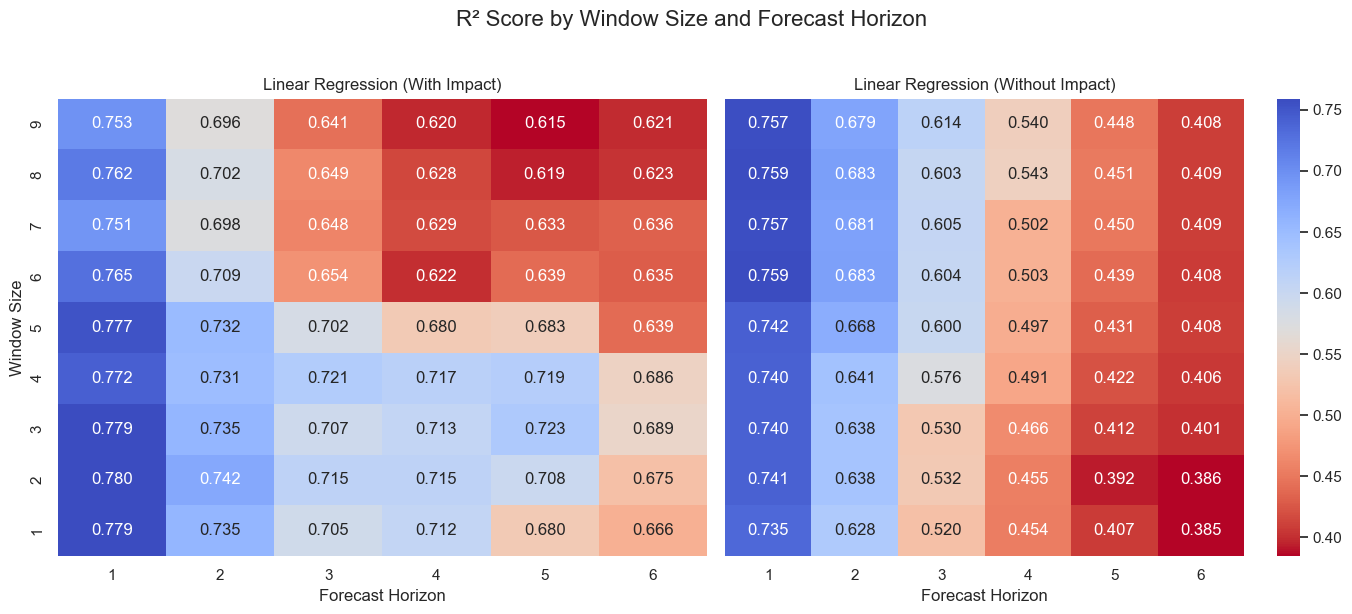

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for Linear Regression
linear_df = opt_df[opt_df['Model'] == 'Linear Regression']

# Pivot for heatmaps
pivot_yes = linear_df[linear_df['Used_Impact'] == 'Yes'].pivot(index='Window_Size', columns='Forecast_Horizon', values='R2')
pivot_no  = linear_df[linear_df['Used_Impact'] == 'No'].pivot(index='Window_Size', columns='Forecast_Horizon', values='R2')

# Plot style
sns.set(style="whitegrid")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Heatmap WITH impact
sns.heatmap(pivot_yes, annot=True, fmt=".3f", cmap="coolwarm_r", ax=axes[0], cbar=False)
axes[0].set_title("Linear Regression (With Impact)")
axes[0].set_xlabel("Forecast Horizon")
axes[0].set_ylabel("Window Size")
axes[0].invert_yaxis()

# Heatmap WITHOUT impact
sns.heatmap(pivot_no, annot=True, fmt=".3f", cmap="coolwarm_r", ax=axes[1])
axes[1].set_title("Linear Regression (Without Impact)")
axes[1].set_xlabel("Forecast Horizon")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

plt.suptitle("R² Score by Window Size and Forecast Horizon", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


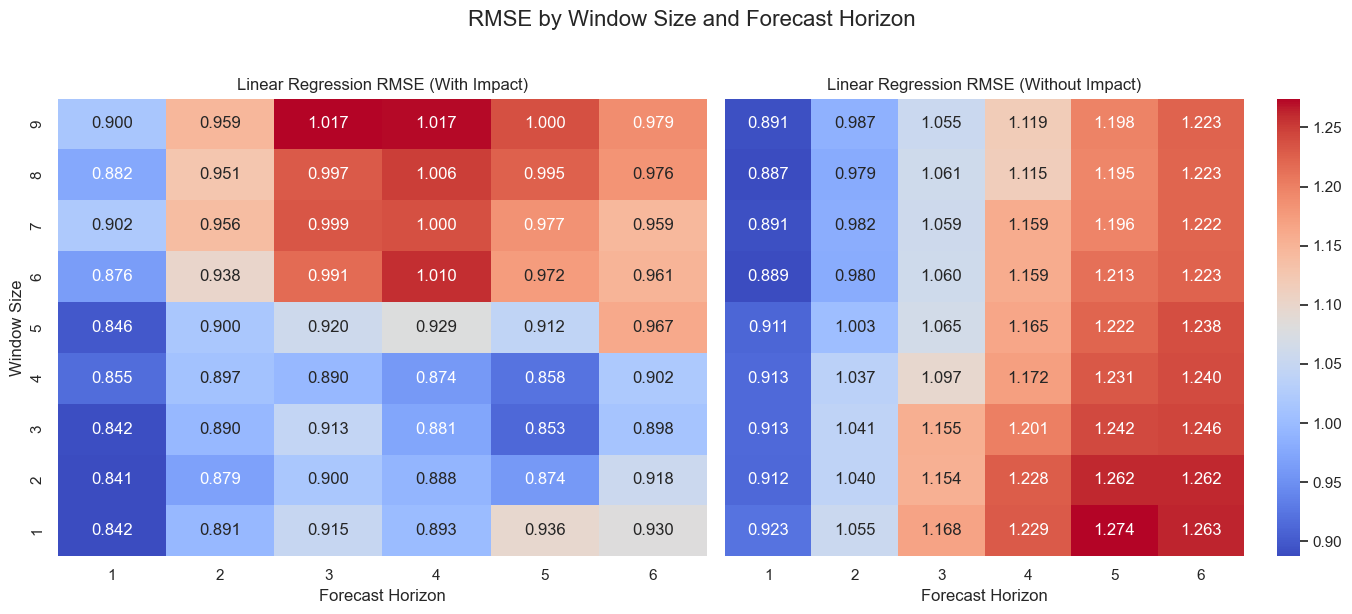

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute RMSE
opt_df['RMSE'] = np.sqrt(opt_df['MSE'])

# Filter for Linear Regression
linear_df = opt_df[opt_df['Model'] == 'Linear Regression']

# Pivot for heatmaps
pivot_yes = linear_df[linear_df['Used_Impact'] == 'Yes'].pivot(index='Window_Size', columns='Forecast_Horizon', values='RMSE')
pivot_no  = linear_df[linear_df['Used_Impact'] == 'No'].pivot(index='Window_Size', columns='Forecast_Horizon', values='RMSE')

# Plot style
sns.set(style="whitegrid")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Heatmap WITH impact
sns.heatmap(pivot_yes, annot=True, fmt=".3f", cmap="coolwarm", ax=axes[0], cbar=False)
axes[0].set_title("Linear Regression RMSE (With Impact)")
axes[0].set_xlabel("Forecast Horizon")
axes[0].set_ylabel("Window Size")
axes[0].invert_yaxis()

# Heatmap WITHOUT impact
sns.heatmap(pivot_no, annot=True, fmt=".3f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Linear Regression RMSE (Without Impact)")
axes[1].set_xlabel("Forecast Horizon")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

plt.suptitle("RMSE by Window Size and Forecast Horizon", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


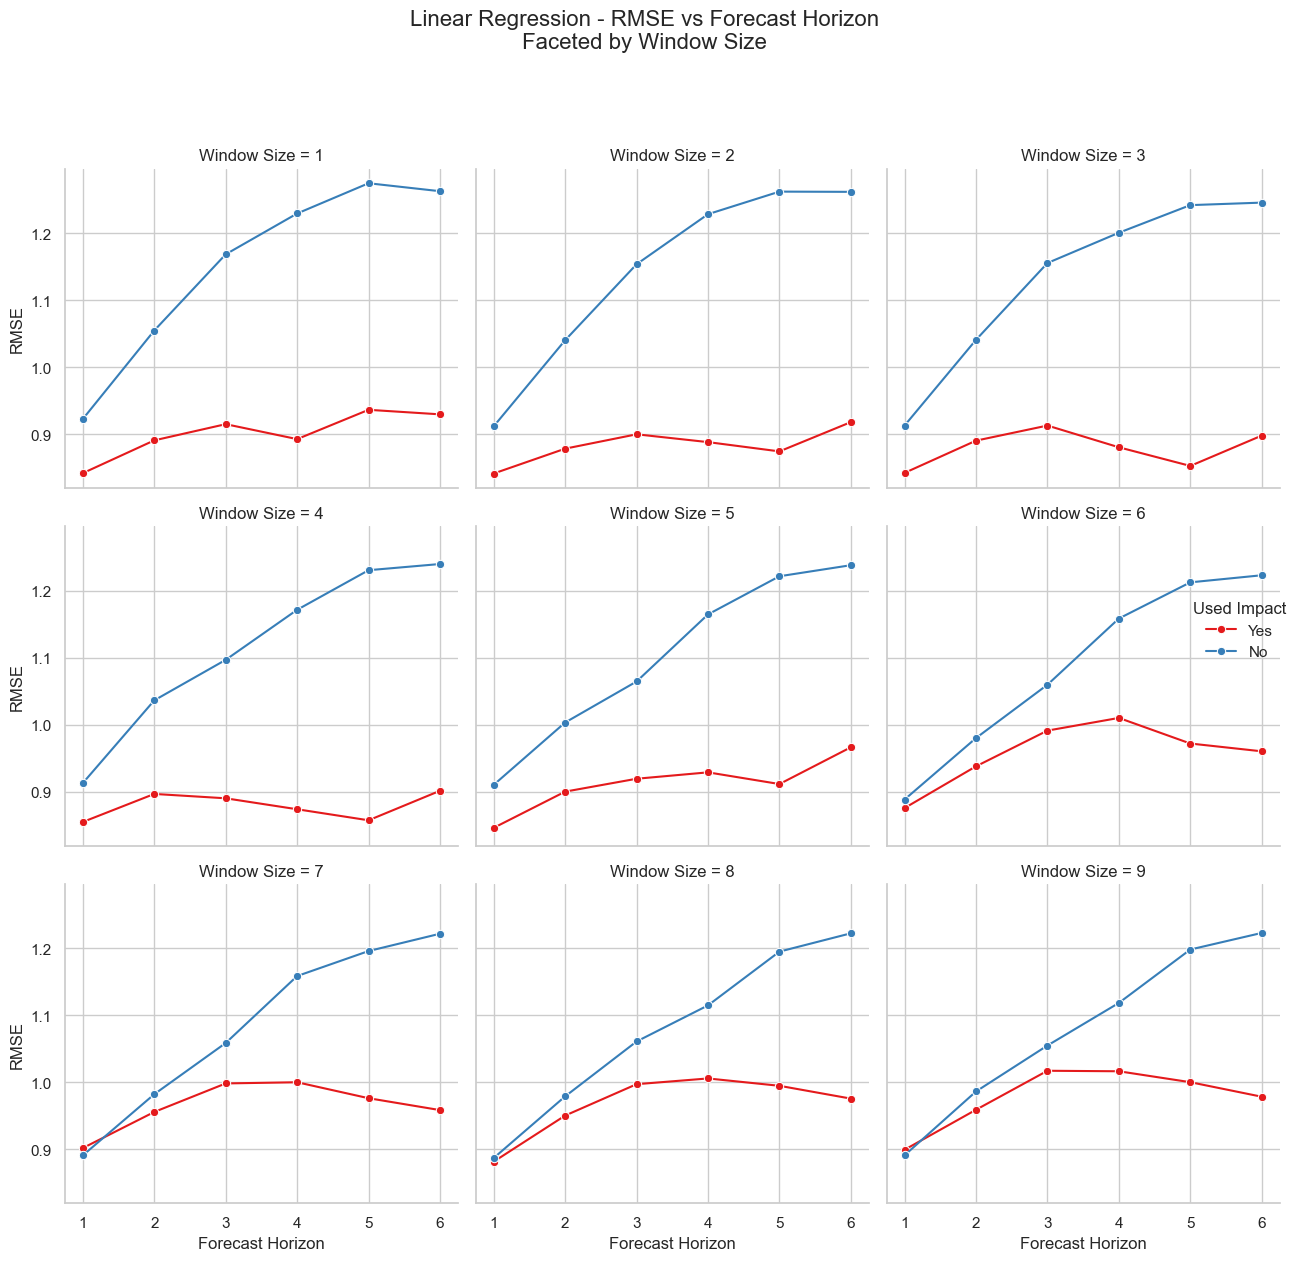

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure RMSE is available
opt_df['RMSE'] = np.sqrt(opt_df['MSE'])

# Filter for Linear Regression
linear_df = opt_df[opt_df['Model'] == 'Linear Regression']

# Set Seaborn style
sns.set(style="whitegrid")

# Create FacetGrid
g = sns.FacetGrid(
    linear_df,
    col="Window_Size",
    col_wrap=3,
    hue="Used_Impact",
    height=4,
    sharey=True,
    palette="Set1"
)

# Line plot inside each facet
g.map(sns.lineplot, "Forecast_Horizon", "RMSE", marker="o")

# Adjust legends and titles
g.add_legend(title="Used Impact")
g.set_titles("Window Size = {col_name}")
g.set_axis_labels("Forecast Horizon", "RMSE")
g.fig.suptitle("Linear Regression - RMSE vs Forecast Horizon\nFaceted by Window Size", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


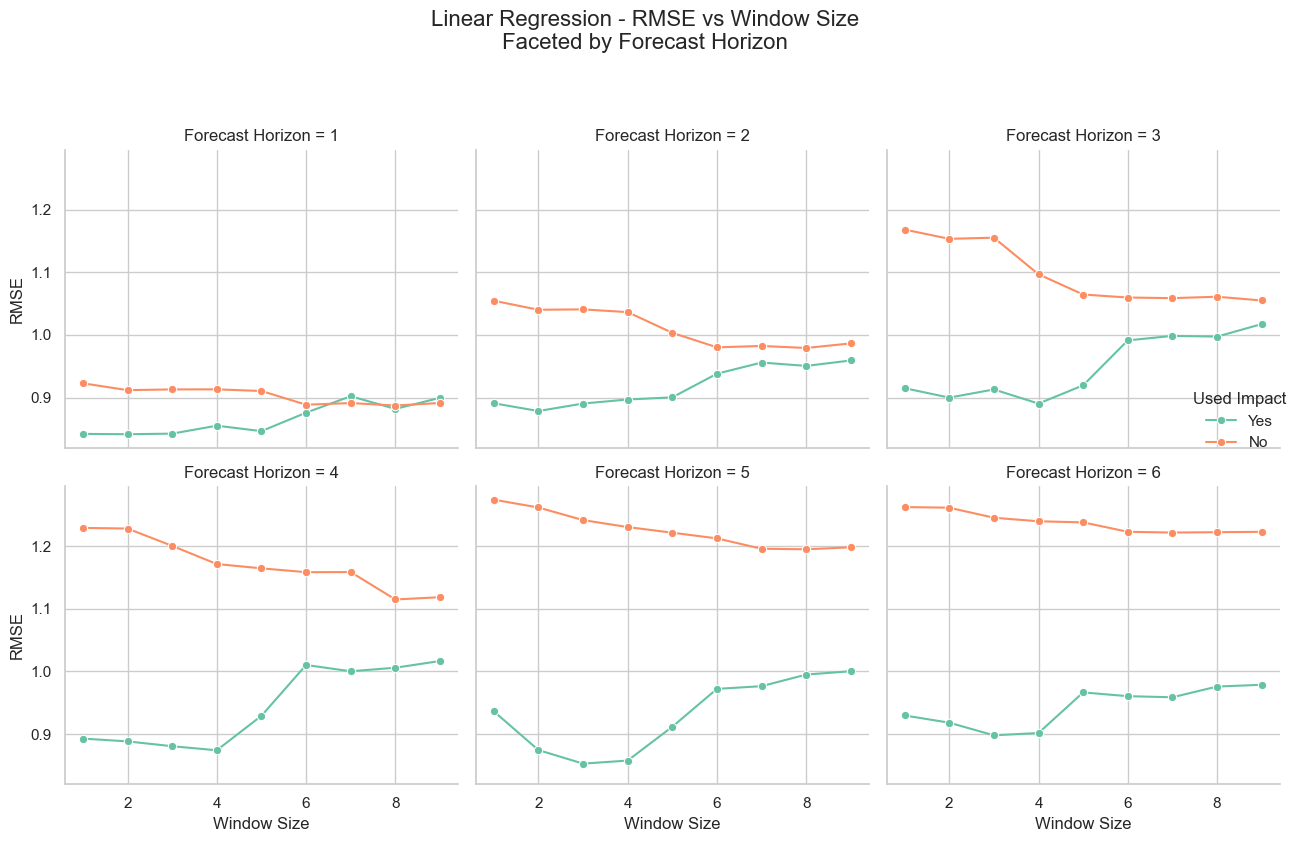

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute RMSE if not already done
opt_df['RMSE'] = np.sqrt(opt_df['MSE'])

# Filter for Linear Regression
linear_df = opt_df[opt_df['Model'] == 'Linear Regression']

# Set Seaborn style
sns.set(style="whitegrid")

# Create FacetGrid with forecast horizon as columns
g = sns.FacetGrid(
    linear_df,
    col="Forecast_Horizon",
    col_wrap=3,
    hue="Used_Impact",
    height=4,
    sharey=True,
    palette="Set2"
)

# Map lineplot to each facet
g.map(sns.lineplot, "Window_Size", "RMSE", marker="o")

# Customize the layout
g.add_legend(title="Used Impact")
g.set_titles("Forecast Horizon = {col_name}")
g.set_axis_labels("Window Size", "RMSE")
g.fig.suptitle("Linear Regression - RMSE vs Window Size\nFaceted by Forecast Horizon", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


# First run

In [154]:
# 1. Aggregate positive and negative impact by date (already in idrbfe_impact_df)
impact_by_date = idrbfe_impact_df[['positive', 'negative']]

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='c5')

# Ensure both indices are sorted for reindex with method='ffill'
impact_by_date = impact_by_date.sort_index()
c5_w_df = c5_w_df.sort_index()

# 3. Add the positive and negative impact features by aligning on the index (date)
c5_w_df['positive_impact'] = impact_by_date['positive'].reindex(c5_w_df.index, method='ffill').fillna(0) - impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)
# c5_w_df['negative_impact'] = impact_by_date['negative'].reindex(c5_w_df.index, method='ffill').fillna(0)

# 4. Scale all features (c5, positive_impact, negative_impact) using MinMaxScaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# c5_w_df[['c5', 'positive_impact', 'negative_impact']] = scaler.fit_transform(
#     c5_w_df[['c5', 'positive_impact', 'negative_impact']]
# )

train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()



c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]



X = []
y = []

values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

split = int(len(X) * 0.8)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]


# Only use 'c5' as feature (no impact, no impact_all)
window_size = 6
forecast_horizon = 2

X = []
y = []

c5_values = c5_w_df['c5'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Use both 'positive_impact' and 'negative_impact' as features, but only current (no lags for impact)
window_size = 6  # number of past weeks to use as features for c5
forecast_horizon = 2  # number of future weeks to predict

X = []
y = []

# We'll use c5 lags, but only the current week's positive/negative impact
for i in range(len(c5_w_df) - window_size - forecast_horizon + 1):
    # c5 lags
    c5_lags = c5_w_df['c5'].values[i:i+window_size]
    # current week's positive/negative impact (at time t = i+window_size-1)
    pos_impact = c5_w_df['positive_impact'].values[i+window_size-1]
    # neg_impact = c5_w_df['negative_impact'].values[i+window_size-1]
    # feature vector: [c5_t-6, ..., c5_t-1, positive_impact_t, negative_impact_t]
    X.append(np.concatenate([c5_lags, [pos_impact, neg_impact]]))
    # target: mean c5 for next 2 weeks
    y.append(c5_w_df['c5'].values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
columns += ['positive_impact_t', 'negative_impact_t']
X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.961015  0.682737
1                      Ridge  Default        None  1.055752  0.651461
4                        SVR  Default        None  1.156972  0.618045
6  GradientBoostingRegressor  Default        None  1.560831  0.484718
5      RandomForestRegressor  Default        None  1.670208  0.448609
7               XGBRegressor  Default        None  1.898587  0.373214
8              LGBMRegressor  Default        None  2.130934  0.296508
3                 ElasticNet  Default        None  3.031407 -0.000768
2                      Lasso  Default        None  3.031407 -0.000768
                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  1.014695  0.665016
1                      Ridge  Default        None  1.108750  0.633965
4                        SVR  Default        None  1.201079  0.603484
6  GradientBoostingR

# BDI

In [155]:
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\bdi.csv', encoding = 'iso-8859-1')
c5.head()

ï»¿Date     Index
0  1-Nov-99  1,334.00
1  2-Nov-99  1,320.00
2  3-Nov-99  1,313.00
3  4-Nov-99  1,301.00
4  5-Nov-99  1,296.00

In [156]:
subset = df[df['pr_en_route_idrbfe'] == 1]
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\bdi.csv', encoding = 'iso-8859-1')
c5.head()
def fix_num(num):
  return num.replace(',', '')[:-2]
c5.Index = c5.Index.apply(fix_num)

c5['Date'] = pd.to_datetime(c5['ï»¿Date'], format='mixed') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.Index)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['impact_idrbfe'].sum()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='Index')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['pr_en_impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()


scaler = MinMaxScaler()
c5_w_df['Index'] = scaler.fit_transform(c5_w_df[['Index']])

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 3  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []


values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 3
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['Index'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 3  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['Index', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['Index', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.000744  0.708668
5      RandomForestRegressor  Default        None  0.000751  0.706105
8              LGBMRegressor  Default        None  0.000763  0.701296
6  GradientBoostingRegressor  Default        None  0.000775  0.696785
1                      Ridge  Default        None  0.000895  0.649498
7               XGBRegressor  Default        None  0.001014  0.603058
4                        SVR  Default        None  0.001884  0.262529
3                 ElasticNet  Default        None  0.003127 -0.223931
2                      Lasso  Default        None  0.003127 -0.223931
                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.000748  0.707208
8              LGBMRegressor  Default        None  0.000785  0.692797
6  GradientBoostingRegressor  Default        None  0.000798  0.687789
5      RandomForestR

In [157]:
subset = df
# subset = subset[subset['pr_en_vessel_type_idrbfe'] == 1]?
subset.shape
subset.date.value_counts()
# Regression
## Preproc
c5 = pd.read_csv(r'C:\Users\tzora\Desktop\Thesis\bdi.csv', encoding = 'iso-8859-1')
c5.head()
def fix_num(num):
  return num.replace(',', '')[:-2]
c5.Index = c5.Index.apply(fix_num)

c5['Date'] = pd.to_datetime(c5['ï»¿Date'], format='mixed') # Changed format to '%d-%b-%Y' to match the actual date format in the CSV file
c5.set_index('Date', inplace=True)
c5.sort_index(inplace=True)

# # # Set the dataset frequency to be (D)aily data
c5_w = c5.asfreq('W', method = 'bfill')

c5_w = pd.to_numeric(c5_w.Index)

# # Fill missing value with the latest available data
c5_w.ffill(inplace=True)
# 1. Aggregate impact by date (mean, sum, or mode depending on your use case)
impact_by_date = subset.groupby('date')['pr_en_impact_idrbfe'].sum()  # or .sum(), .mode()[0], etc.

# 2. Convert c5_w to DataFrame if not already
c5_w_df = c5_w.to_frame(name='Index')

# 3. Add the impact feature by aligning on the index (date)
# If c5_w index is weekly, this will align impact to the closest week
c5_w_df['impact'] = impact_by_date.reindex(c5_w_df.index, method='ffill')  # or method='nearest' if preferred

# 4. (Optional) Fill missing impact values with 0 or another value if needed
c5_w_df['impact'] = c5_w_df['impact'].fillna(0)


# Add a column with the mean impact from the full df (not just subset)
mean_impact_by_date = df.groupby('date')['impact_idrbfe'].mean()

# Add to c5_w_df, aligning by date (forward fill for missing dates)
c5_w_df['impact_all'] = mean_impact_by_date.reindex(c5_w_df.index, method='ffill').fillna(0)

df.date.tail(1)
df.date.head(1)
train_start = df.date.min()
train_end = df.date.max() - pd.Timedelta(days=36)

test_start = df.date.max() - pd.Timedelta(days=35)
test_end = df.date.max()


scaler = MinMaxScaler()
c5_w_df['Index'] = scaler.fit_transform(c5_w_df[['Index']])

c5_w_df = c5_w_df.loc[train_start:test_end]
train = c5_w_df.loc[train_start:train_end]
test = c5_w_df.loc[test_start:test_end]


window_size = 3  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []


values = c5_w_df.values  # shape: (num_weeks, num_features)
feature_names = c5_w_df.columns.tolist()  # e.g., ['c5', 'impact', 'impact_all']

# Build column names like c5_t-6, c5_t-5, ..., impact_all_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # Predict the mean of the next 2 weeks (across all features, or just the first feature?)
    # If you want to predict only the first feature (e.g., 'c5'):
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
# Only use 'c5' as feature (no impact, no impact_all)
window_size = 3
forecast_horizon = 1

X = []
y = []

c5_values = c5_w_df['Index'].values  # shape: (num_weeks,)
for i in range(len(c5_values) - window_size - forecast_horizon + 1):
    window = c5_values[i:i+window_size]
    X.append(window)
    y.append(c5_values[i+window_size:i+window_size+forecast_horizon].mean())

X = np.array(X)
y = np.array(y)

# Build column names: c5_t-6, ..., c5_t-1
columns = [f"c5_t-{window_size - i}" for i in range(window_size)]
X_df = pd.DataFrame(X, columns=columns)

split = int(len(X_df) * 0.8)
X_train_raw, X_test_raw = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]
window_size = 3  # number of past weeks to use as features
forecast_horizon = 1  # number of future weeks to predict

X = []
y = []

# Use only 'c5' and 'impact' columns as features
values = c5_w_df[['Index', 'impact']].values  # shape: (num_weeks, 2)
feature_names = ['Index', 'impact']

# Build column names: c5_t-6, impact_t-6, ..., c5_t-1, impact_t-1
columns = []
for i in range(window_size):
    for feat in feature_names:
        columns.append(f"{feat}_t-{window_size - i}")

for i in range(len(values) - window_size - forecast_horizon + 1):
    window = values[i:i+window_size].flatten()  # flatten to 1D
    X.append(window)
    # y is only c5 (mean of next 2 weeks)
    y.append(values[i+window_size:i+window_size+forecast_horizon, 0].mean())

X = np.array(X)
y = np.array(y)

X_df = pd.DataFrame(X, columns=columns)

# Now split as before
split = int(len(X_df) * 0.8)
X_train_impact, X_test_impact = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y[:split], y[split:]


### Default
reg_models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'ElasticNet Regression': ElasticNet(),
          'SVR': SVR(),
          'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
          'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
          'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)}
pipelines = {name: Pipeline([('scaler', MinMaxScaler()), ('model', model)]) for name, model in reg_models.items()}
results = []
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_impact, y_train)
    y_pred = pipe.predict(X_test_impact)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
results_df = pd.DataFrame([])
results = []
for pipe in pipelines.values():
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((pipe.named_steps['model'].__class__.__name__, 'Default', 'None', mse, r2))
results_df = pd.DataFrame(results, columns=['Model', 'Default', 'Best Params', 'MSE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)

                       Model  Default Best Params       MSE        R2
0           LinearRegression  Default        None  0.000700  0.725951
5      RandomForestRegressor  Default        None  0.000735  0.712462
8              LGBMRegressor  Default        None  0.000759  0.702908
1                      Ridge  Default        None  0.000772  0.697656
7               XGBRegressor  Default        None  0.000805  0.685048
6  GradientBoostingRegressor  Default        None  0.000818  0.679870
4                        SVR  Default        None  0.001710  0.330773
3                 ElasticNet  Default        None  0.003127 -0.223931
2                      Lasso  Default        None  0.003127 -0.223931
                       Model  Default Best Params       MSE        R2
5      RandomForestRegressor  Default        None  0.000663  0.740385
0           LinearRegression  Default        None  0.000718  0.719068
6  GradientBoostingRegressor  Default        None  0.000755  0.704612
1                   

# Diagnostics

In [55]:
c5_w_df

c5  positive_impact  negative_impact
Date                                               
2024-11-17  11.23             33.0             37.0
2024-11-24  10.15             32.0             38.0
2024-12-01   8.71             30.0             33.0
2024-12-08   7.42             30.0             27.0
2024-12-15   7.34             27.0             23.0
2024-12-22   6.42             29.0             16.0
2024-12-29   6.73             30.0             16.0
2025-01-05   6.84             26.0             14.0
2025-01-12   6.63             24.0              9.0
2025-01-19   6.21             28.0              9.0
2025-01-26   5.79             38.0              7.0
2025-02-02   6.27             43.0              5.0
2025-02-09   6.45             44.0              5.0
2025-02-16   6.02             43.0              9.0
2025-02-23   6.65             40.0             10.0
2025-03-02  10.54             30.0             10.0
2025-03-09  10.08             26.0             12.0
2025-03-16  10.04             16.0             12.0
2025-03-23   9.33             12.0              8.0
2025-03-30   8.68              9.0              7.0
2025-04-06   7.93              7.0              7.0
2025-04-13   7.79              4.0              2.0

In [63]:
from statsmodels.tsa.stattools import grangercausalitytests

# Example: test if 'impact' Granger-causes 'c5'
# Make sure both columns have no NaNs and are aligned
data = c5_w_df[['c5', 'positive_impact']].dropna()

# The test expects a 2D array: [target, cause]
max_lag = 6  # You can adjust lag as needed
print("Granger causality test: does 'impact' Granger-cause 'c5'?")
granger_result = grangercausalitytests(data[['c5', 'positive_impact']], maxlag=max_lag, verbose=True)

# To test the reverse direction (does c5 Granger-cause impact?):
print("\nGranger causality test: does 'c5' Granger-cause 'impact'?")
granger_result_rev = grangercausalitytests(data[['positive_impact', 'c5']], maxlag=max_lag, verbose=True)

Granger causality test: does 'impact' Granger-cause 'c5'?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6416 , p=0.0012  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=10.7590 , p=0.0010  , df=1
likelihood ratio test: chi2=10.5539 , p=0.0012  , df=1
parameter F test:         F=10.6416 , p=0.0012  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8675  , p=0.0005  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=16.0274 , p=0.0003  , df=2
likelihood ratio test: chi2=15.5762 , p=0.0004  , df=2
parameter F test:         F=7.8675  , p=0.0005  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0939  , p=0.0019  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=15.6838 , p=0.0013  , df=3
likelihood ratio test: chi2=15.2499 , p=0.0016  , df=3
parameter F test:         F=5.0939  , p=0.0019  , df_denom=266, df_num=3

Granger Causality
number of lags (n

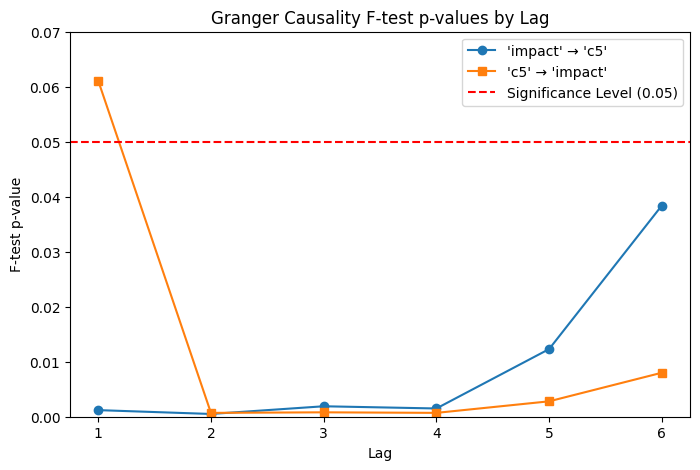

In [65]:
import matplotlib.pyplot as plt
import numpy as np

lags = np.arange(1, 7)
# F-test p-values from your output
pvals_impact_to_c5 = [0.0012, 0.0005, 0.0019, 0.0015, 0.0123, 0.0384]
pvals_c5_to_impact = [0.0611, 0.0007, 0.0008, 0.0007, 0.0028, 0.0080]

plt.figure(figsize=(8, 5))
plt.plot(lags, pvals_impact_to_c5, marker='o', label="'impact' → 'c5'")
plt.plot(lags, pvals_c5_to_impact, marker='s', label="'c5' → 'impact'")
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Lag')
plt.ylabel('F-test p-value')
plt.title('Granger Causality F-test p-values by Lag')
plt.legend()
plt.ylim(0, 0.07)
plt.show()

In [68]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# 1. Prepare data (drop NA, align)
data = c5_w_df[['c5', 'positive_impact']].dropna().copy()
data.columns = ['c5', 'impact']

# 2. Determine max order of integration (dmax) using adfuller with low maxlag
def get_integration_order(series, max_d=2, maxlag=2):
    for d in range(max_d+1):
        try:
            result = adfuller(series.dropna().diff(d).dropna(), maxlag=maxlag, autolag=None)
            pvalue = result[1]
            if pvalue < 0.05:
                return d
        except Exception as e:
            print(f"ADF failed at d={d}: {e}")
            continue
    return max_d

d_c5 = get_integration_order(data['c5'])
d_impact = get_integration_order(data['impact'])
dmax = max(d_c5, d_impact)
print(f"Order of integration: c5={d_c5}, impact={d_impact}, dmax={dmax}")

# 3. Select optimal lag length (AIC)
model = VAR(data)
lag_results = model.select_order(6)  # Use a smaller max lag for short series
k = lag_results.aic
print("Optimal lag (AIC):", k)

# 4. Estimate VAR with (k + dmax) lags
p = k + dmax
var_model = model.fit(p)
print(f"Fitted VAR({p})")

# 5. Toda-Yamamoto Wald test: Does 'impact' cause 'c5'?
wald_res = var_model.test_causality('c5', ['impact'], kind='wald', signif=0.05)
print(wald_res.summary())

# 6. Reverse: Does 'c5' cause 'impact'?
wald_res_rev = var_model.test_causality('impact', ['c5'], kind='wald', signif=0.05)
print(wald_res_rev.summary())


ADF failed at d=0: Invalid input, x is constant
ADF failed at d=0: Invalid input, x is constant
Order of integration: c5=1, impact=1, dmax=1
Optimal lag (AIC): 2
Fitted VAR(3)
Granger causality Wald-test. H_0: impact does not Granger-cause c5. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.28          7.815   0.002  3
----------------------------------------
Granger causality Wald-test. H_0: c5 does not Granger-cause impact. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         17.32          7.815   0.001  3
----------------------------------------


In [69]:
import numpy as np
import pandas as pd
import pyinform

# Prepare your data (dropna, align)
data = c5_w_df[['c5', 'positive_impact']].dropna().copy()
data.columns = ['c5', 'impact']

# Discretize (e.g., 5 bins)
def discretize(series, bins=5):
    return pd.cut(series, bins, labels=False).astype(int)

c5_disc = discretize(data['c5'])
impact_disc = discretize(data['impact'])

# Convert to lists for pyinform
c5_list = c5_disc.tolist()
impact_list = impact_disc.tolist()

# Compute transfer entropy: impact → c5
te_impact_to_c5 = pyinform.transferentropy.transfer_entropy(impact_list, c5_list, k=1)
print(f"Transfer Entropy (impact → c5): {te_impact_to_c5:.4f}")

# Compute transfer entropy: c5 → impact
te_c5_to_impact = pyinform.transferentropy.transfer_entropy(c5_list, impact_list, k=1)
print(f"Transfer Entropy (c5 → impact): {te_c5_to_impact:.4f}")


Transfer Entropy (impact → c5): 0.0921
Transfer Entropy (c5 → impact): 0.1024


In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Example: for your c5_w_df with relevant features
features = ['c5', 'positive_impact', 'negative_impact']
X = c5_w_df[features].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

           feature        VIF
0               c5  12.551974
1  positive_impact   5.995245
2  negative_impact   7.646568
